In [16]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
from datetime import date, timedelta
from functools import reduce
import math
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter("ignore")

# set plot style
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['figure.dpi'] = 400

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn.metrics as metrics
from sklearn import preprocessing

In [17]:
import joblib

# load saved model
lr_model = joblib.load('corona_model.pkl')

# get optimal window from file
with open('window.txt', 'r') as file:
    OPTIMAL_WINDOW = int(file.readline())

In [18]:
def create_dataset(data, window):
    """ Create a dataset using a sliding window over the given data.
    
    Params:
        data (numpy: T): array with case number time series.
        window (int): size of the sliding window, i.e. lookback for predictions.
    Returns:
        x (numpy: T' x W): array with T' samples (T'=T-W), each with W values (window size)
    """
    dataX, dataY = [], []
    for i in range(len(data)-window):
        a = data[i:(i+window)]
        dataX.append(a)
        dataY.append(data[i + window])
    return np.array(dataX), np.array(dataY)

# Compute growth rate timeseries per city

In [19]:
df_city_infected_growth = pd.read_csv('city.csv')

corona_score_growth = {}

for index, row in df_city_infected_growth.iterrows():
    # get city df
    selected_city = row['city']
    
    df_selected_city = df_city_infected_growth.loc[df_city_infected_growth['city'] == selected_city]


    # get numpy array per city
    df_numpy = df_selected_city.drop('city', axis=1)
    selected_city_arr = df_numpy.to_numpy()[0]
    selected_city_removed_arr = np.delete(selected_city_arr, 0)
    selected_city_test_x, selected_city_test_y = create_dataset(selected_city_removed_arr[:100], OPTIMAL_WINDOW)

    # predict per city
    selected_city_predictions = lr_model.predict(selected_city_test_x)

    test = selected_city_predictions

    growth_rate_list = []
    for i, prediction in enumerate(test):
        if (i == 0):
            continue
        growth_rate = (abs(test[i] - test[i-1]) / test[i-1]) * 100.0
        growth_rate_list.append(growth_rate)
            
    norm_growth_rate_list = (growth_rate_list - min(growth_rate_list)) / (max(growth_rate_list) - min(growth_rate_list)) * 100
    corona_score_growth[selected_city] = norm_growth_rate_list[1:15]
    
df_corona_score_growth = pd.DataFrame.from_dict(corona_score_growth, orient='index')
df_corona_score_growth = df_corona_score_growth.reset_index()
df_corona_score_growth.rename(columns={ df_corona_score_growth.columns[0]: "city" }, inplace = True)
df_corona_score_growth

city          0          1          2          3          4  \
0             Munich  91.631468  94.637966  96.566253  97.801849  98.593337   
1             Zurich  47.827213  65.786021  77.397669  84.920204  89.811312   
2        Montpellier  26.846316  45.830027  59.280854  68.850722  75.702377   
3          Barcelona  91.115988  94.305691  96.351704  97.662935  98.503052   
4               Lyon  29.905221  50.783695  65.335477  75.471452  82.533746   
5             Geneva  30.474991  51.705720  66.461610  76.701905  83.802275   
6             Colmar  22.778187  40.344977  53.860164  64.239915  72.200866   
7            Avignon  21.340640  36.900206  48.349558  56.878483  63.330200   
8              Ceret   9.966858  17.897365  24.234402  29.337091  33.483166   
9              Mende   6.591637  12.441760  17.720605  22.554754  27.033378   
10  Titisee-Neustadt  19.479883  34.588976  46.299386  55.371254  62.408073   
11         Mayrhofen  22.141535  39.235870  52.403753  62.532289  70.317479   
12             Bozen  22.971004  40.681890  54.302563  64.757943  72.772847   
13             Digne  14.272520  25.473648  34.279096  41.230350  46.744196   
14            Girona  23.284225  41.228060  55.019537  65.597931  73.699202   
15             Rodez  97.571000  95.343620  93.290258  91.379656  89.593623   
16          Chamonix  12.302106  22.011947  29.697129  35.813698  40.716799   
17         St.Moritz  16.475161  29.335651  39.375586  47.236535  53.406601   
18             Genoa  30.406178  51.594407  66.325741  76.553568  83.649486   
19         Marseille  26.846316  45.830027  59.280854  68.850722  75.702377   
20           Bayonne  14.271562  25.370483  34.153688  41.242672  47.082092   
21          Bordeaux  29.354190  49.891569  64.245477  74.279913  81.304747   
22     Saint Etienne  22.511580  39.880607  53.250383  63.525017  71.412813   
23           Mailand  94.942284  96.768242  97.938482  98.687540  99.166630   
24             Paris  93.435839  95.799781  97.315353  98.285954  98.907207   
25        Strasbourg  30.285356  51.398924  66.087027  76.292790  83.380711   

            5          6          7          8          9         10  \
0   99.100422  99.425470  99.634004  99.767924  99.854014  99.909386   
1   93.008877  95.115182  96.516688  97.461381  98.108472  98.560346   
2   80.650413  84.263532  86.938241  88.950530  90.492651  91.698529   
3   99.041453  99.386724  99.608367  99.750833  99.842534  99.901629   
4   87.460288  90.904180  93.319140  95.019915  96.224604  97.084234   
5   88.723647  92.134872  94.500363  96.142051  97.282851  98.076993   
6   78.303263  82.978135  86.559925  89.305684  91.411472  93.028756   
7   68.298216  72.200182  75.329558  77.892803  80.035145  81.859800   
8   36.892721  39.725826  42.122557  44.180701  45.972366  47.557985   
9   31.220494  35.161416  38.888045  42.423597  45.783871  48.981170   
10  67.881737  72.149061  75.490760  78.120479  80.205560  81.874090   
11  76.300553  80.898876  84.436466  87.162034  89.265810  90.894775   
12  78.910900  83.609240  87.204665  89.956231  92.062822  93.676404   
13  51.148884  54.697263  57.584030  59.961038  61.947906  63.631464   
14  79.896088  84.632096  88.249221  91.010529  93.117793  94.725607   
15  87.915787  86.318536  84.788354  83.313546  81.884661  80.490607   
16  44.683038  47.925133  50.604144  52.856497  54.768842  56.423534   
17  58.274751  62.139374  65.229576  67.729862  69.768839  71.457599   
18  88.571647  91.986999  94.358650  96.007678  97.156400  97.958678   
19  80.650413  84.263532  86.938241  88.950530  90.492651  91.698529   
20  51.986746  56.185037  59.837127  63.061051  65.941041  68.538197   
21  86.235600  89.710370  92.172435  93.929606  95.195264  96.117438   
22  77.464690  82.108012  85.671342  88.408902  90.513944  92.135968   
23  99.472886  99.668560  99.793483  99.873119  99.923736  99.955717   
24  99.304779  99.559216  99.722063  99.826279  99.892923  99.935447   
25  88.304

In [20]:
df_corona_score_growth.to_csv('city_corona_score_growth.csv', index=False)

# Plot infected

In [21]:
df_predictions = pd.DataFrame(columns=['City'] + ["Day " + str(i+1) for i in range(14)])

df_city_infected = pd.read_csv('city.csv')

# plot data
for index, row in df_city_infected.iterrows():
    # get city df
    selected_city = row['city']
    df_selected_city = df_city_infected.loc[df_city_infected['city'] == selected_city]
    
    
    # get numpy array per city
    df_numpy = df_selected_city.drop('city', axis=1)
    selected_city_arr = df_numpy.to_numpy()[0]
    selected_city_test_x, selected_city_test_y = create_dataset(selected_city_arr[0:25], OPTIMAL_WINDOW)
    
    # predict per city
    selected_city_predictions = lr_model.predict(selected_city_test_x)
    df_predictions.loc[index] = [selected_city] + list(selected_city_predictions)
    
df_predictions

City         Day 1         Day 2         Day 3         Day 4  \
0             Munich  16149.729406  18180.209769  20507.114320  23161.746581   
1             Zurich   2273.514709   2558.899786   2885.947784   3259.058589   
2        Montpellier    325.479258    348.652484    374.294557    402.444306   
3          Barcelona  15006.581481  16893.298077  19055.451352  21522.128527   
4               Lyon   1877.720300   2012.878868   2162.437028   2326.621283   
5             Geneva   8074.381603   8656.592510   9300.831095  10008.072984   
6             Colmar    415.435120    420.092095    425.628553    431.886559   
7            Avignon    101.095807    108.081042    115.810472    124.295803   
8              Ceret     10.612366     10.684160     10.769518     10.866004   
9              Mende     10.420342     10.863853     11.354614     11.893367   
10  Titisee-Neustadt     53.177607     53.731526     54.390055     55.134398   
11         Mayrhofen    188.118543    190.200846    192.676399    195.474571   
12             Bozen    647.279927    654.562863    663.221218    673.007958   
13             Digne     18.763137     18.927256     19.122375     19.342919   
14            Girona   5506.056710   5568.371619   5642.455013   5726.193261   
15             Rodez     24.444836     23.464123     22.545022     21.681384   
16          Chamonix     14.234964     14.347798     14.481939     14.633563   
17         St.Moritz     26.913932     27.170375     27.475248     27.819852   
18             Genoa   5798.278073   6216.281884   6678.819106   7186.590219   
19         Marseille    325.479258    348.652484    374.294557    402.444306   
20           Bayonne     35.010309     37.227842     39.681628     42.375383   
21          Bordeaux   1058.567450   1134.628826   1218.793672   1311.189456   
22     Saint Etienne    276.871639    279.959202    283.629862    287.778897   
23           Mailand  31685.748926  35670.046018  40235.994246  45445.016268   
24             Paris  22036.073627  24806.825731  27982.070853  31604.524496   
25        Strasbourg   3872.579514   4151.655601   4460.464003   4799.472404   

           Day 5         Day 6         Day 7         Day 8         Day 9  \
0   26181.721175  29611.193015  33501.284441  37910.689909  42906.448035   
1    3683.519169   4165.535791   4712.294091   5332.044074   6034.208670   
2     433.183886    466.631979    502.939084    542.284363    584.873691   
3   24328.281108  27514.937853  31129.601681  35226.811552  39868.859873   
4    2505.910780   2700.997730   2912.759918   3142.242313   3390.645673   
5   10780.382029  11620.739935  12532.927742  13521.446660  14591.468932   
6     438.744123    446.107260    453.903738    462.078210    470.588536   
7     133.561801    143.644244    154.588494    166.448558    179.286494   
8      10.971741     11.085274     11.205487     11.331526     11.462742   
9      12.481687     13.121842     13.816714     14.569733     15.384838   
10     55.950054     56.825854     57.753190     58.725480     59.737725   
11    198.540839    201.833165    205.319242    208.974337    212.779610   
12    683.732343    695.247379    707.440090    720.223961    733.533040   
13     19.584595     19.844085     20.118848     20.406931     20.706852   
14   5817.954277   5916.480322   6020.804732   6130.187212   6244.063562   
15     20.867993     20.100346     19.374585     18.687327     18.035590   
16     14.799718     14.978120     15.167019     15.365074     15.571267   
17     28.197479     28.602941     29.032270     29.482413     29.951049   
18   7741.077005   8344.420231   8999.334567   9709.051726  10477.285214   
19    433.183886    466.631979    502.939084    542.284363    584.873691   
20     45.316973     48.517746     51.992105     55.757204     59.832737   
21   1412.085818   1521.872312   1641.042914   1770.185693   1909.976386   
22    292.325442    297.207177    302.376208    307.795855    313.438162   
23  51370.917890  58100.337540 

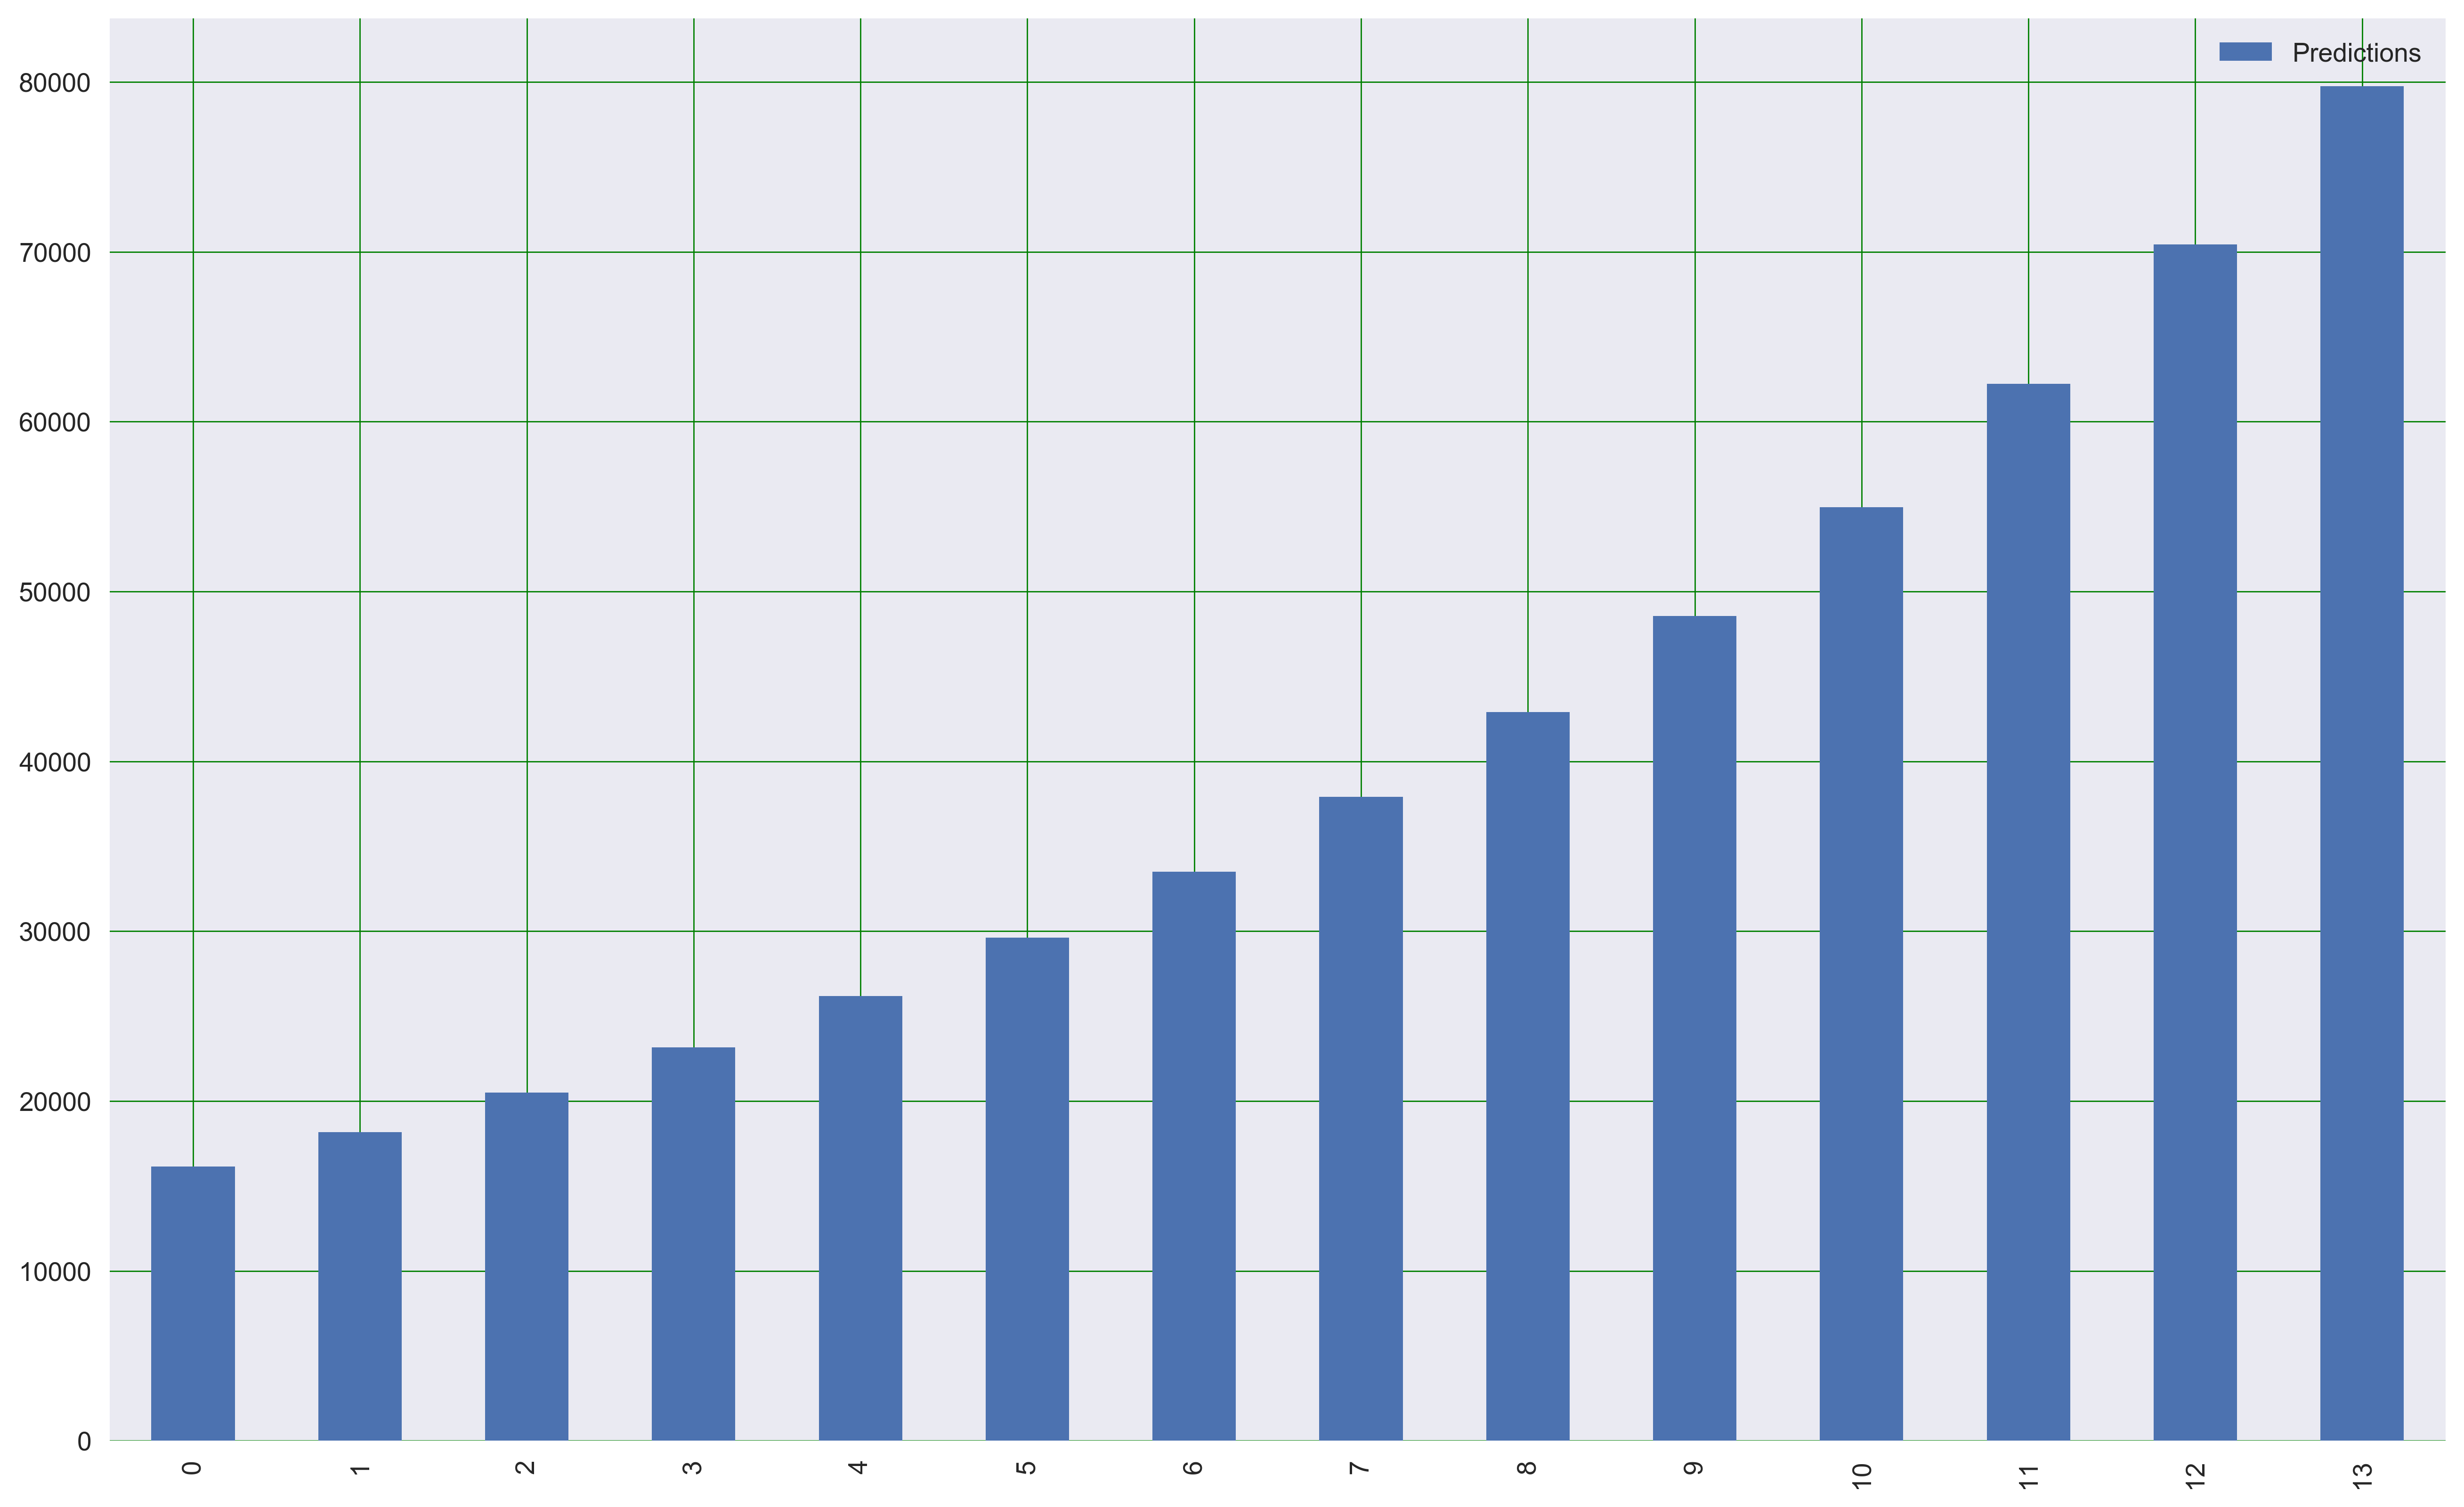

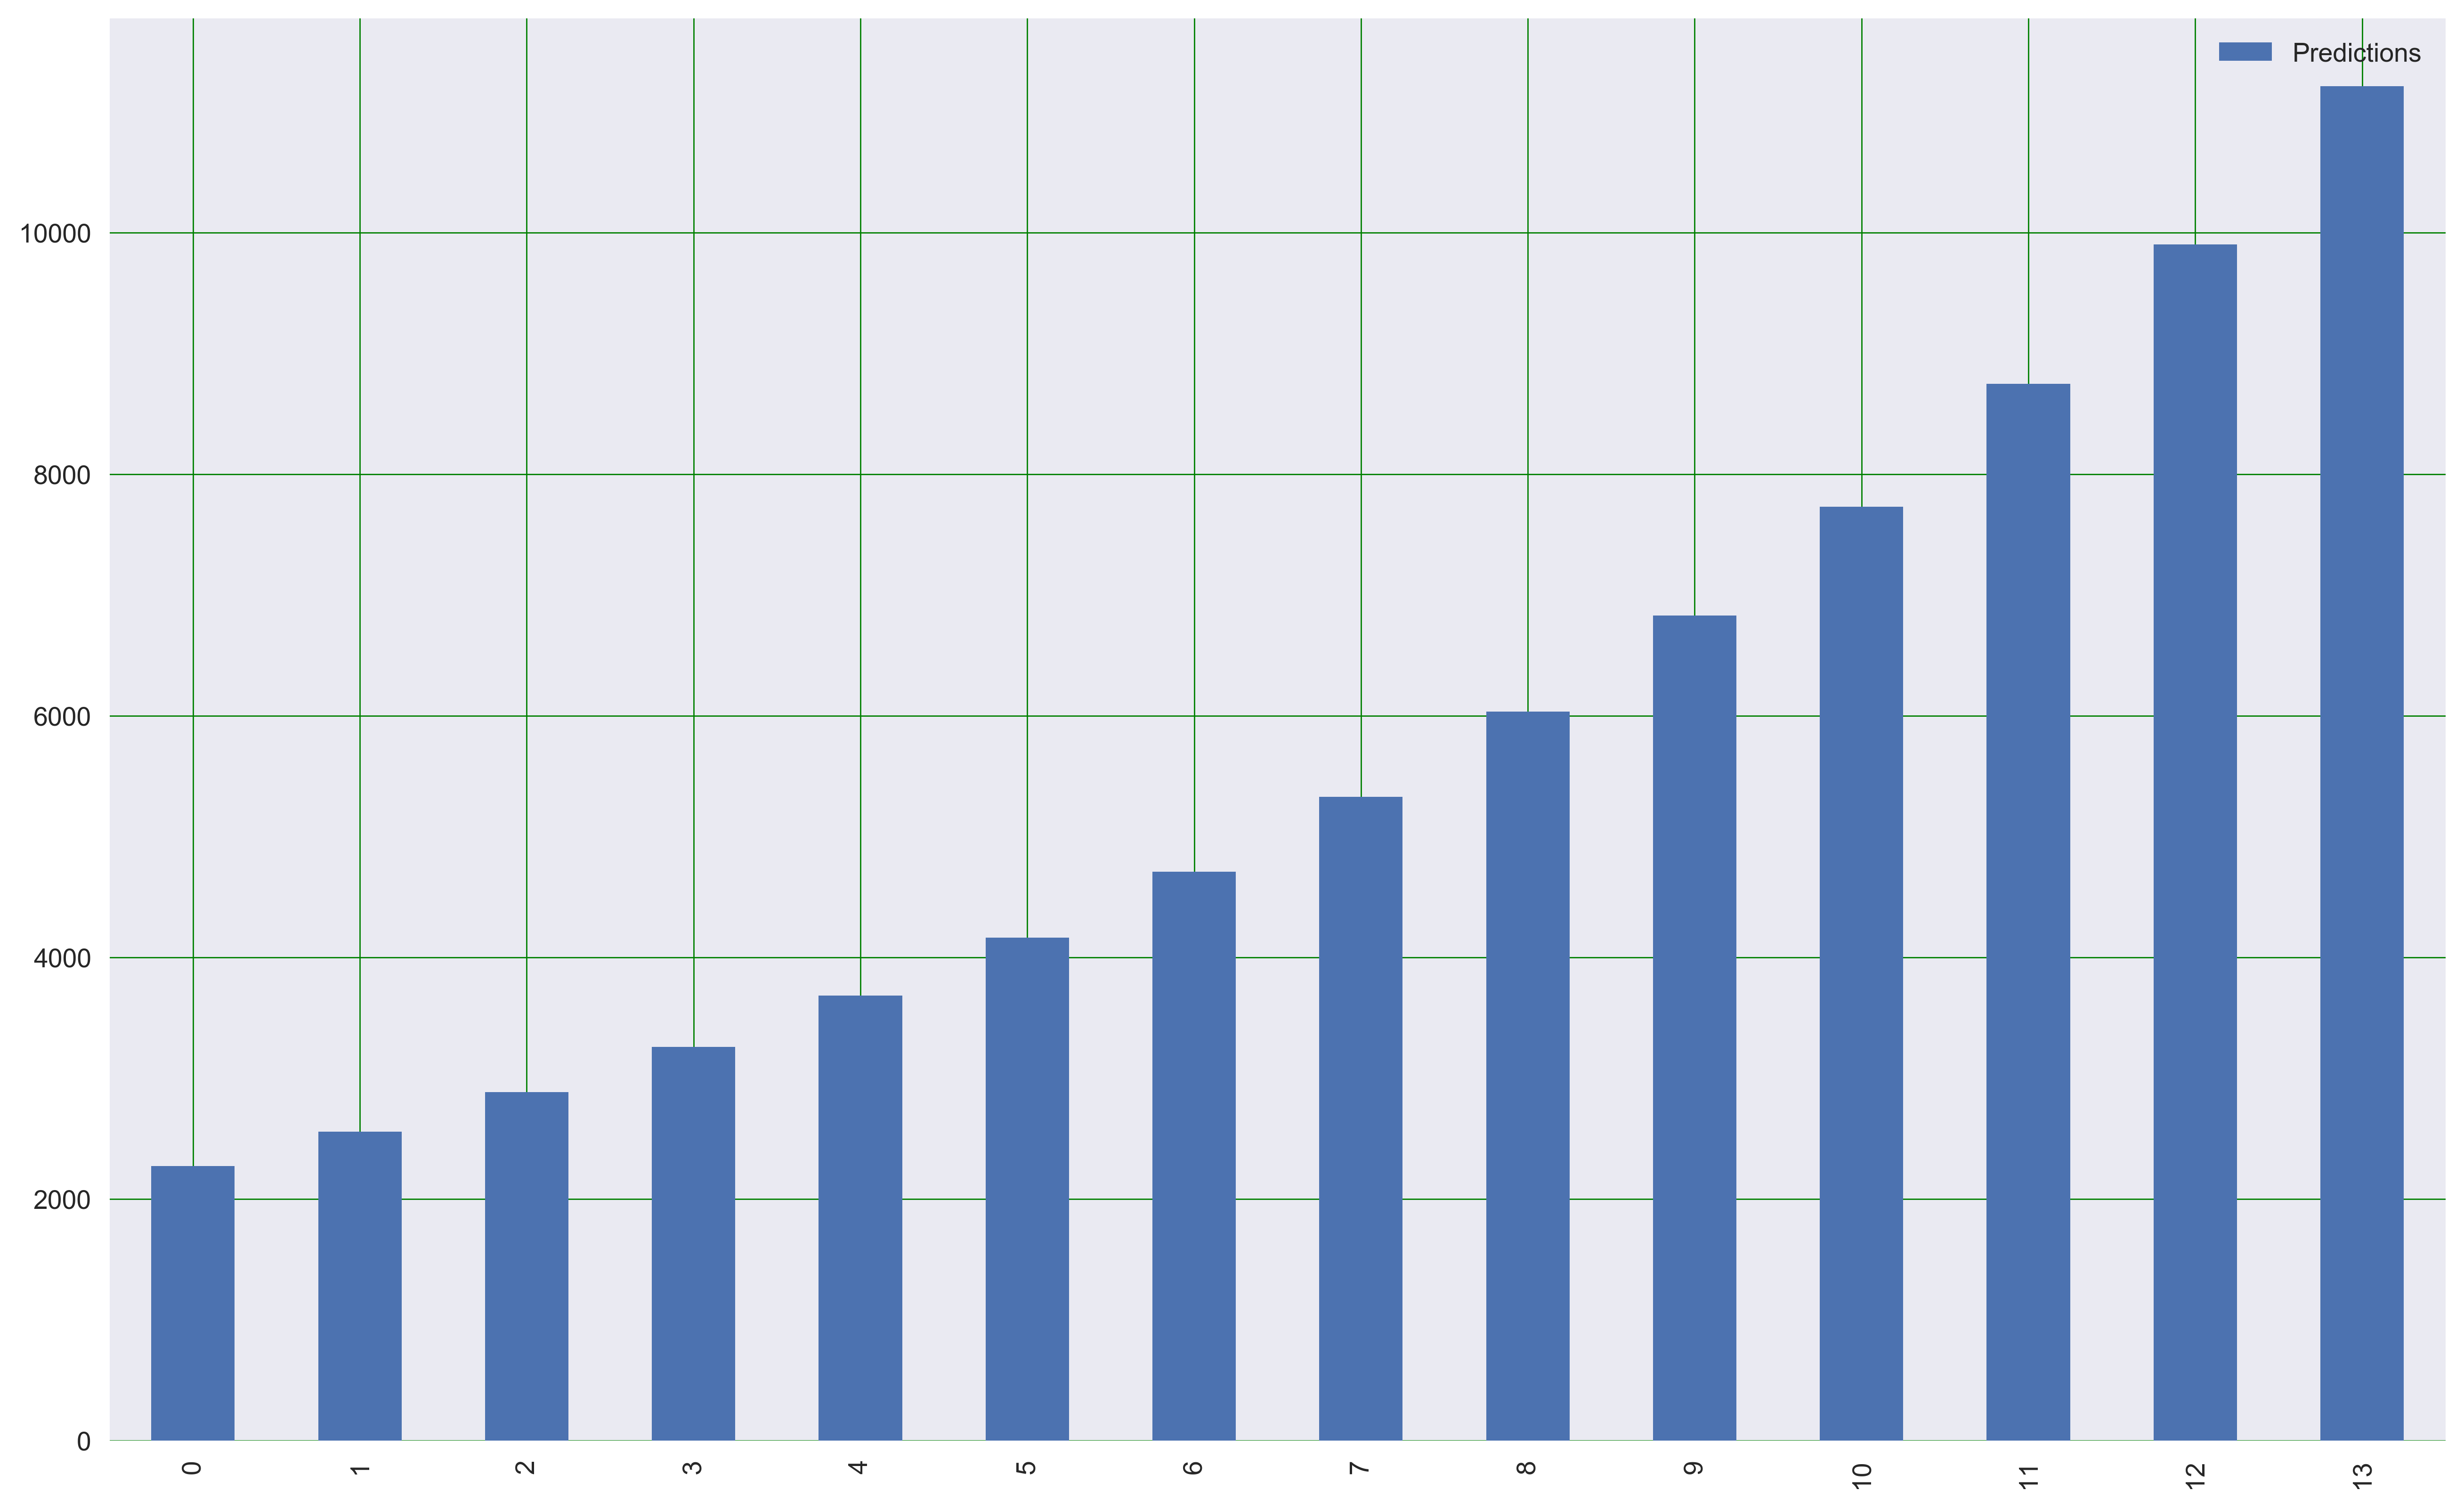

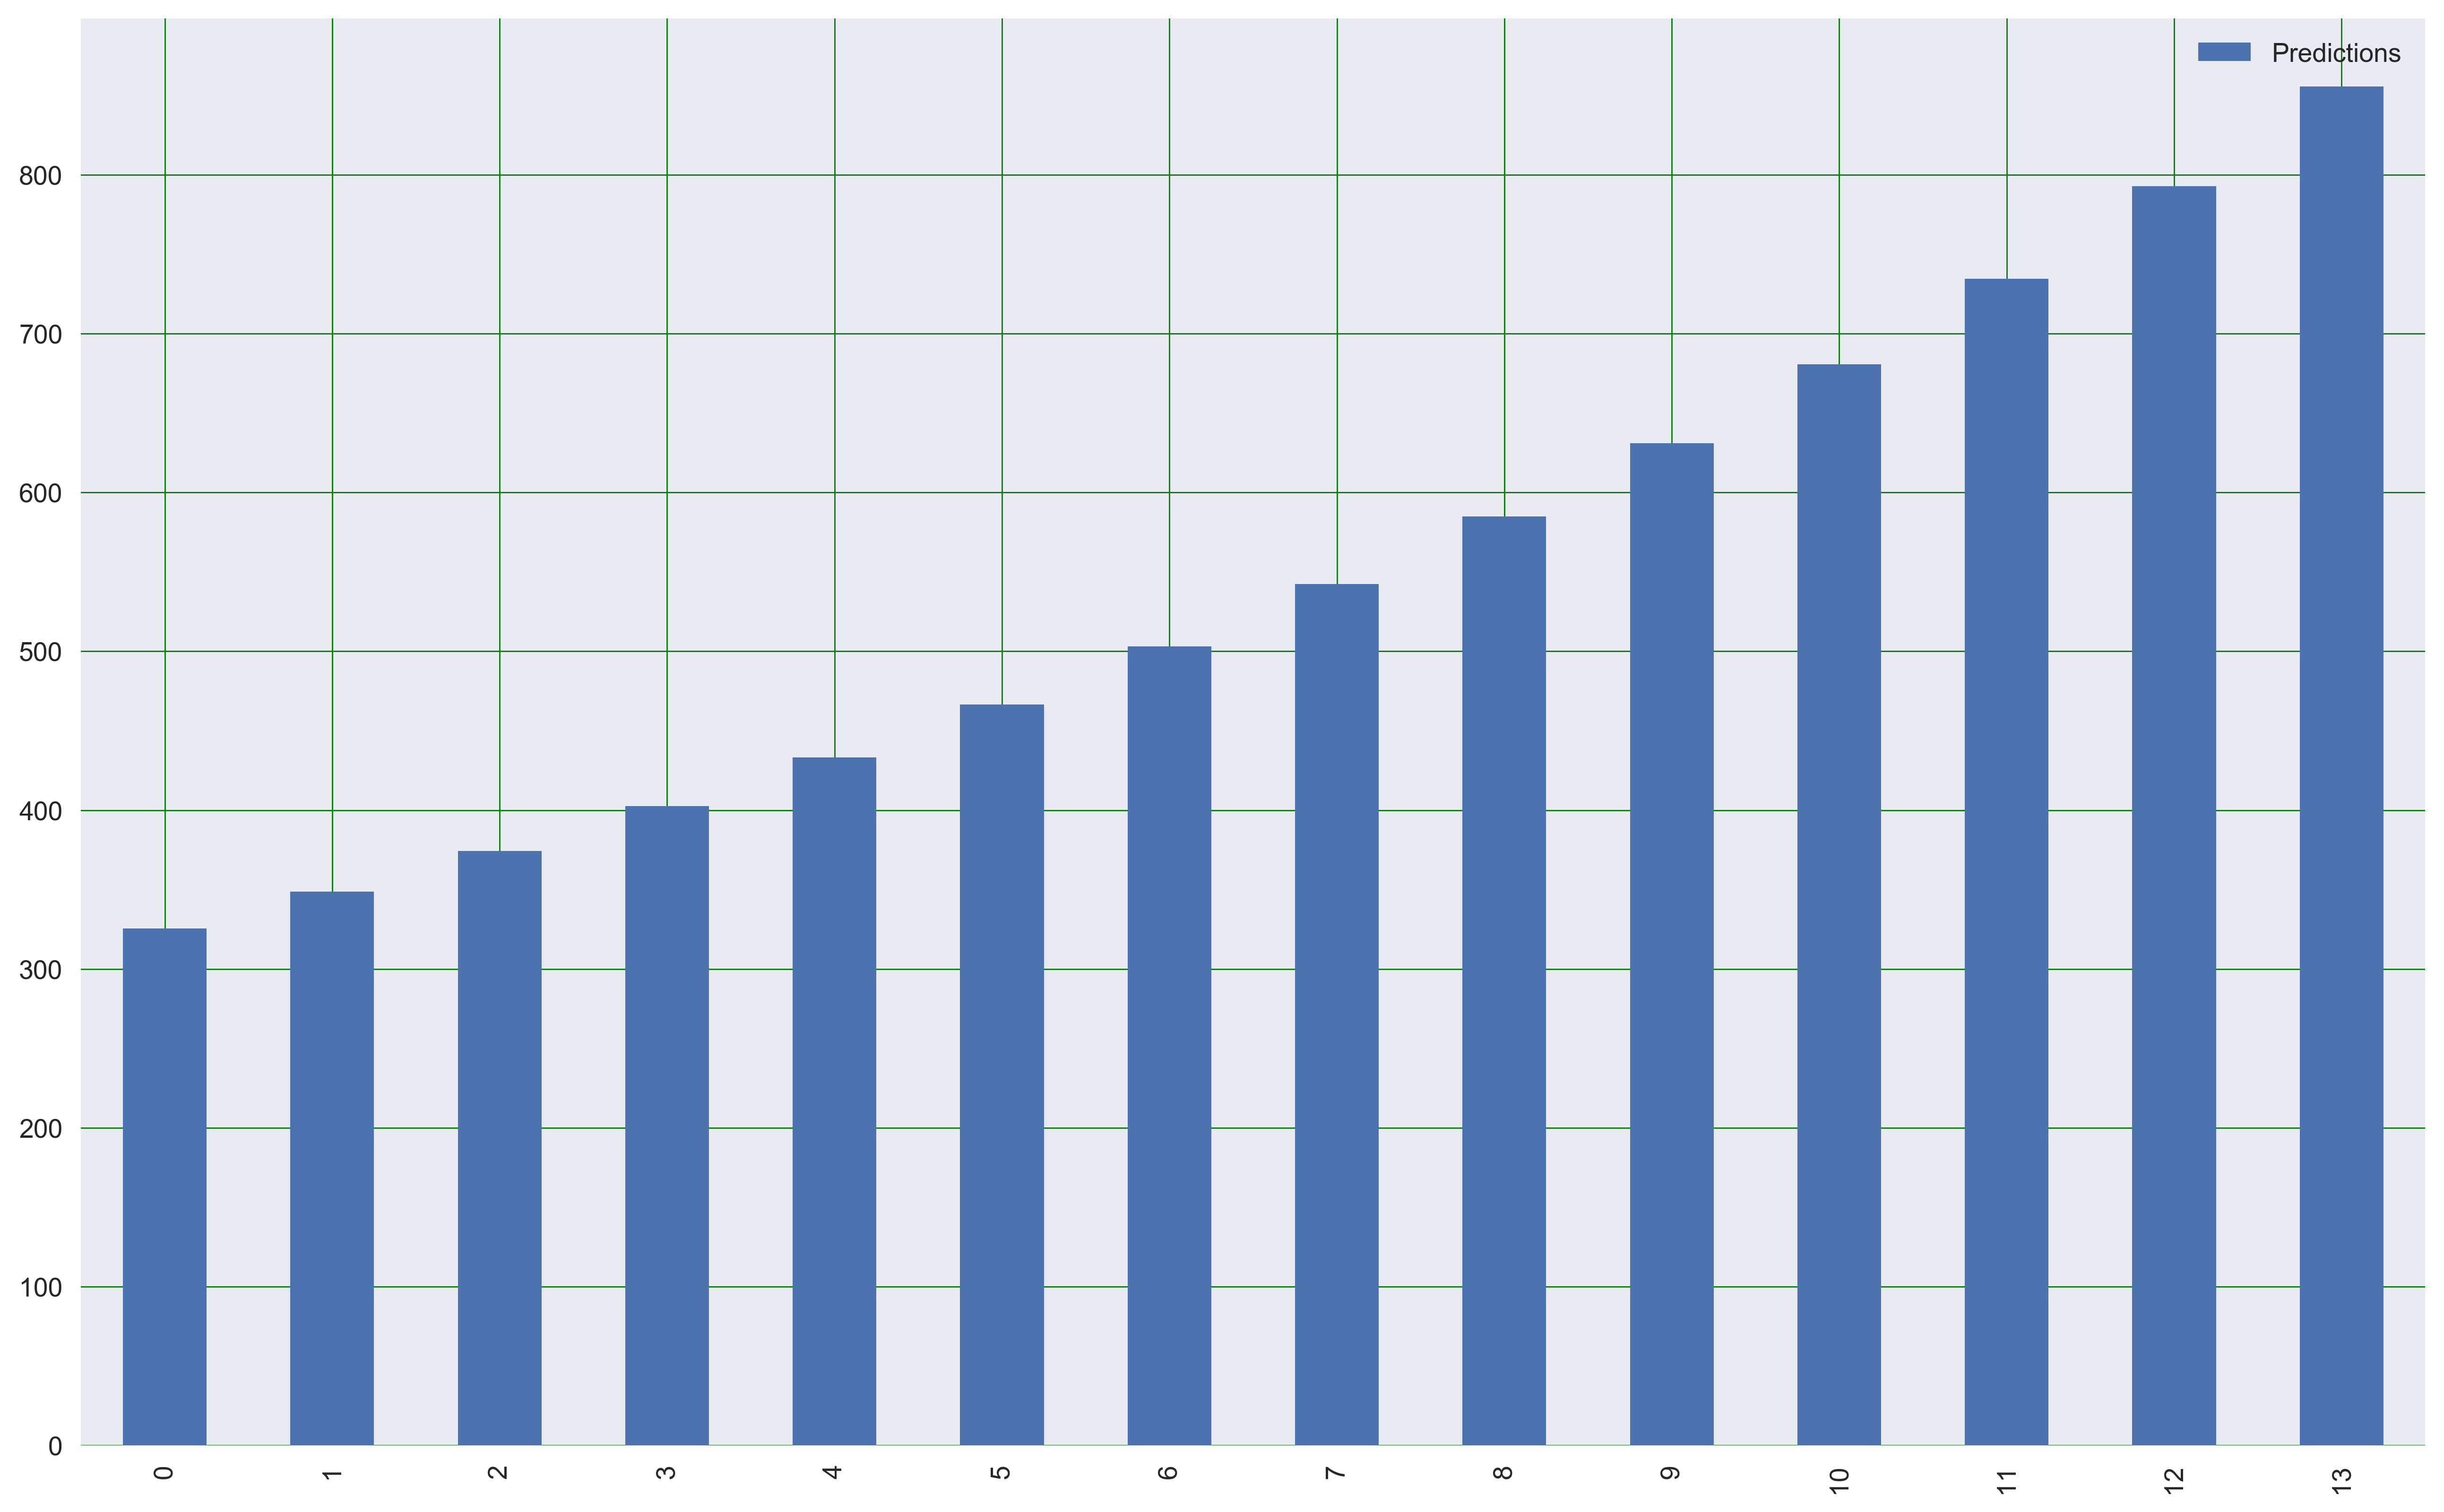

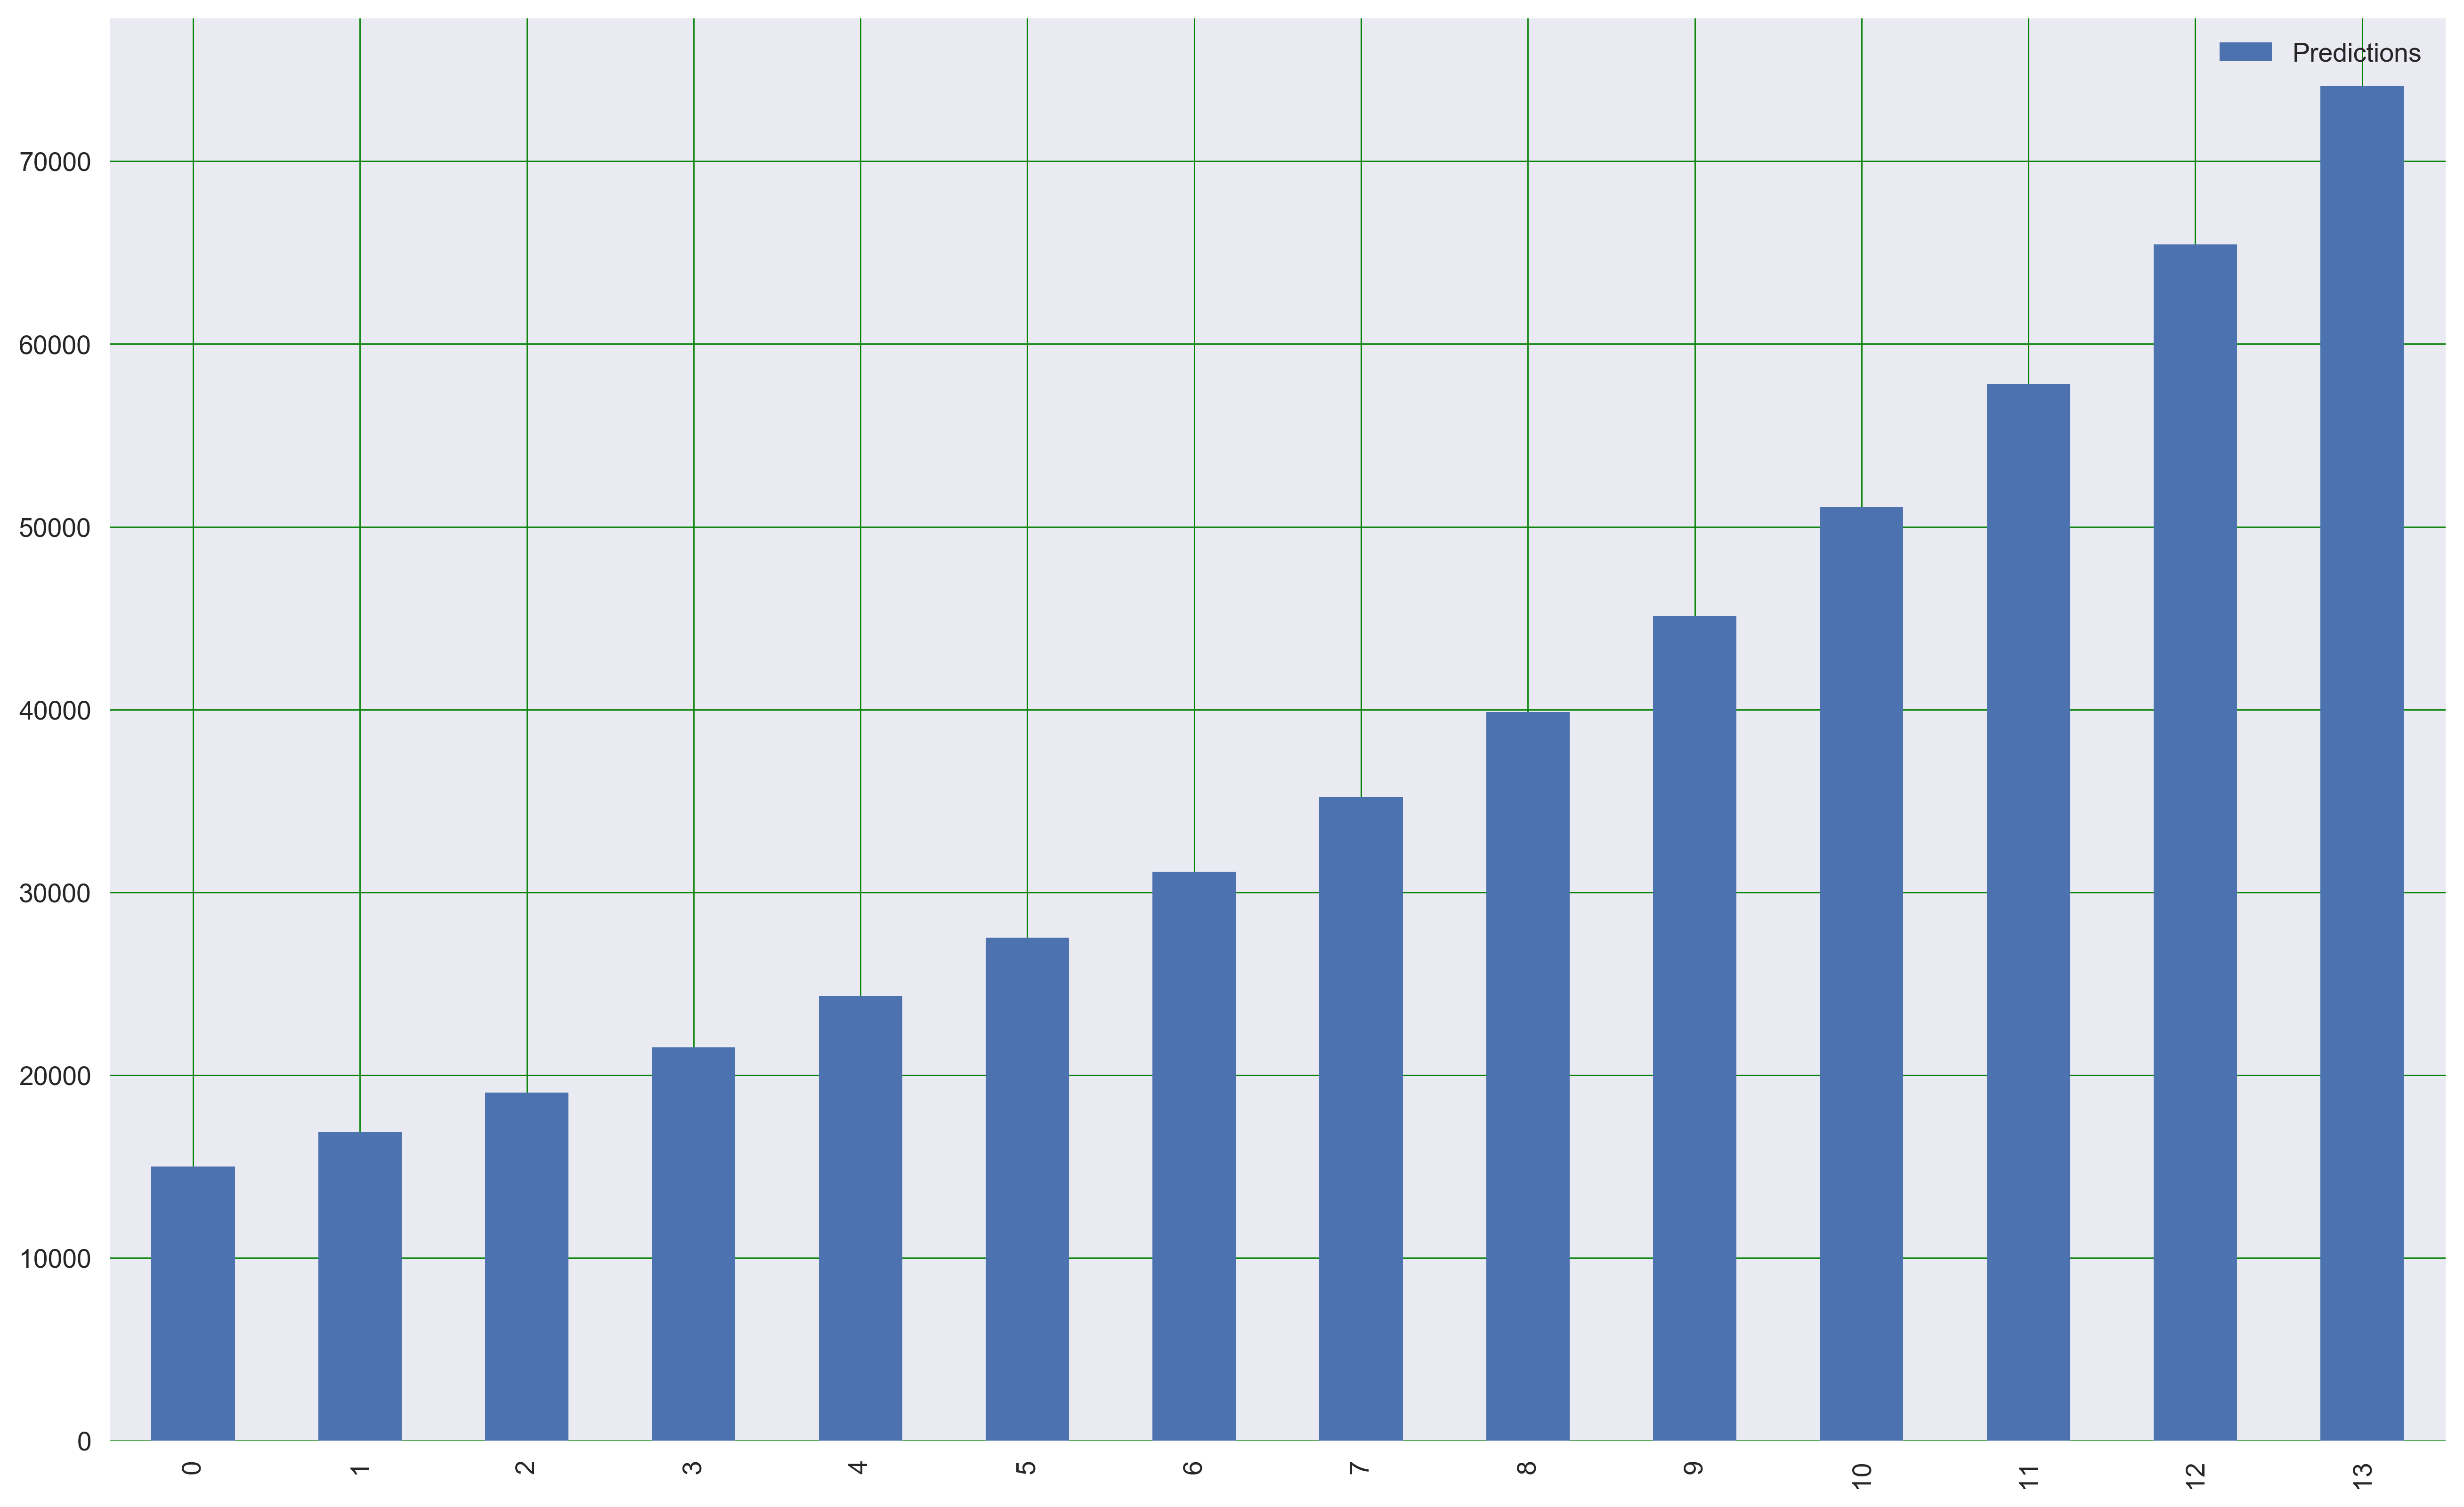

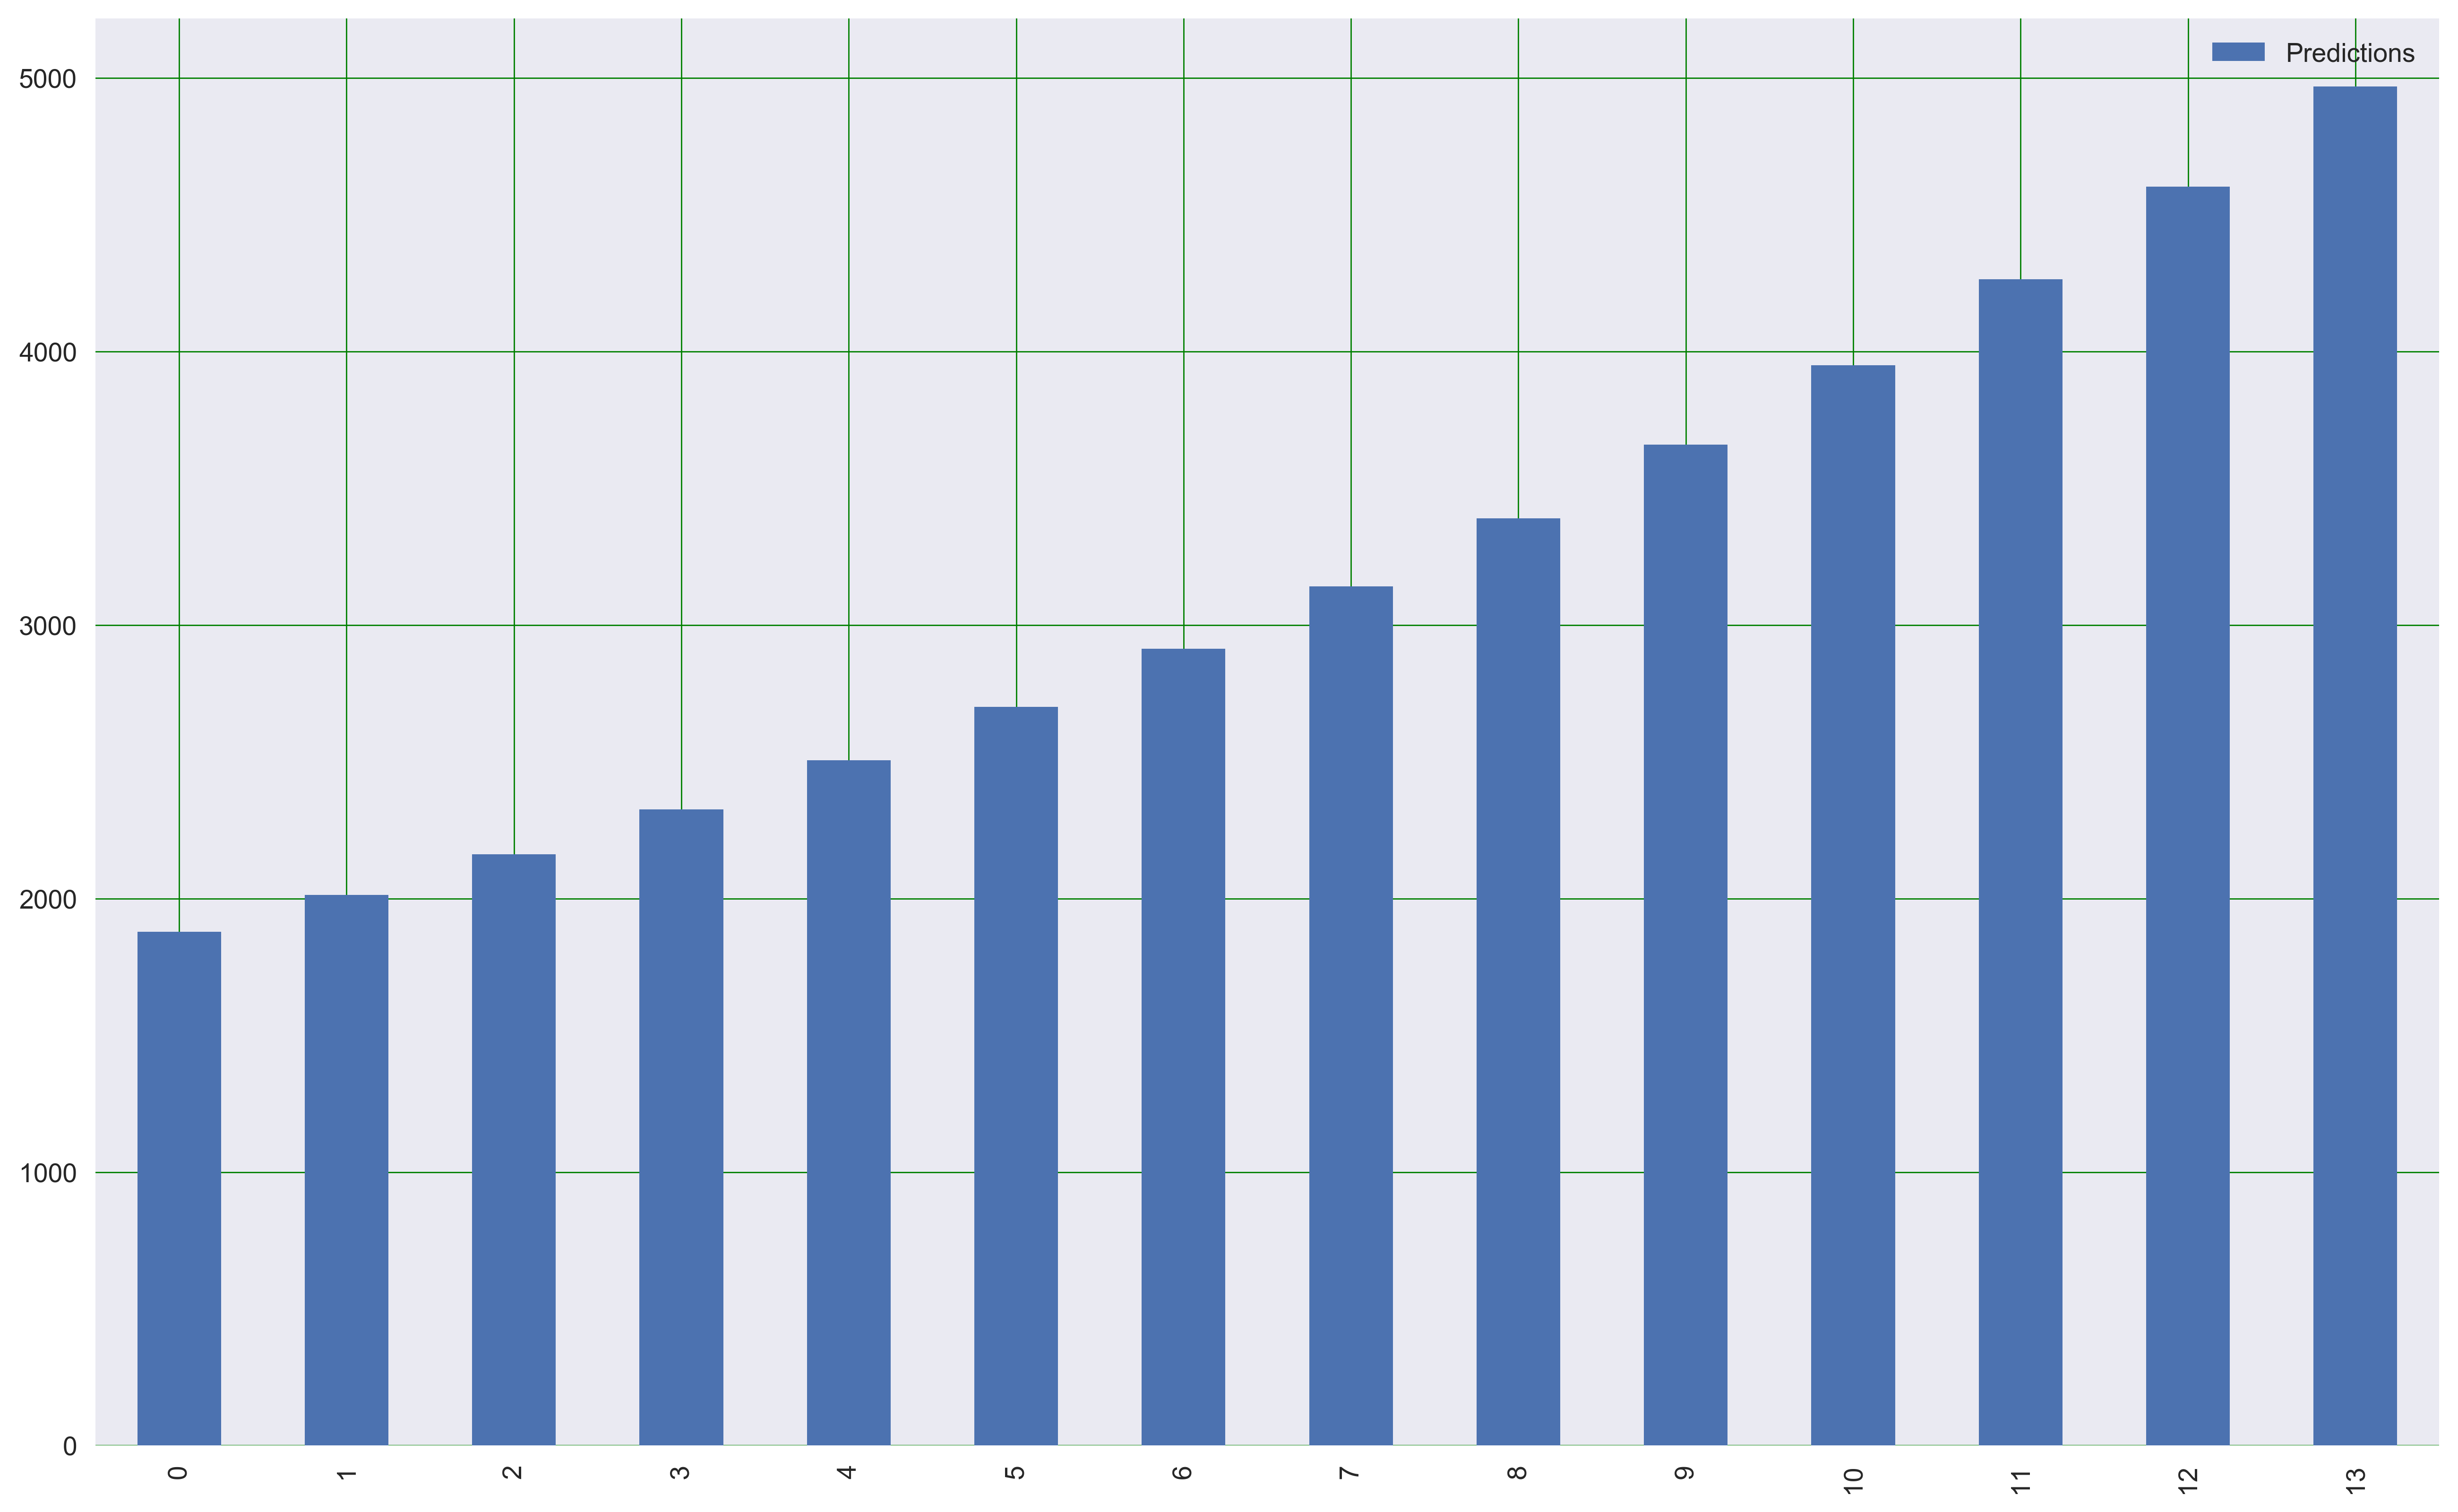

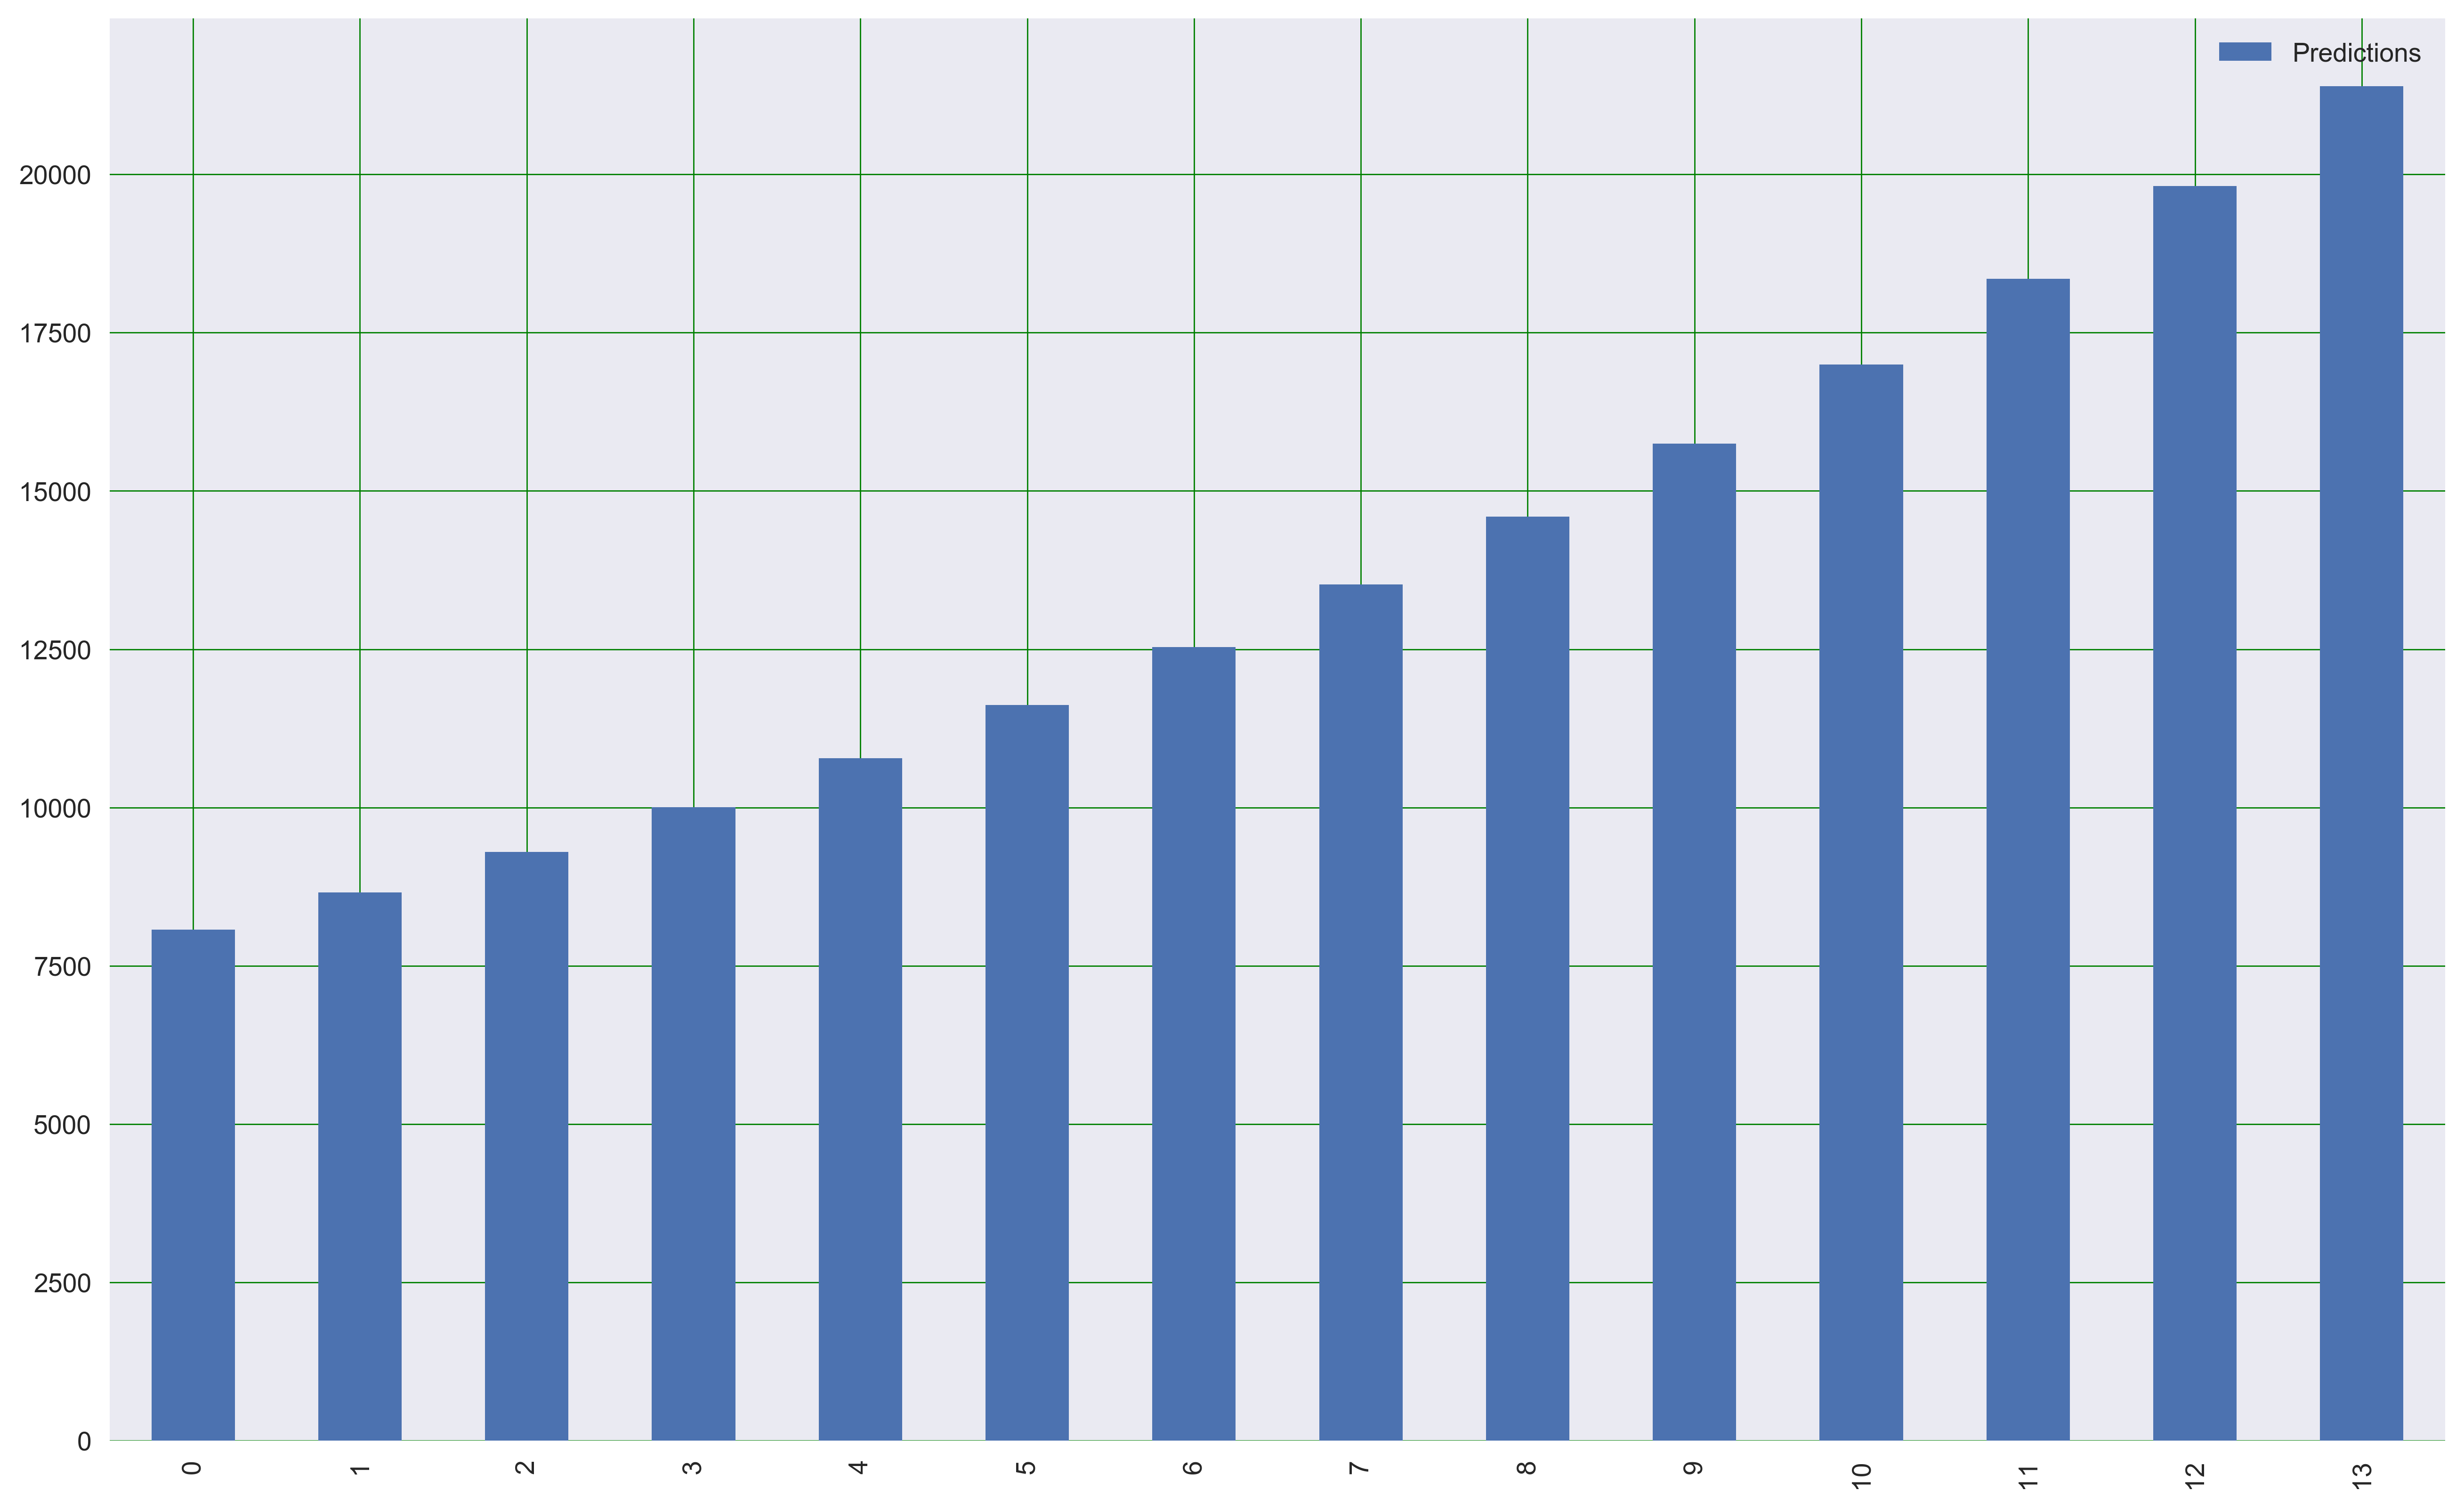

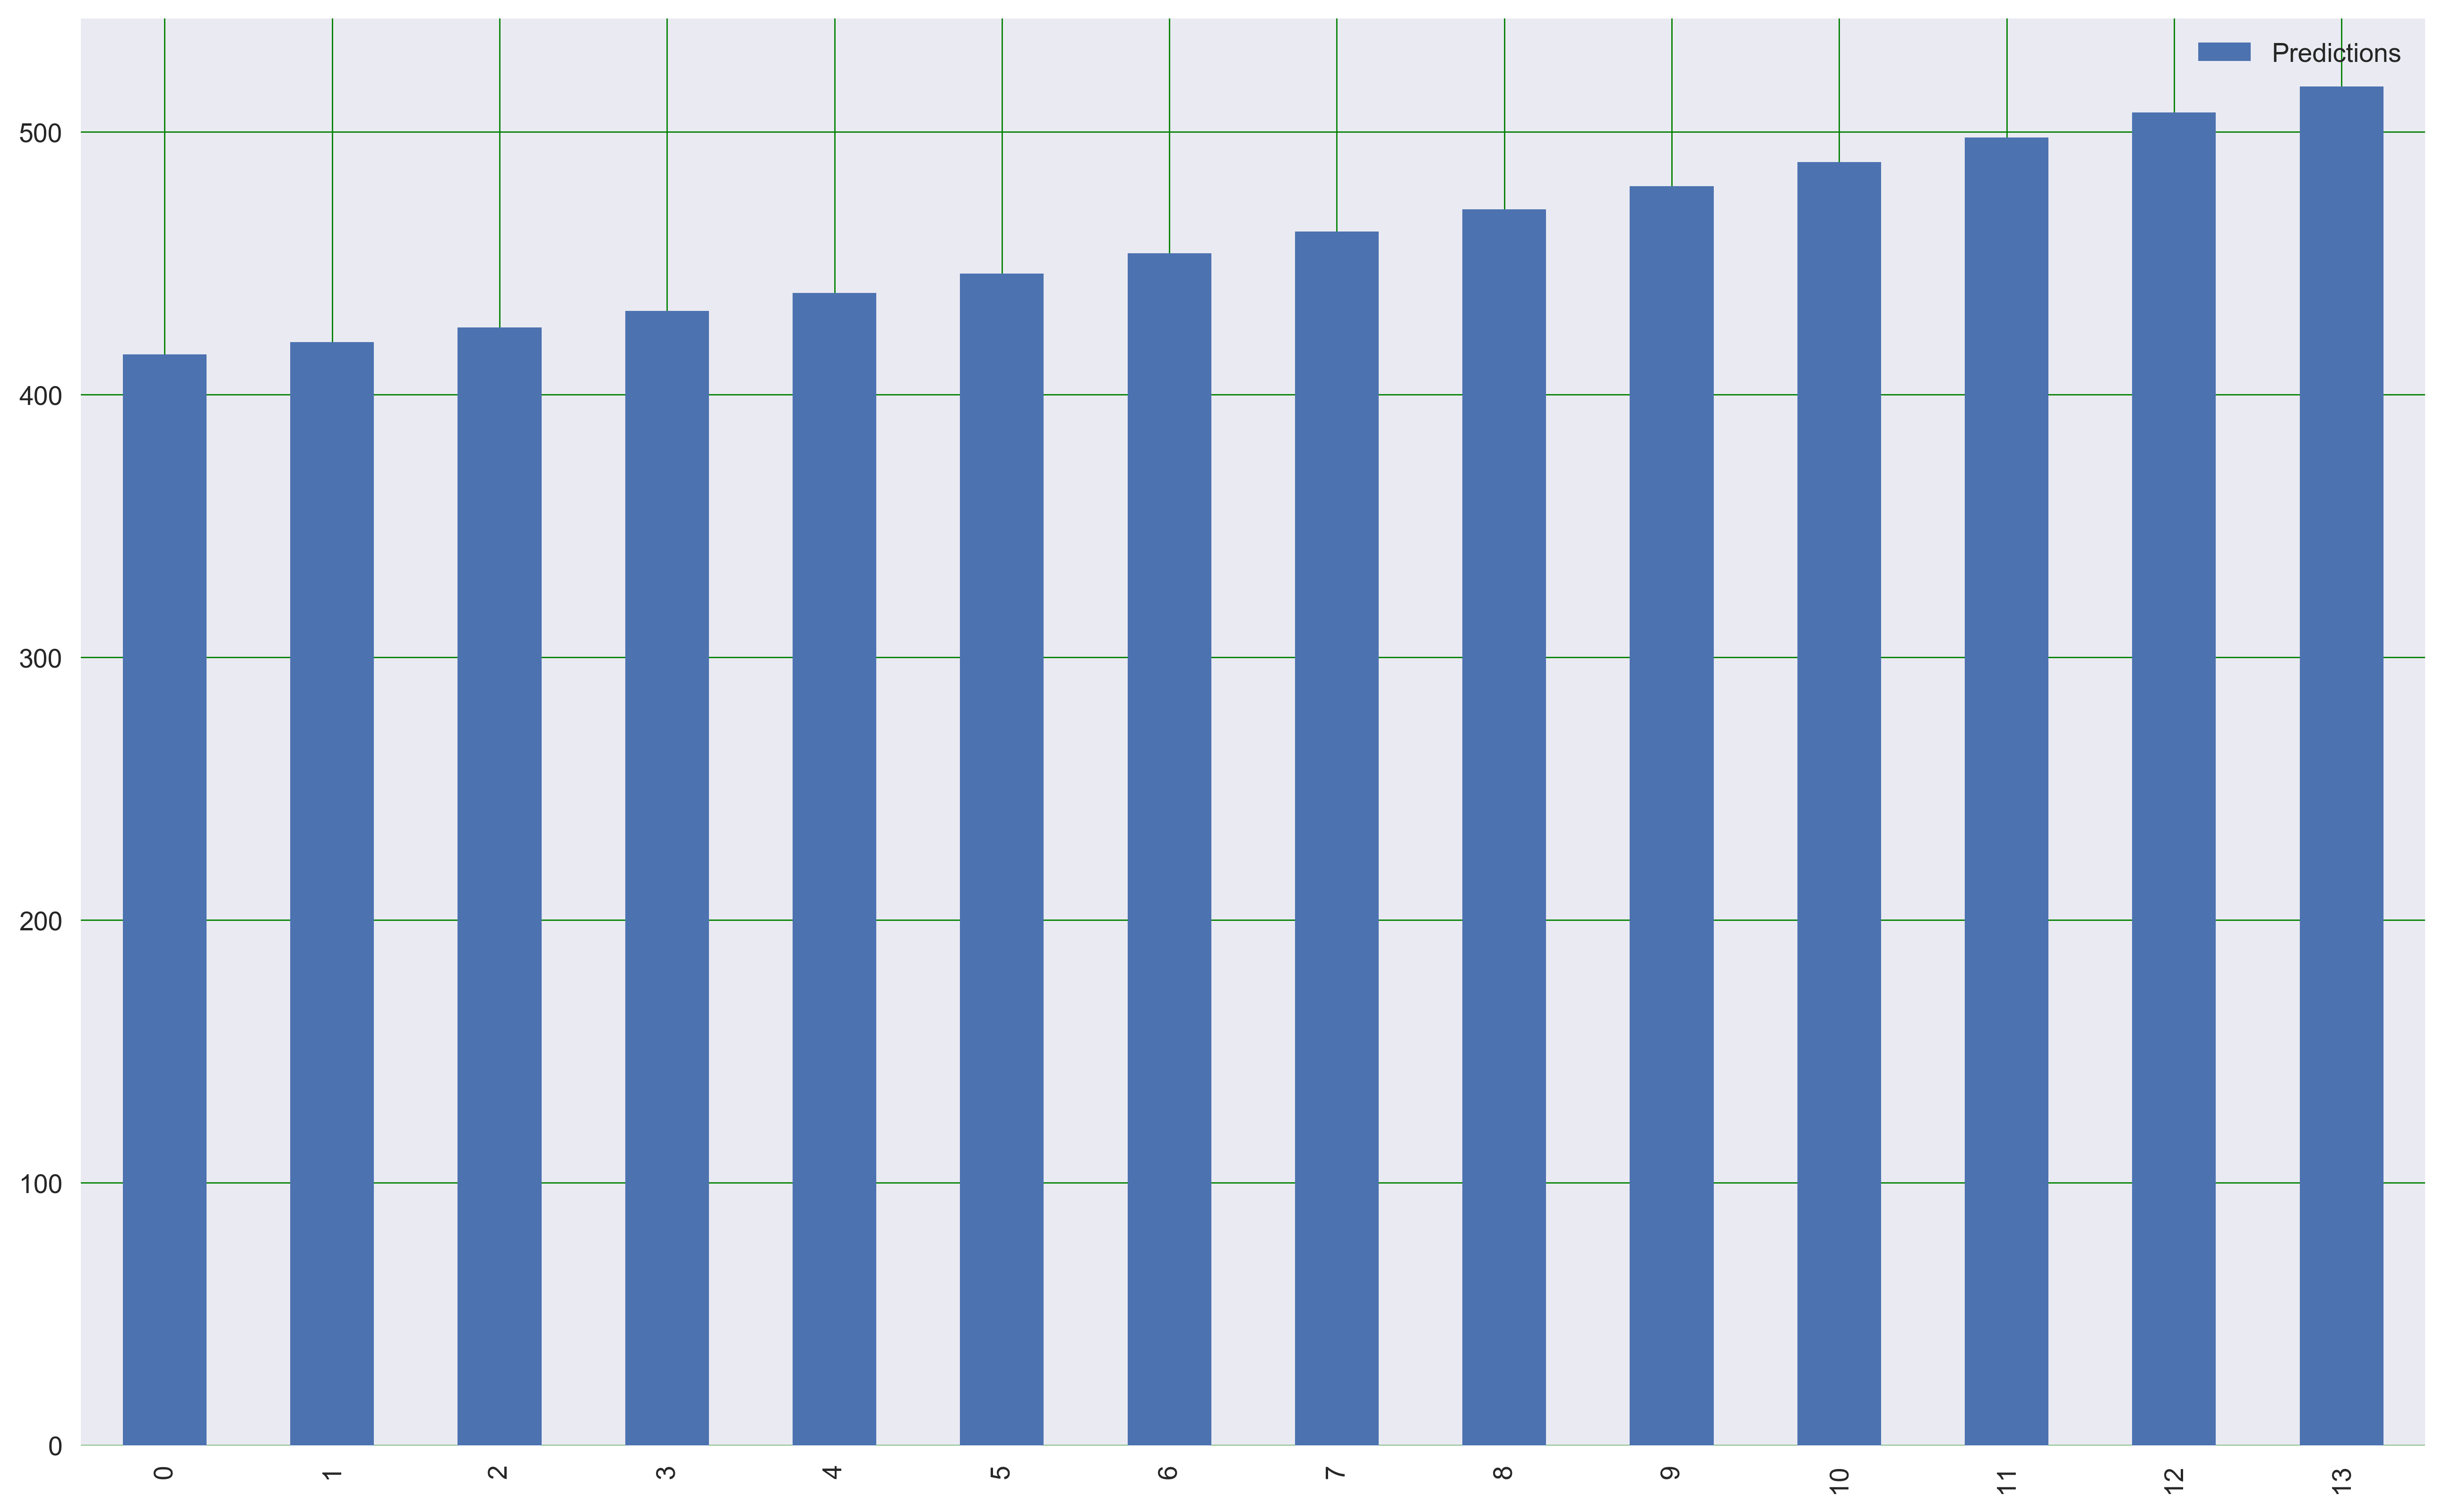

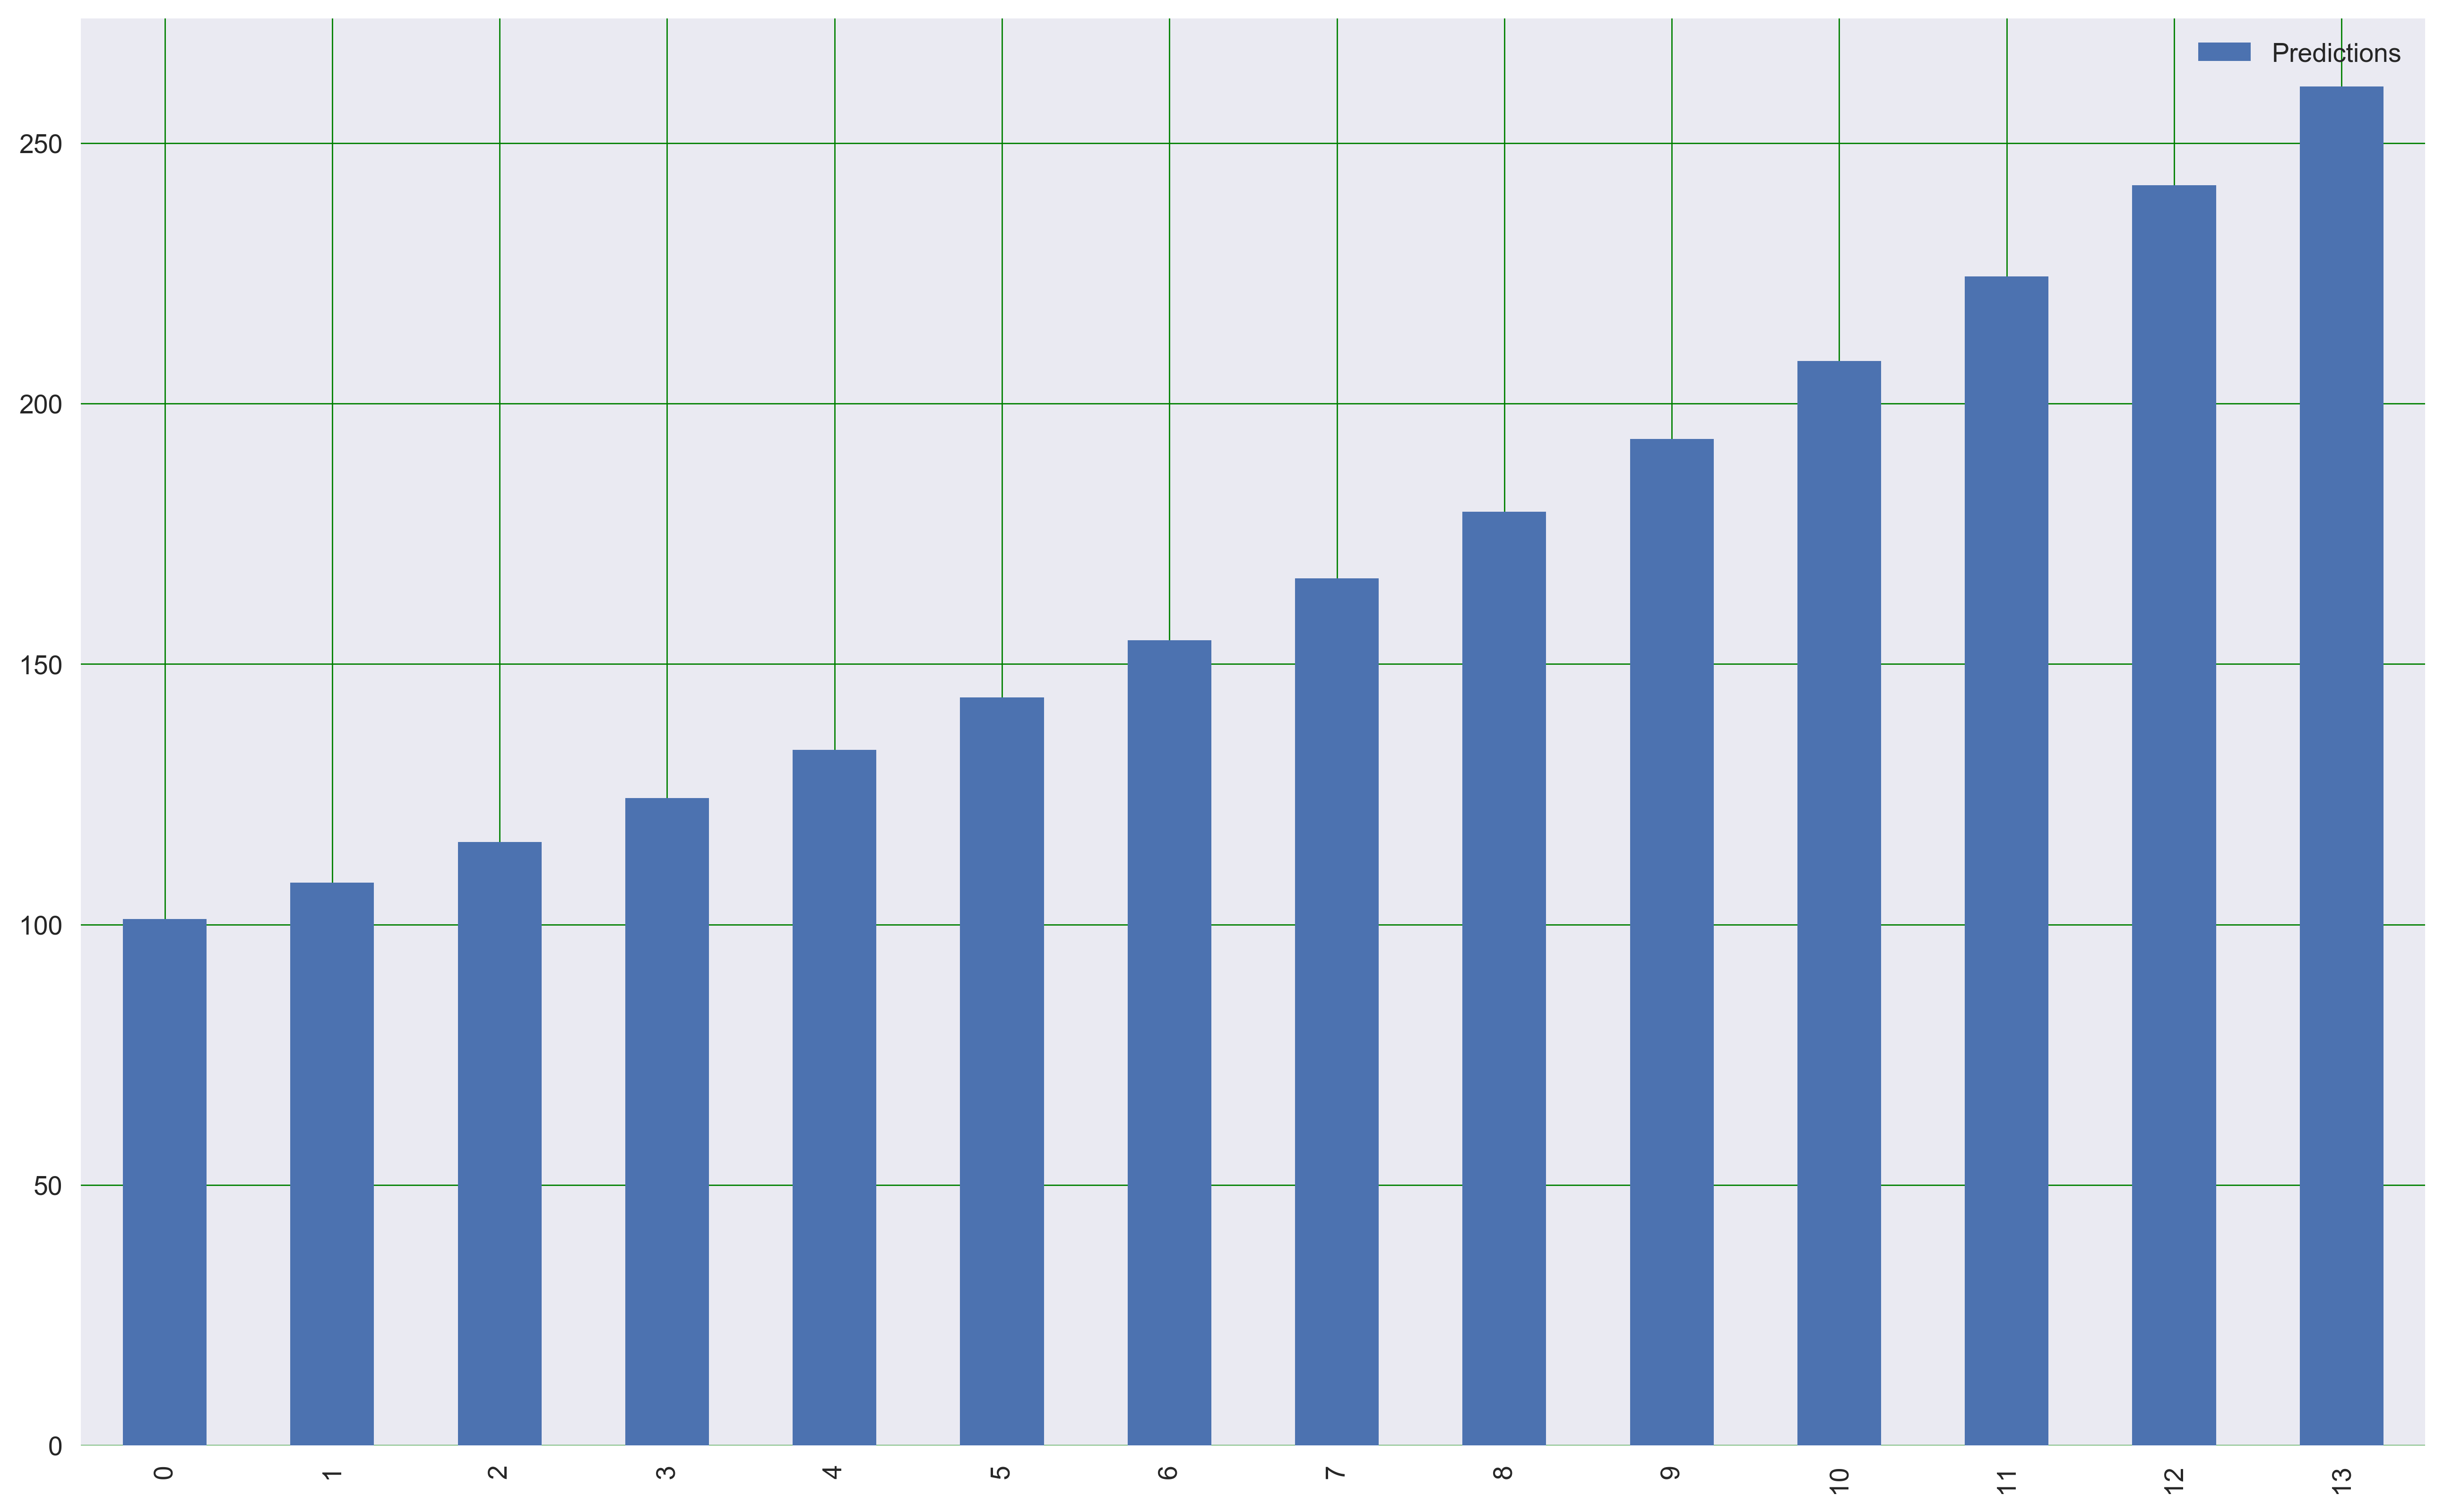

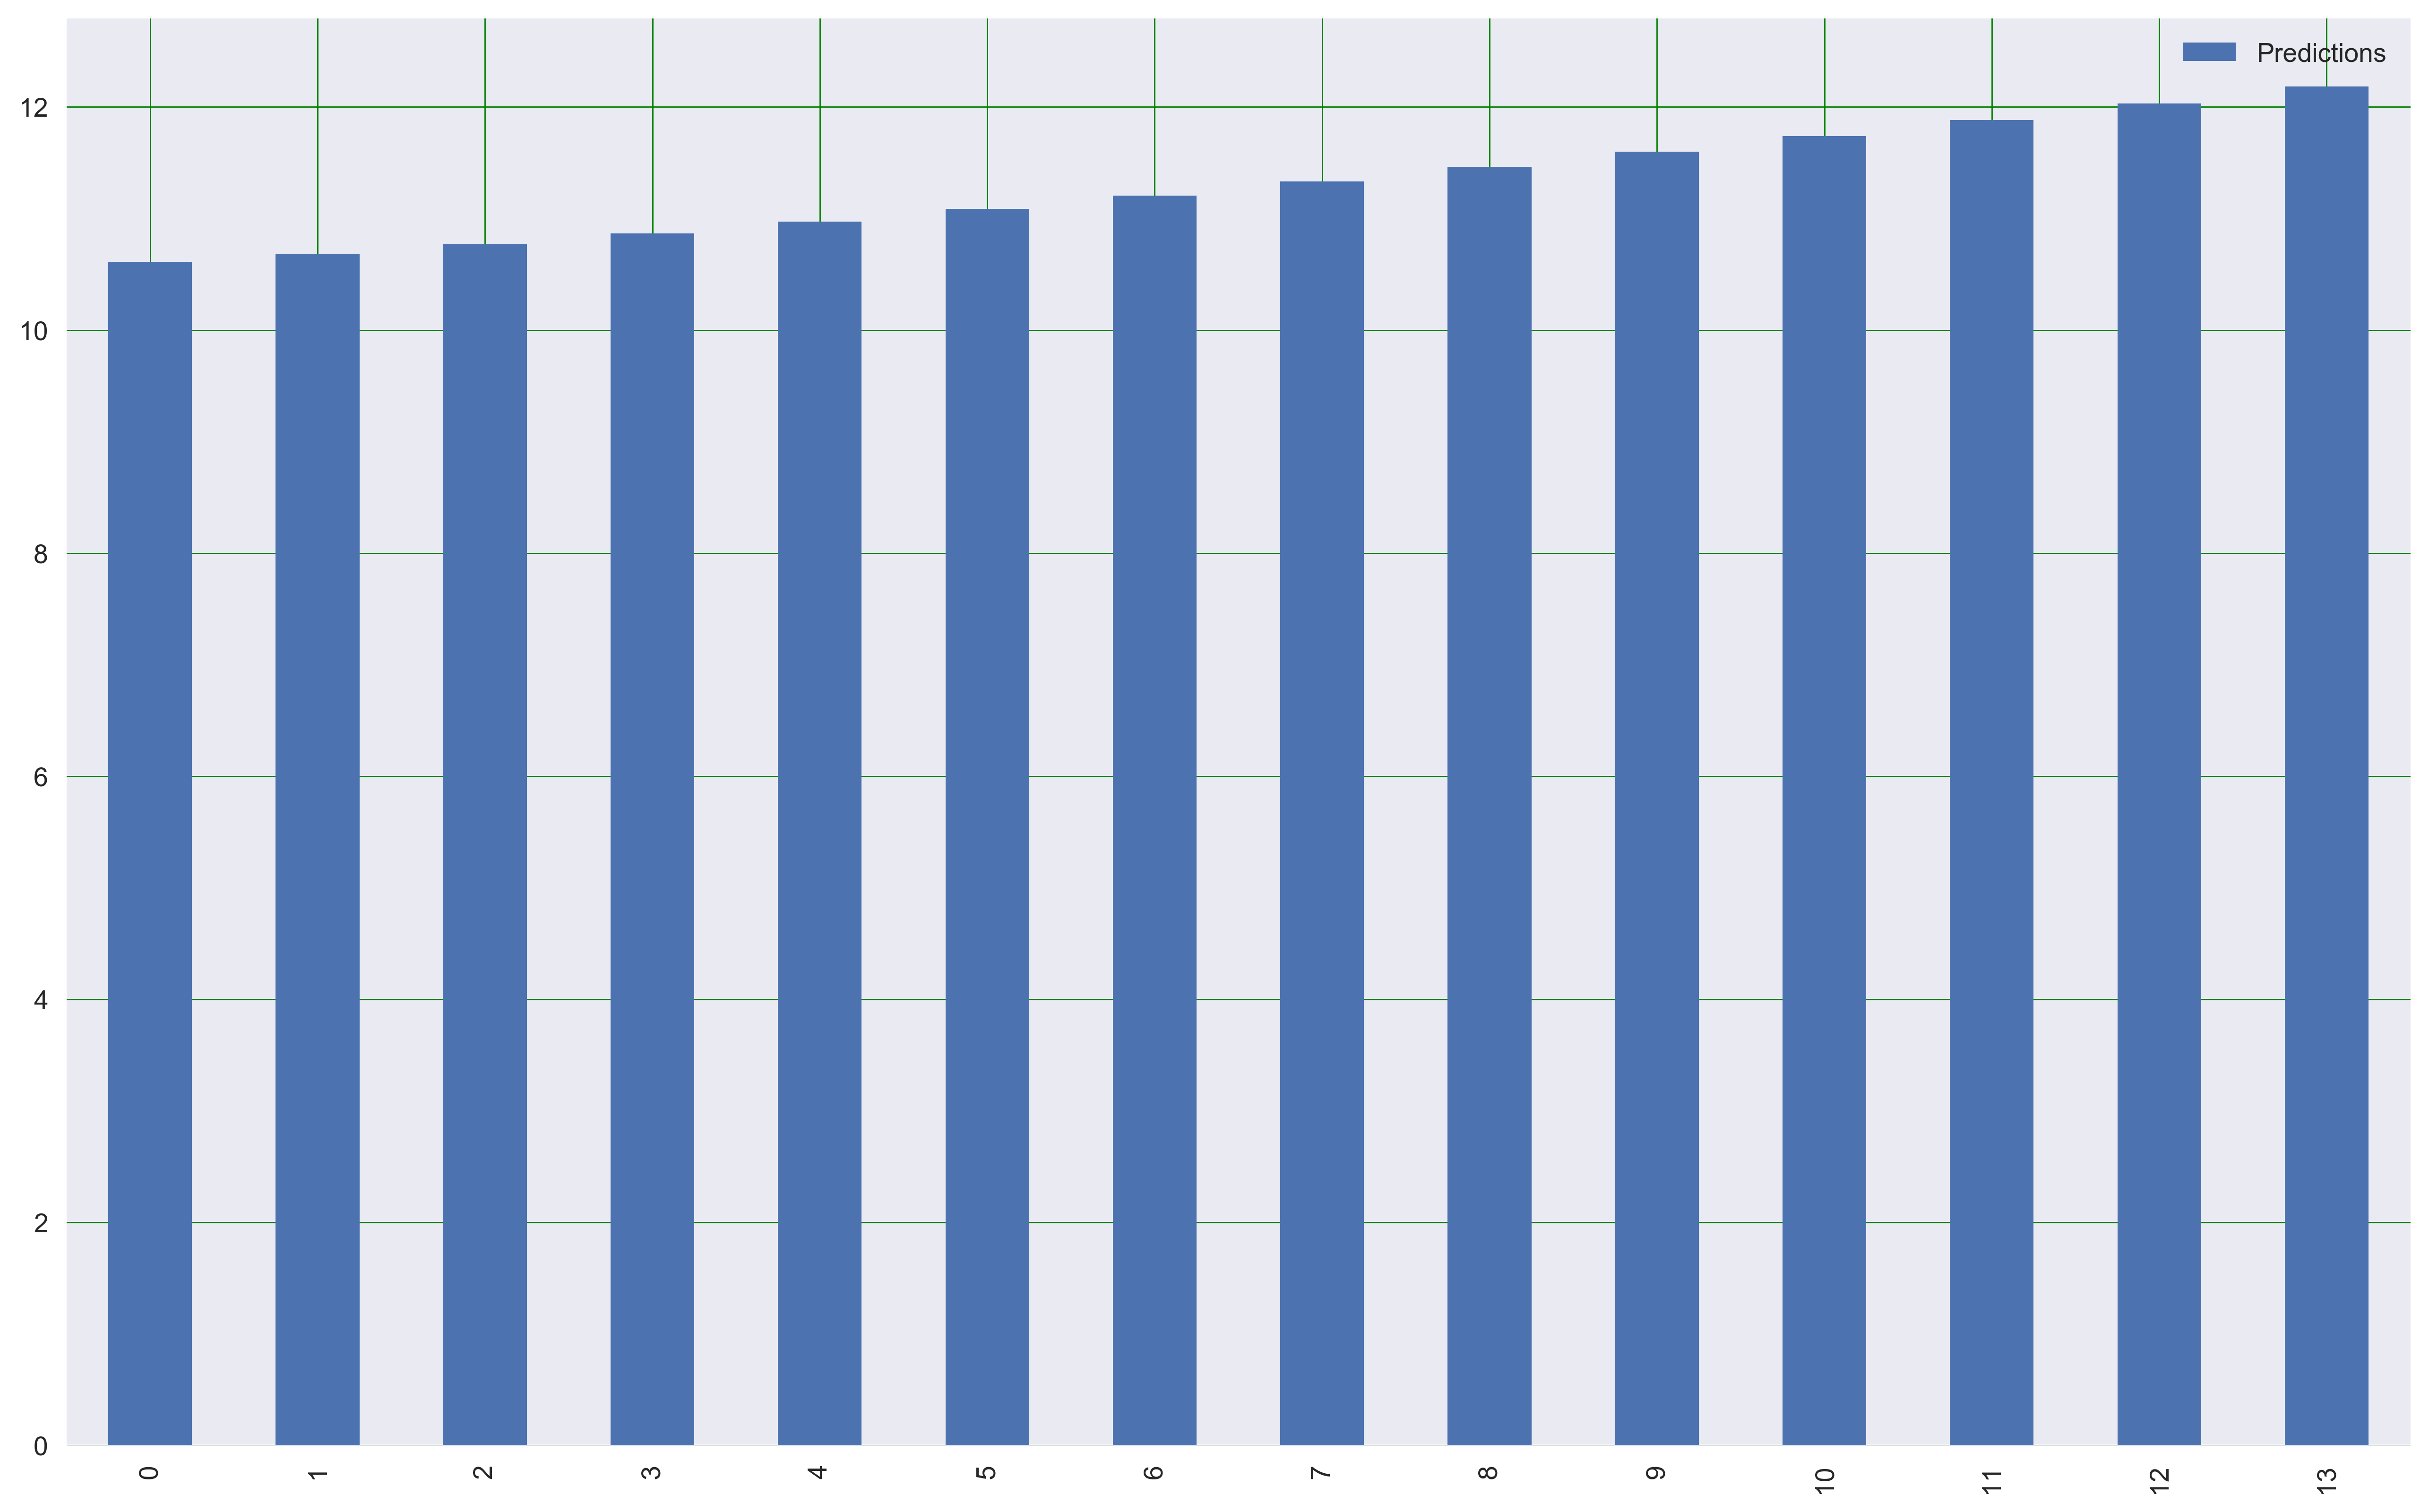

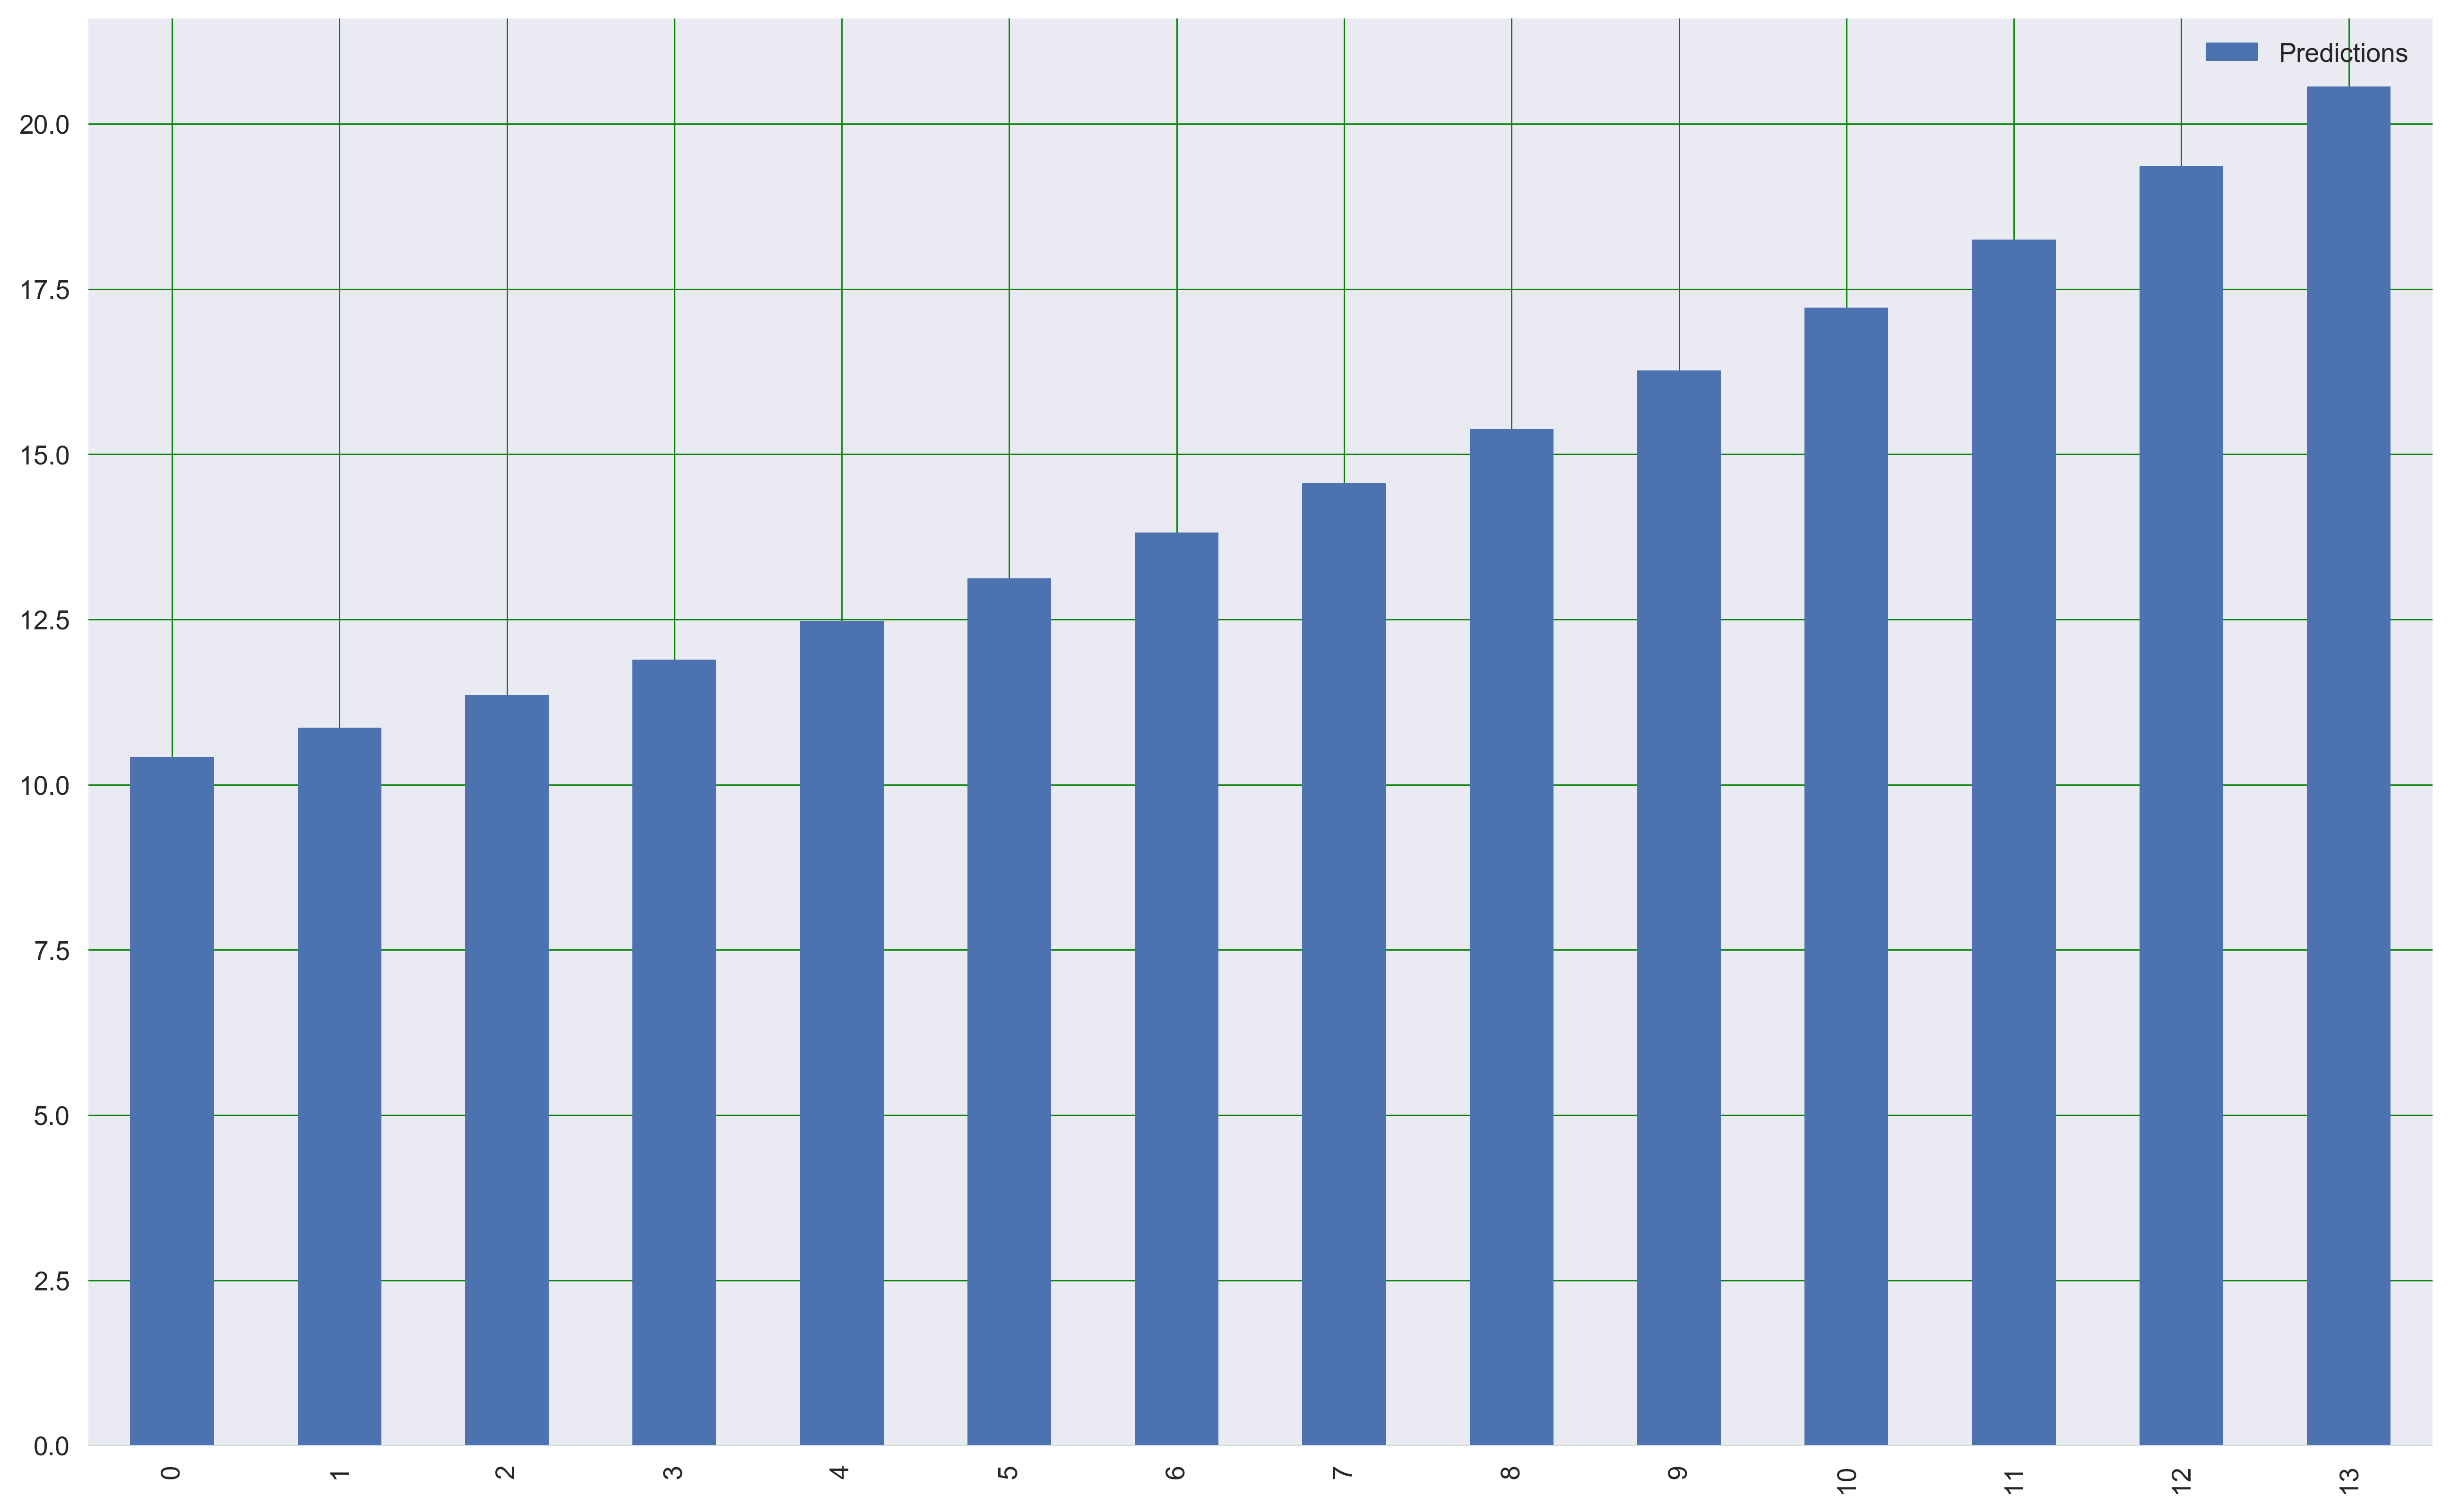

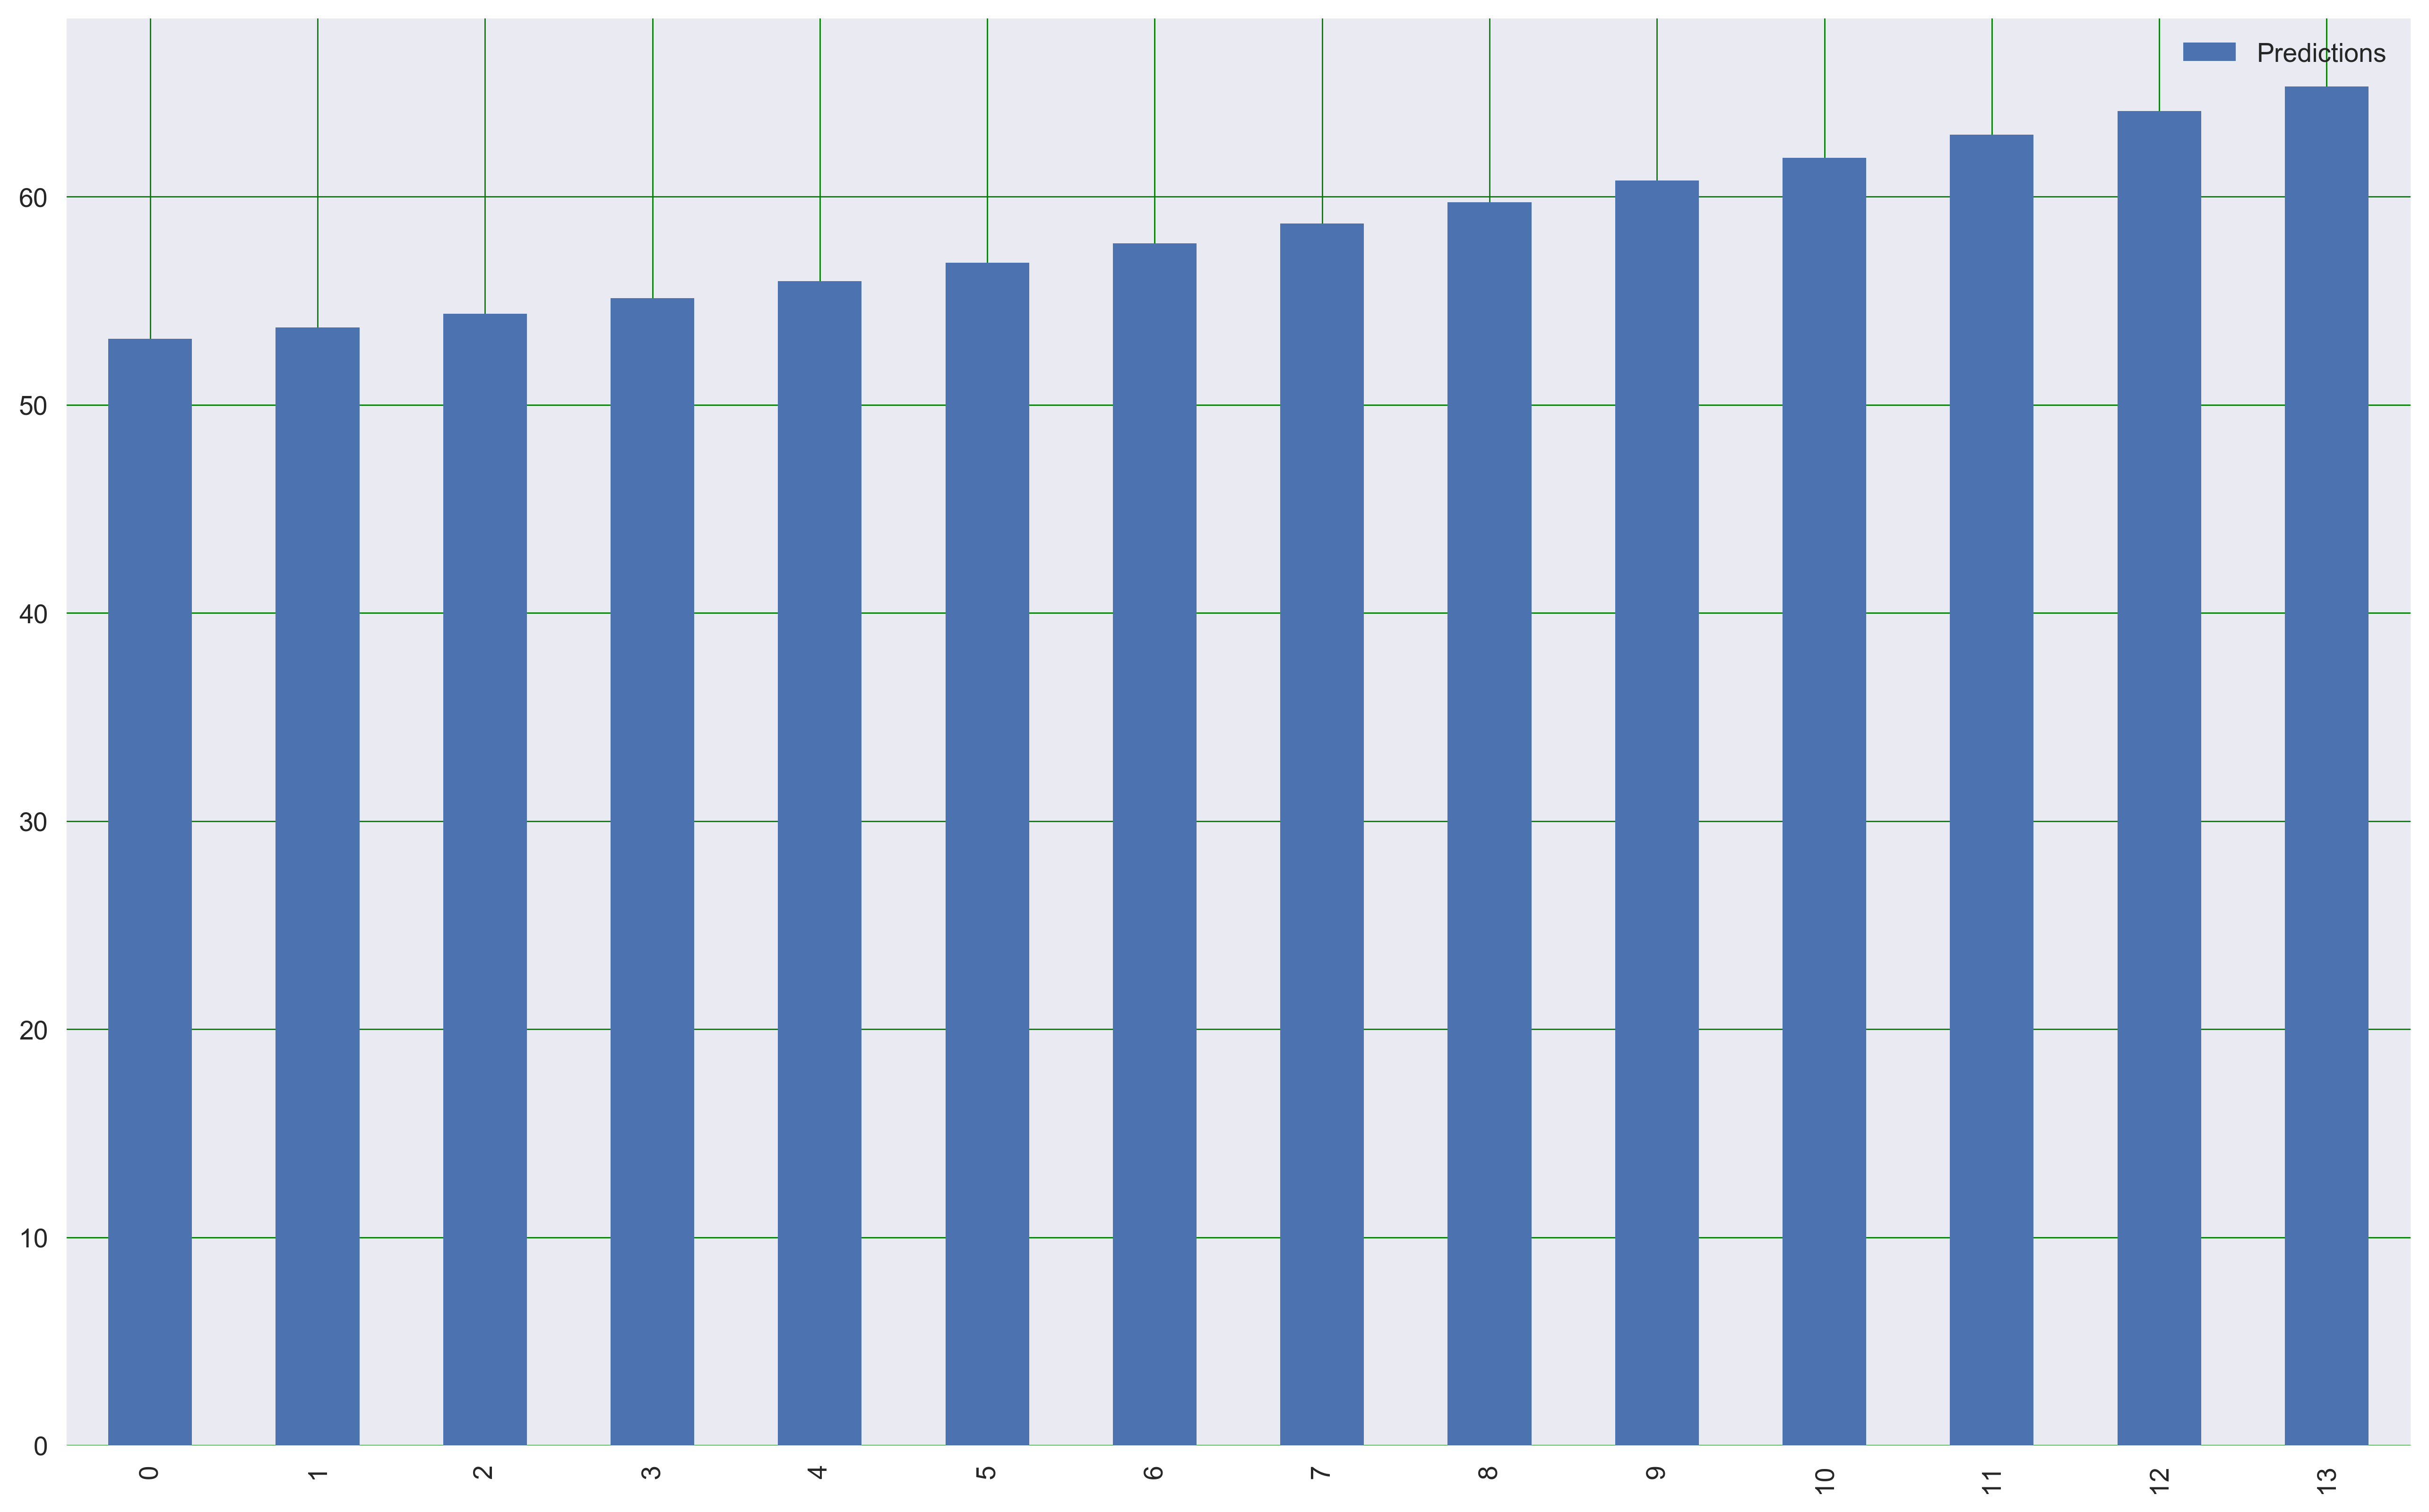

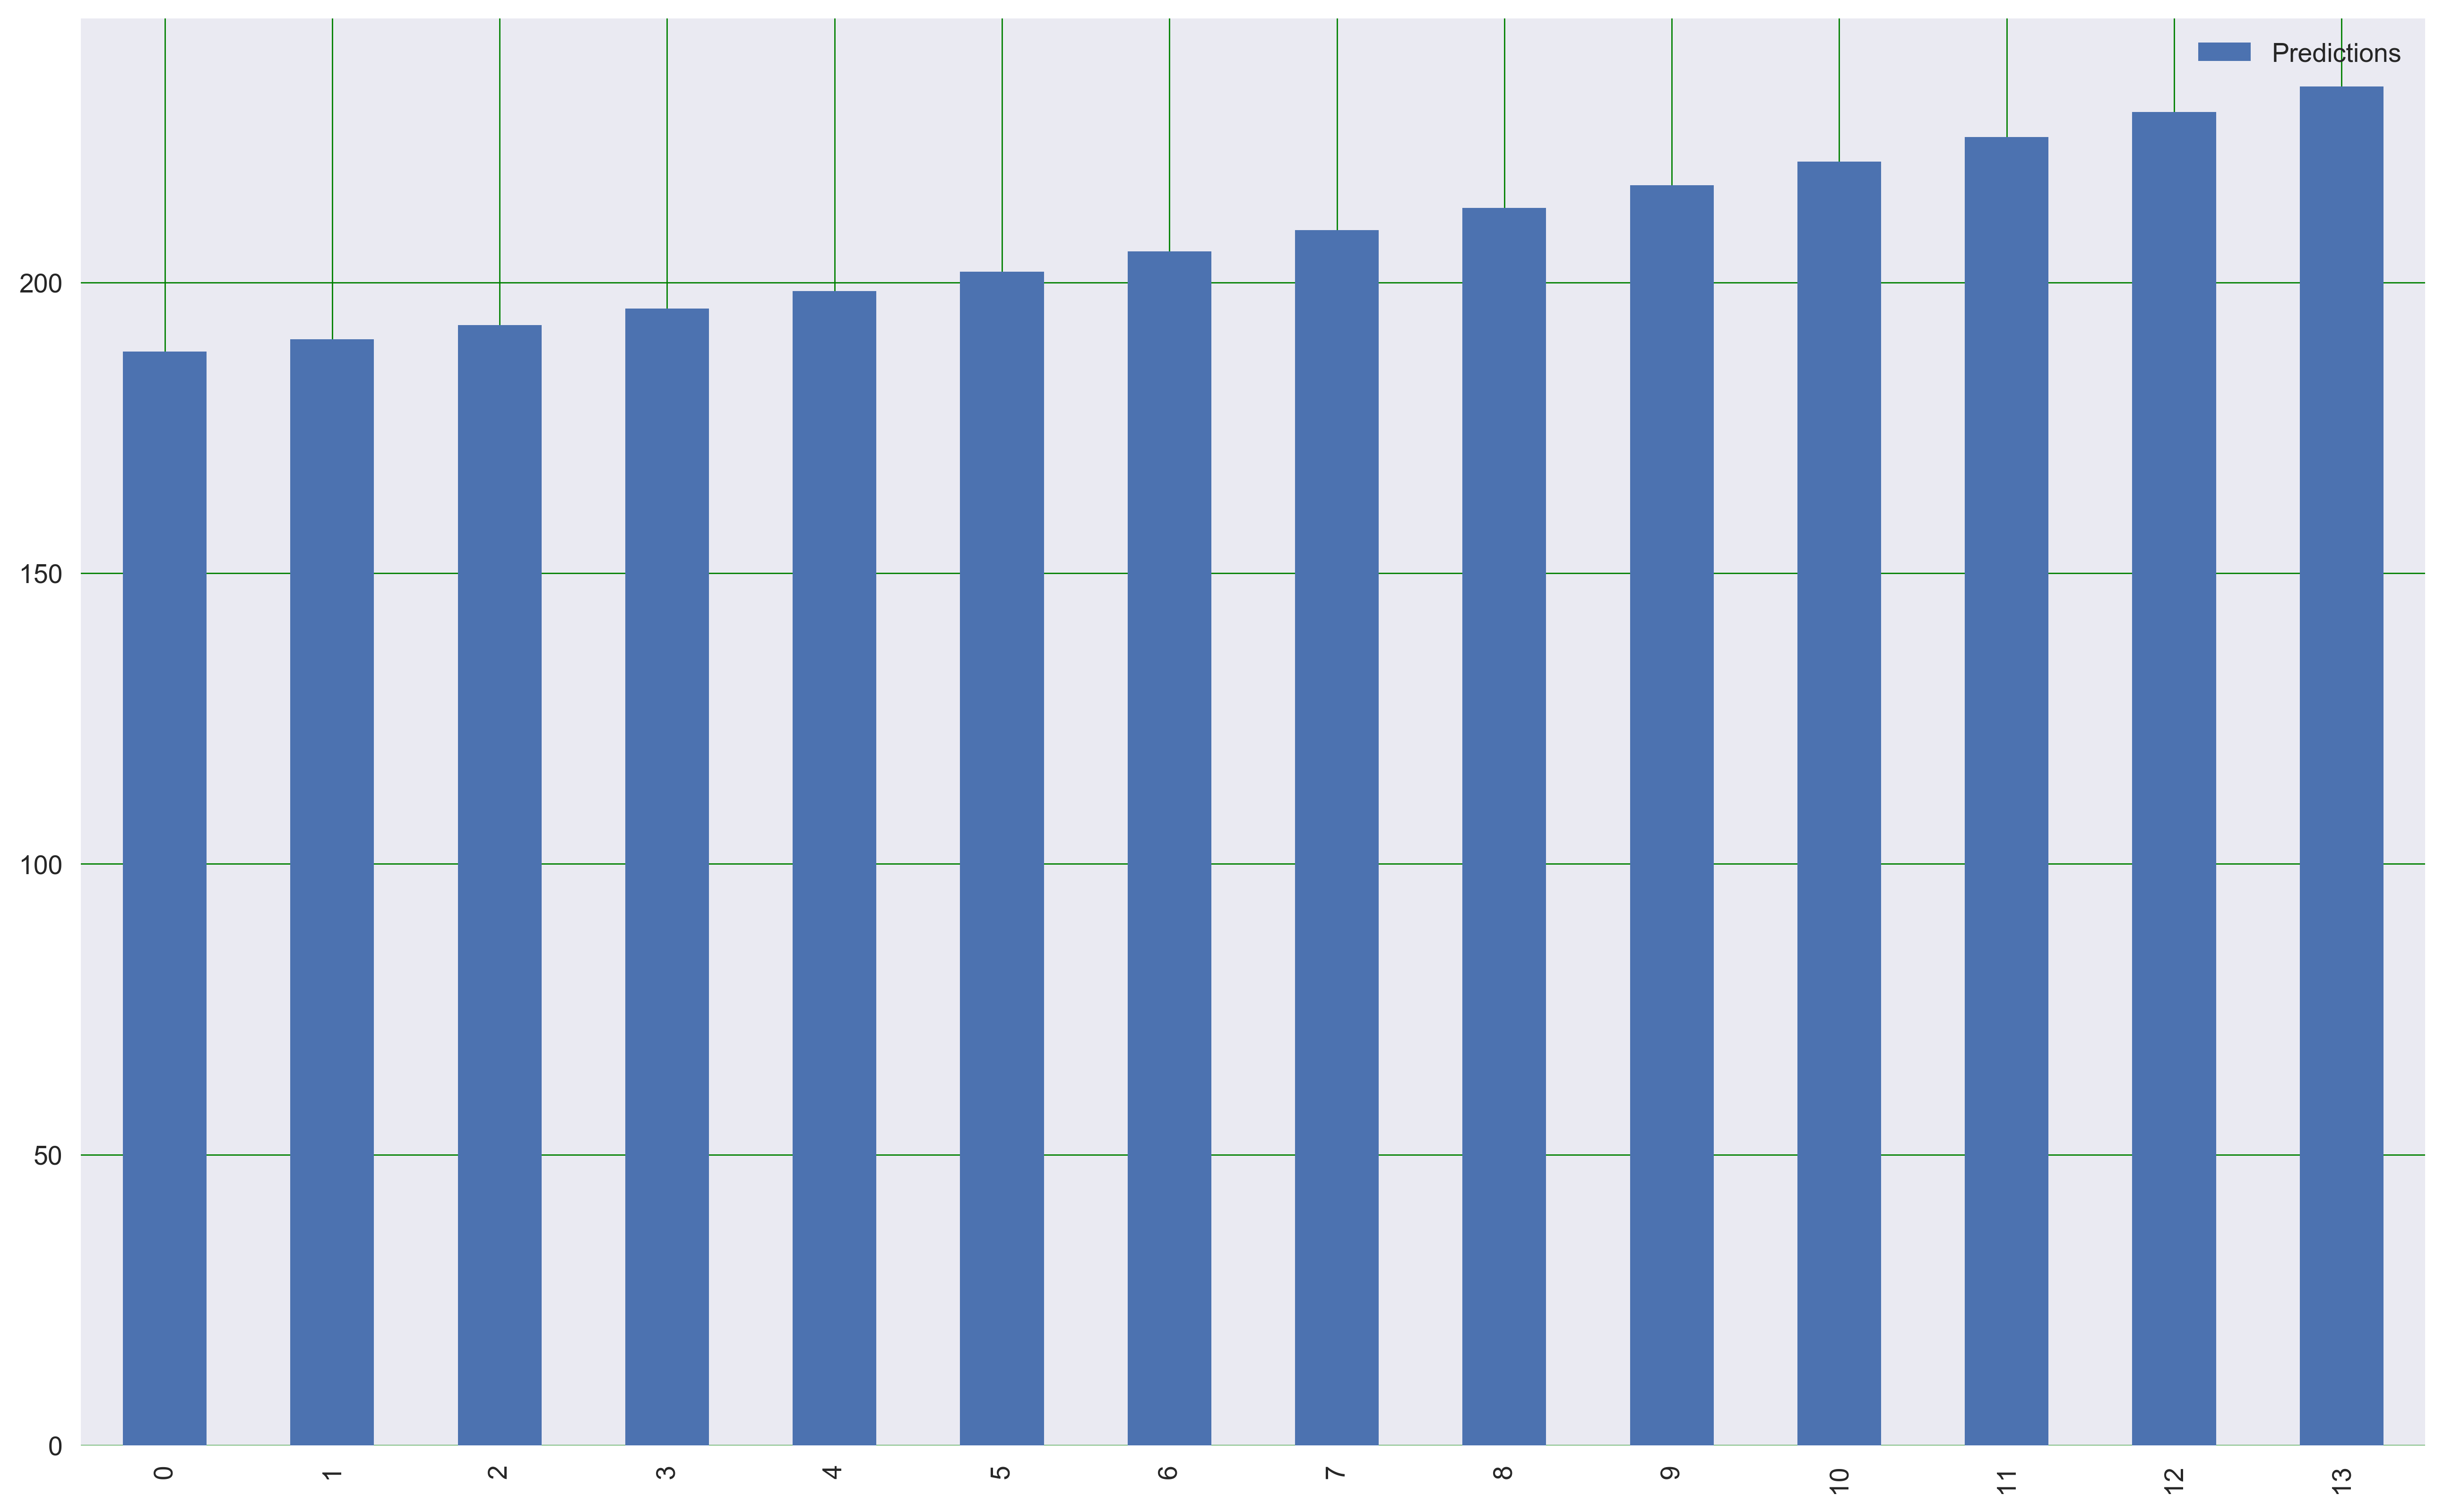

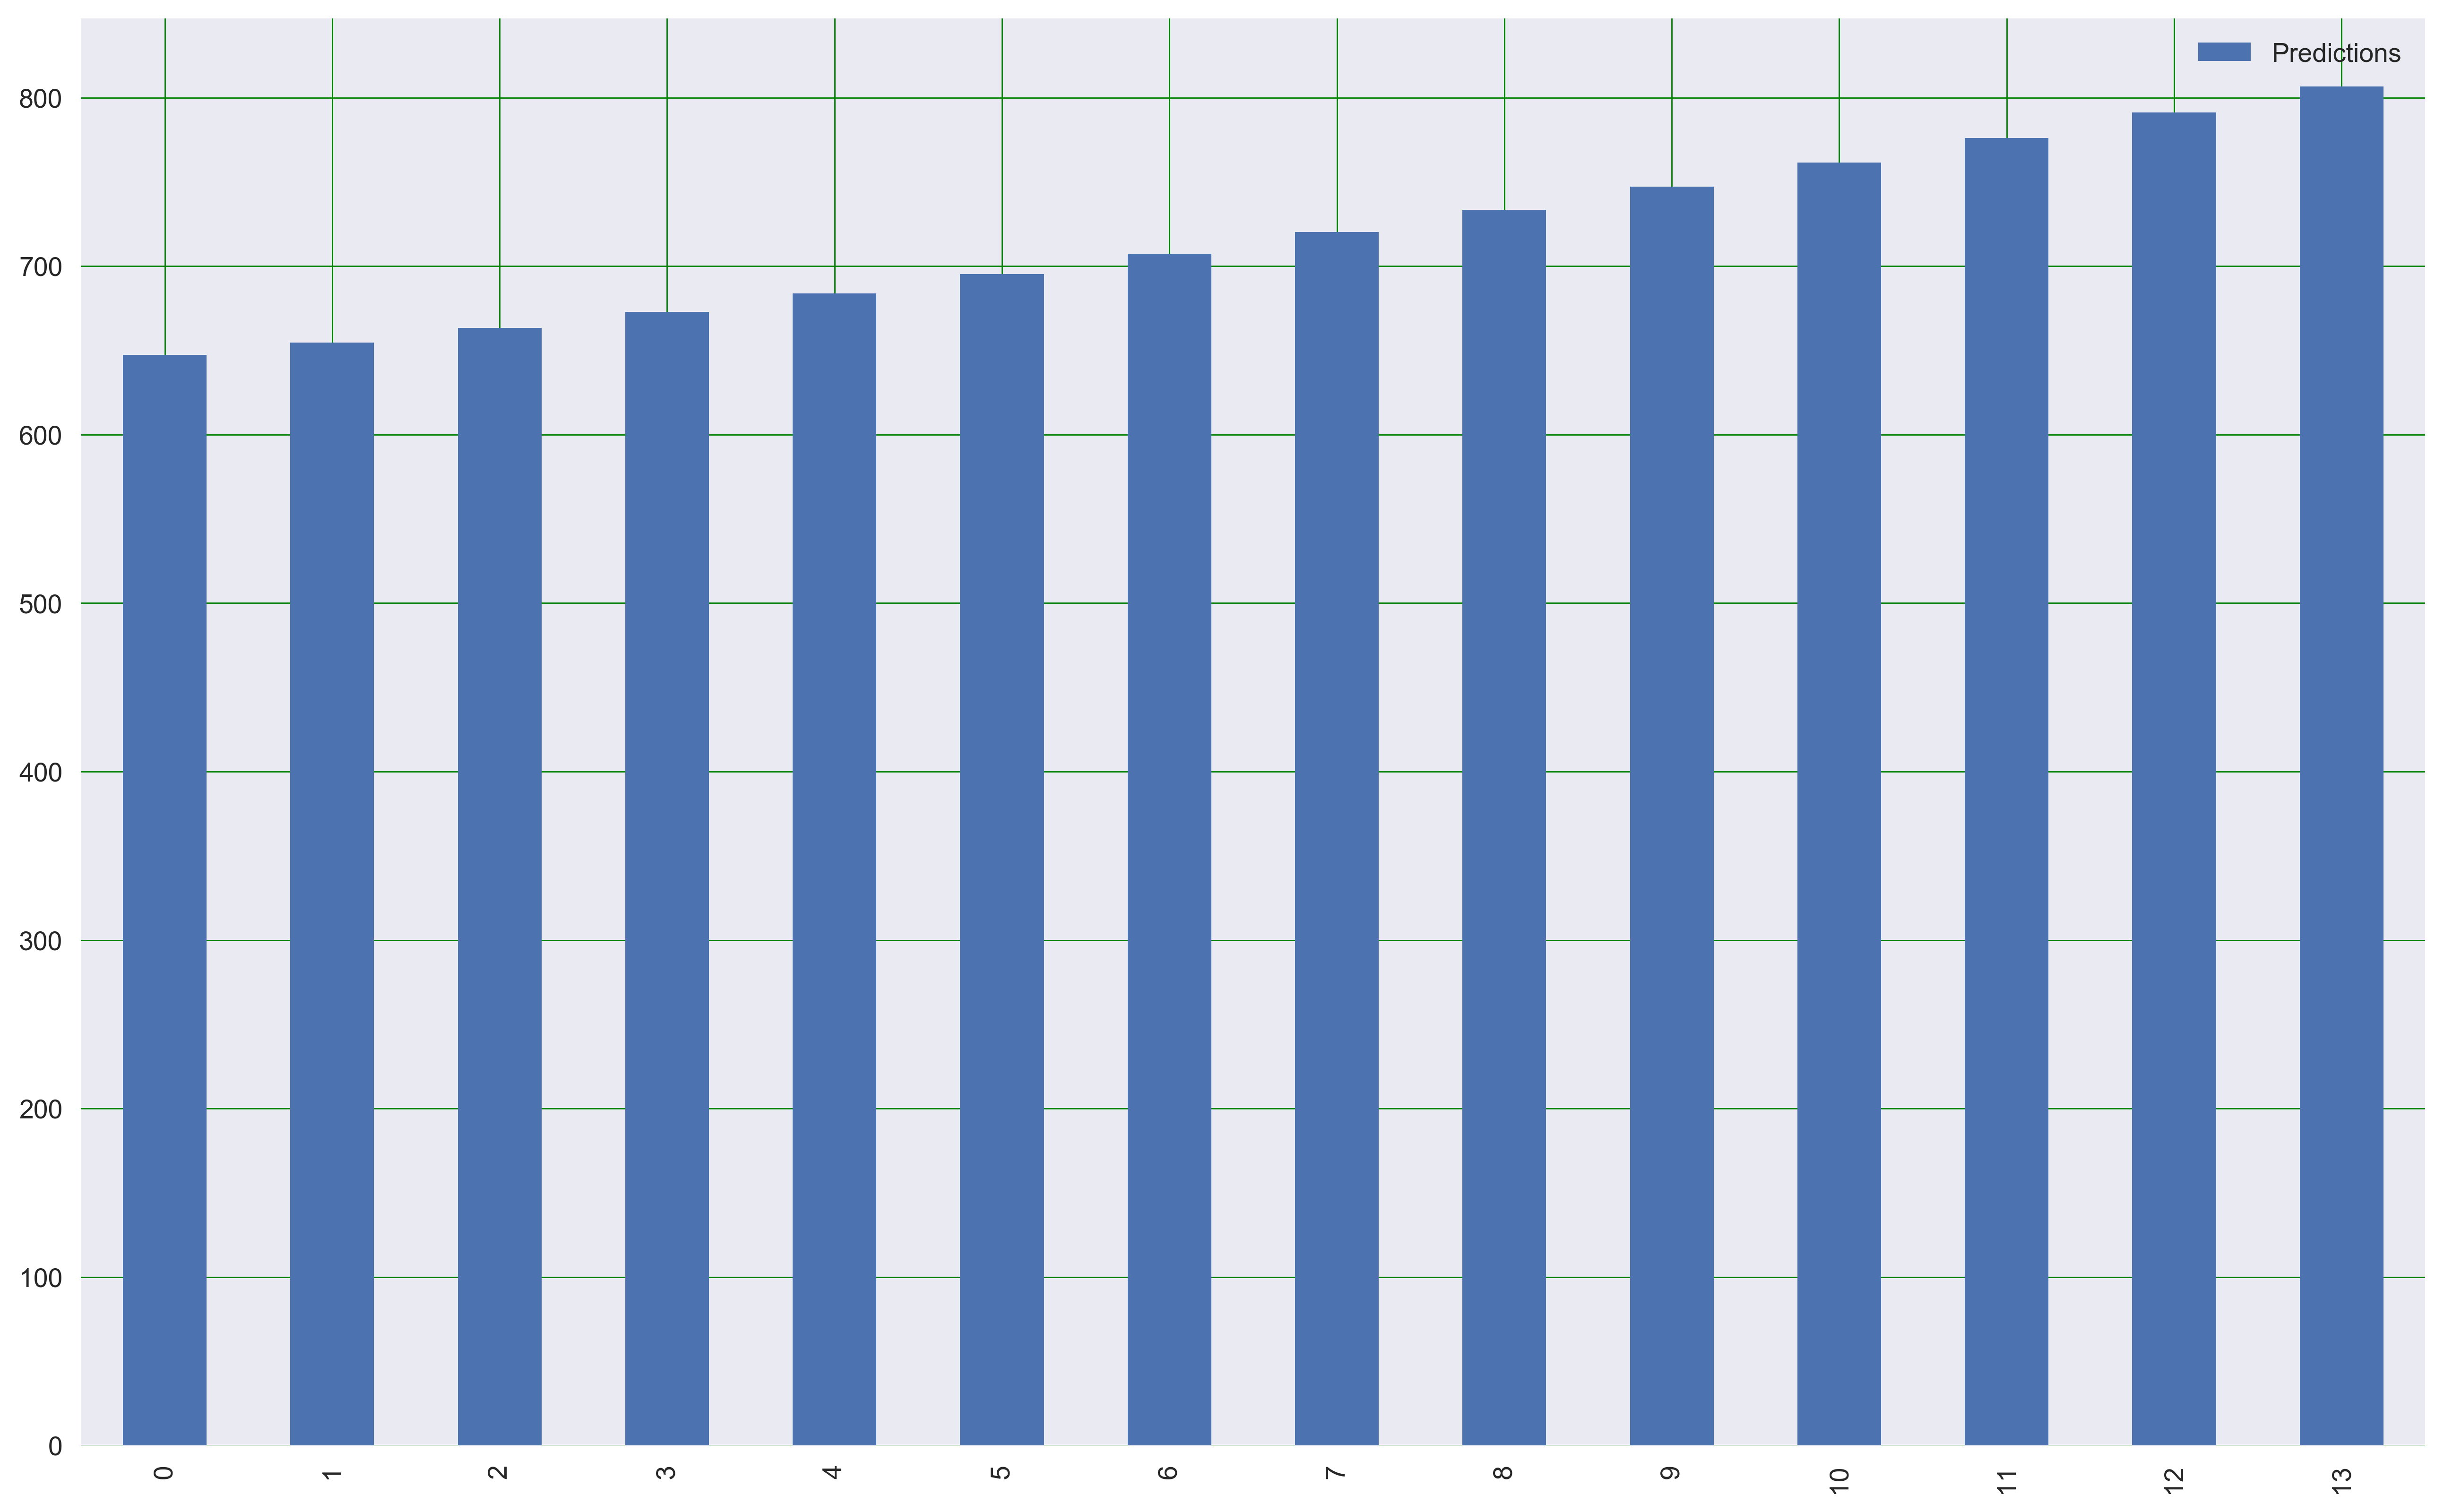

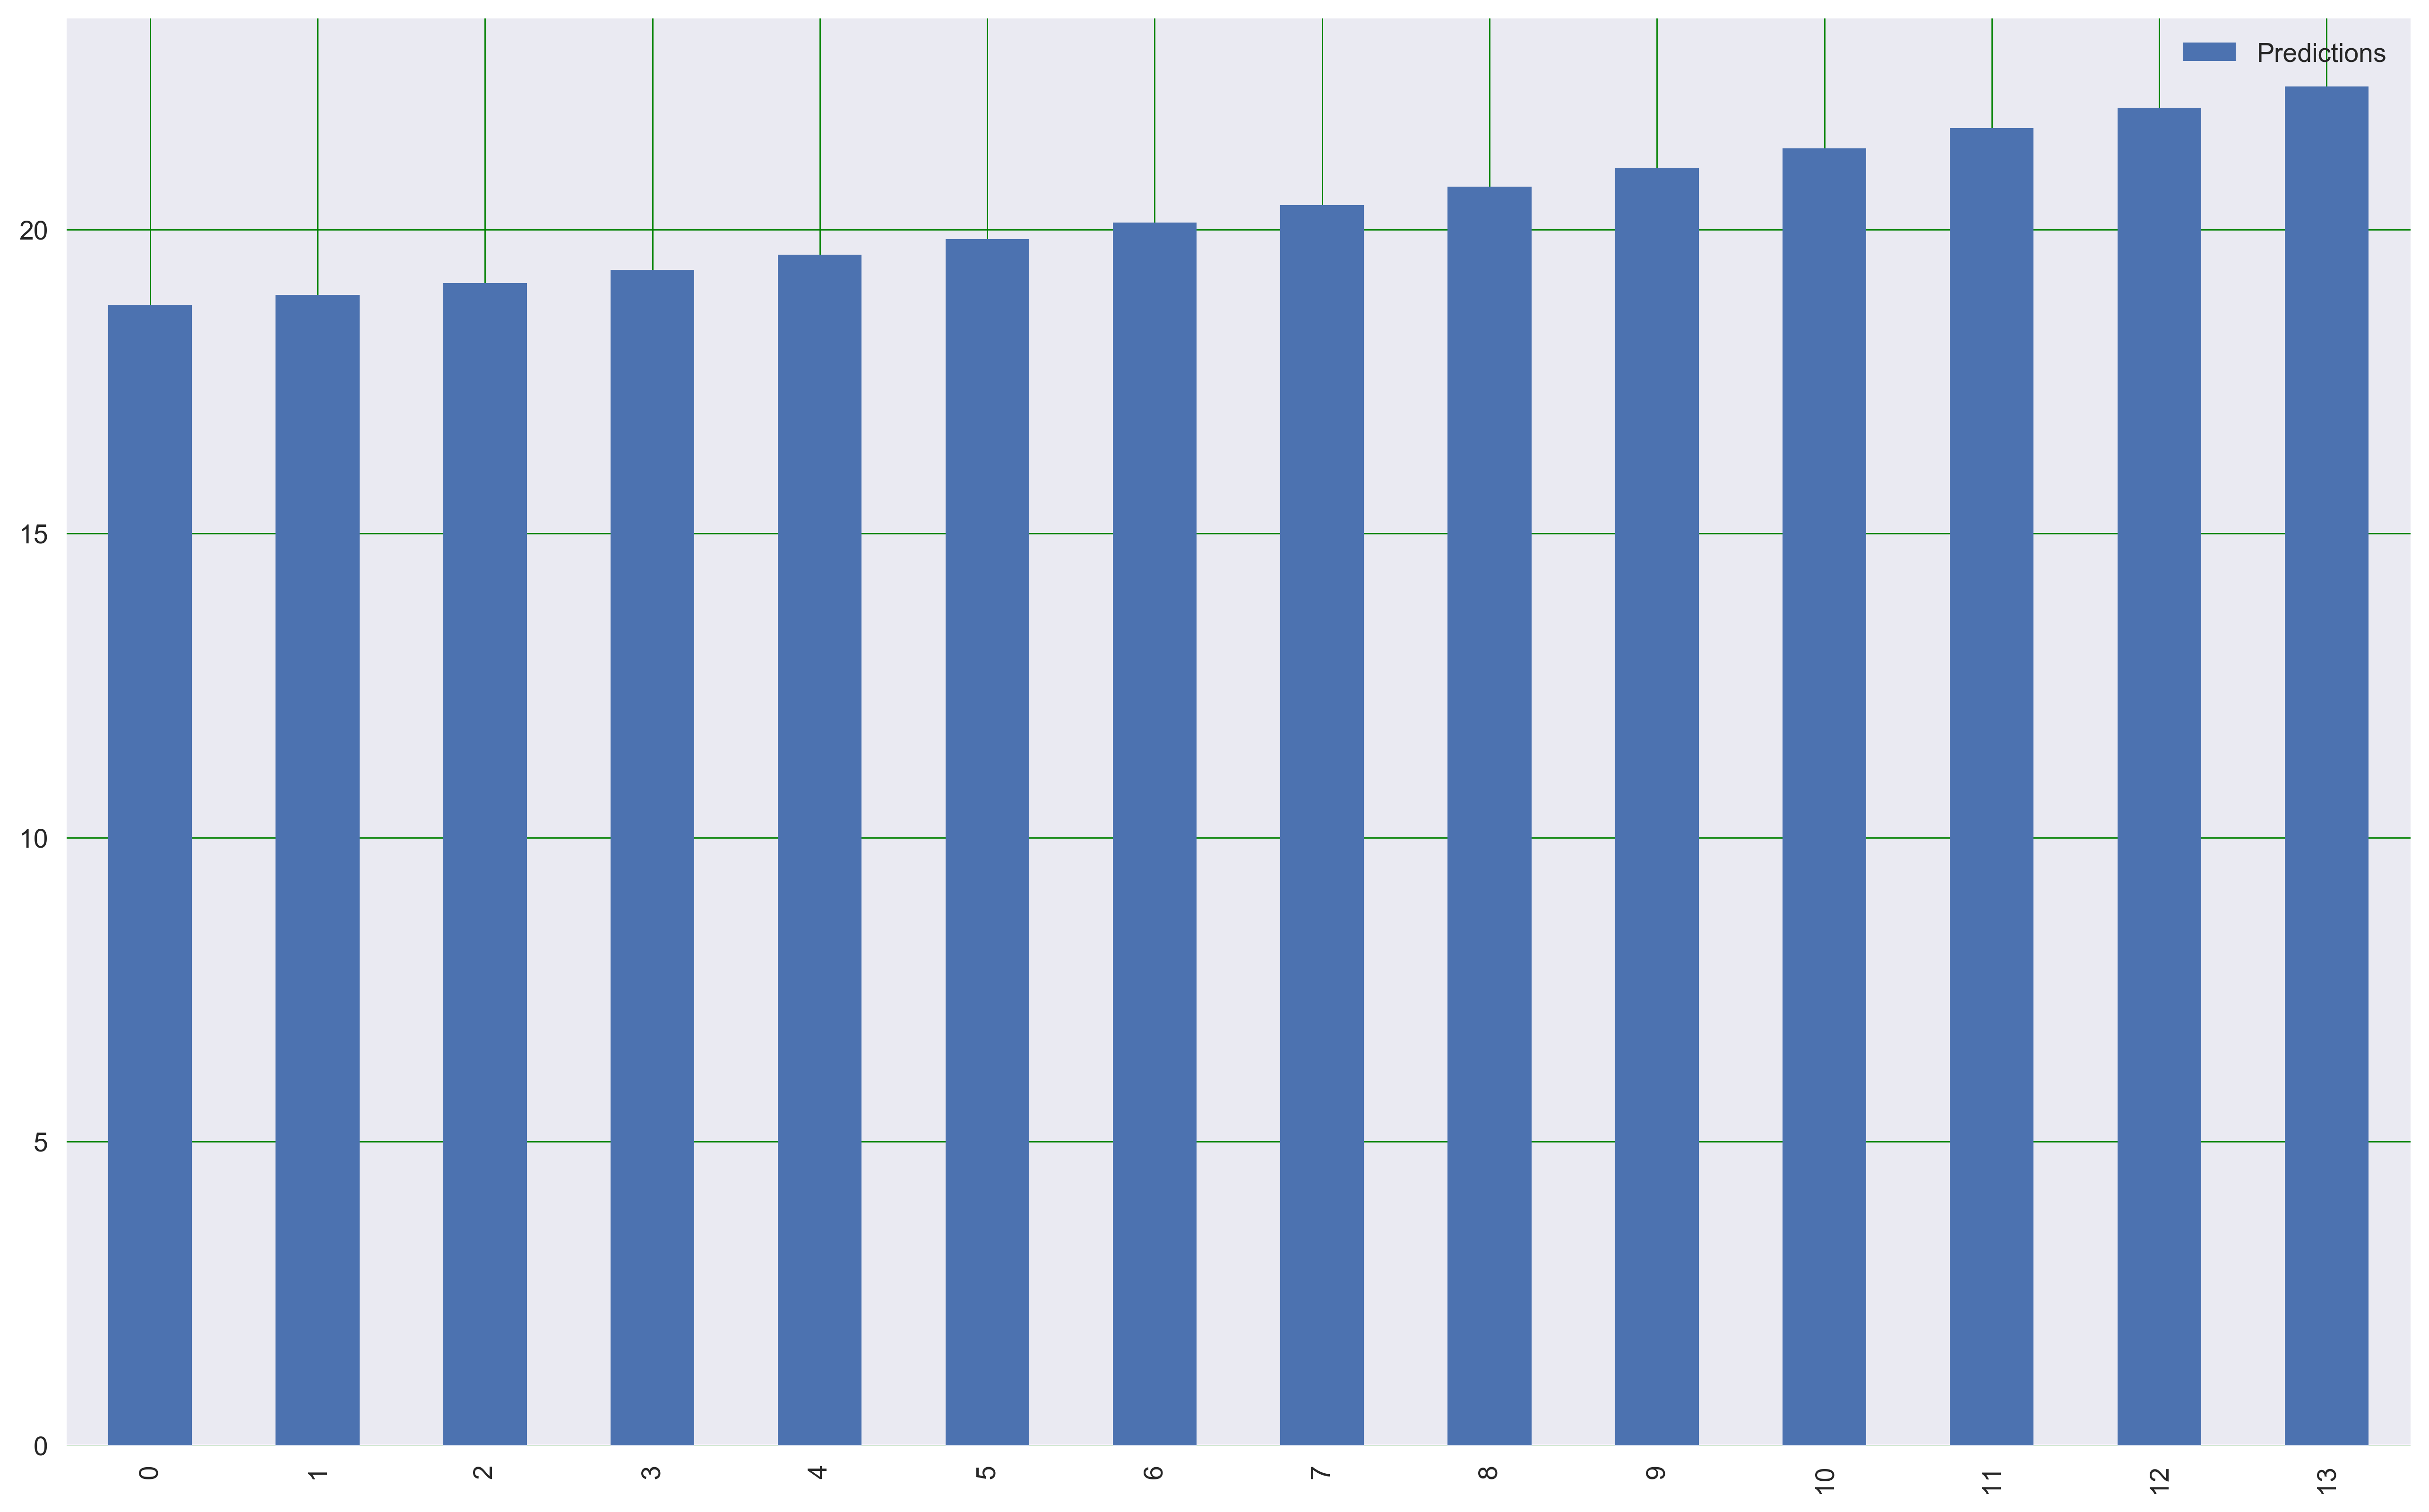

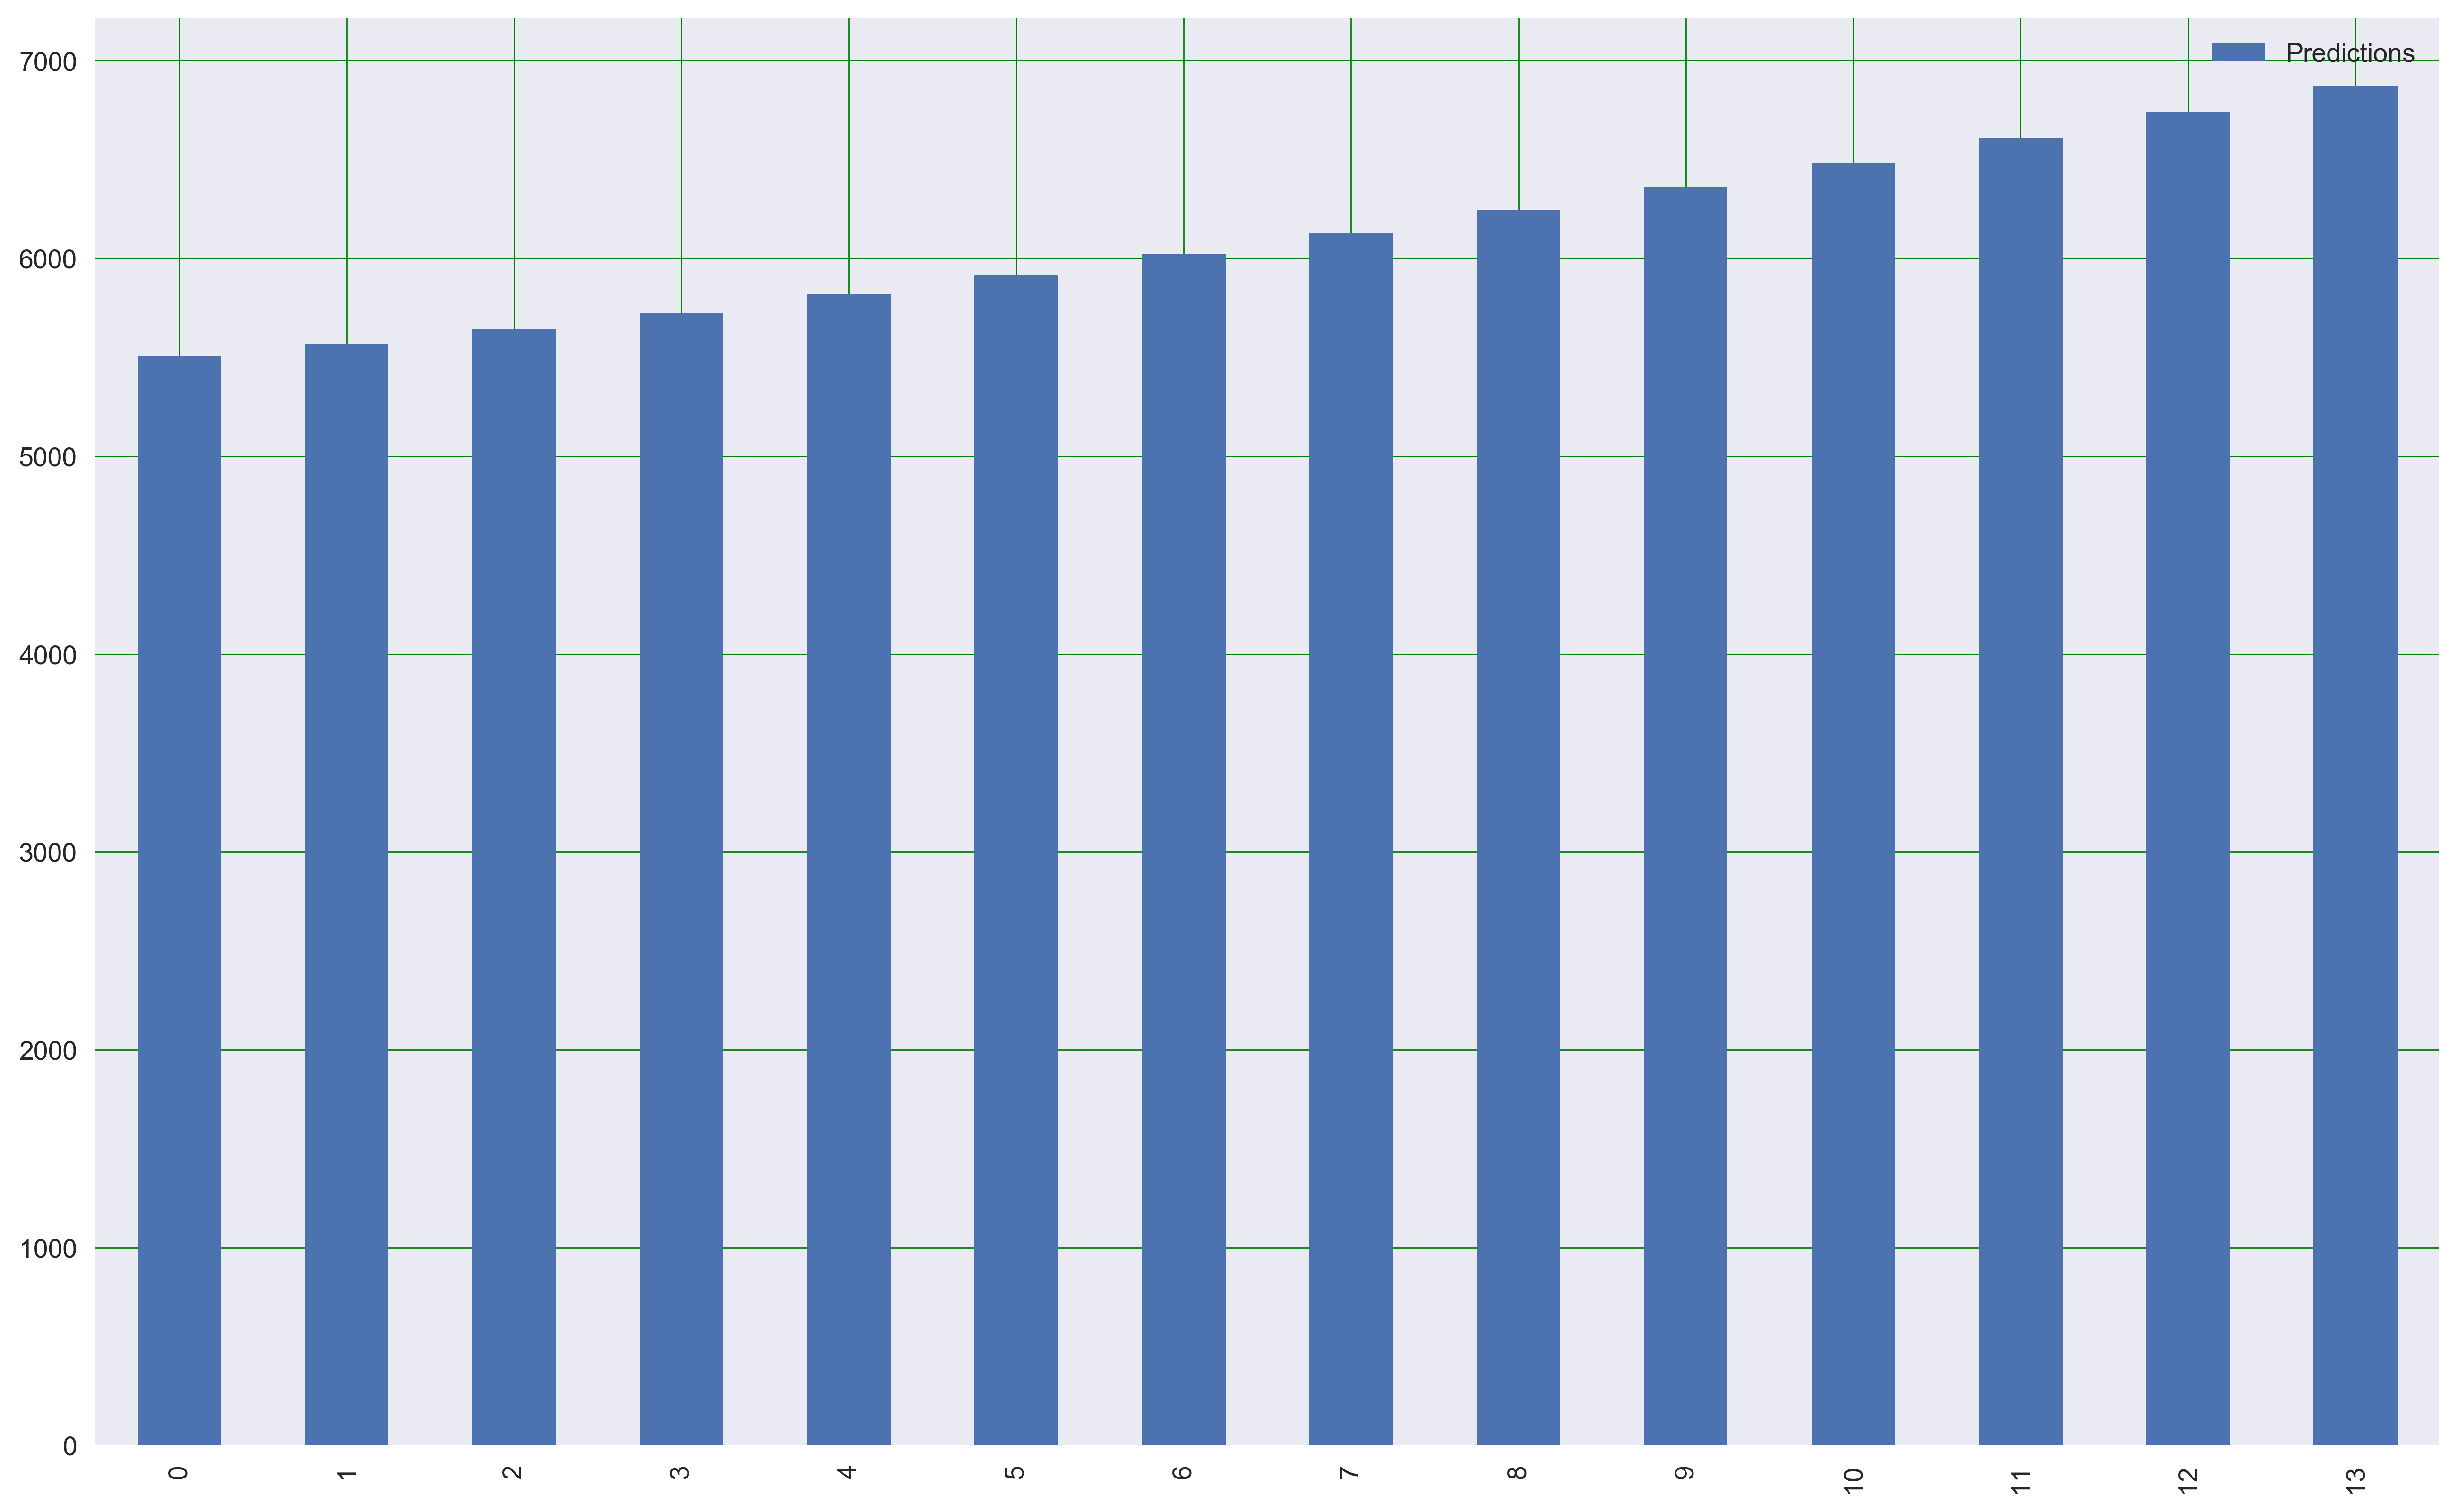

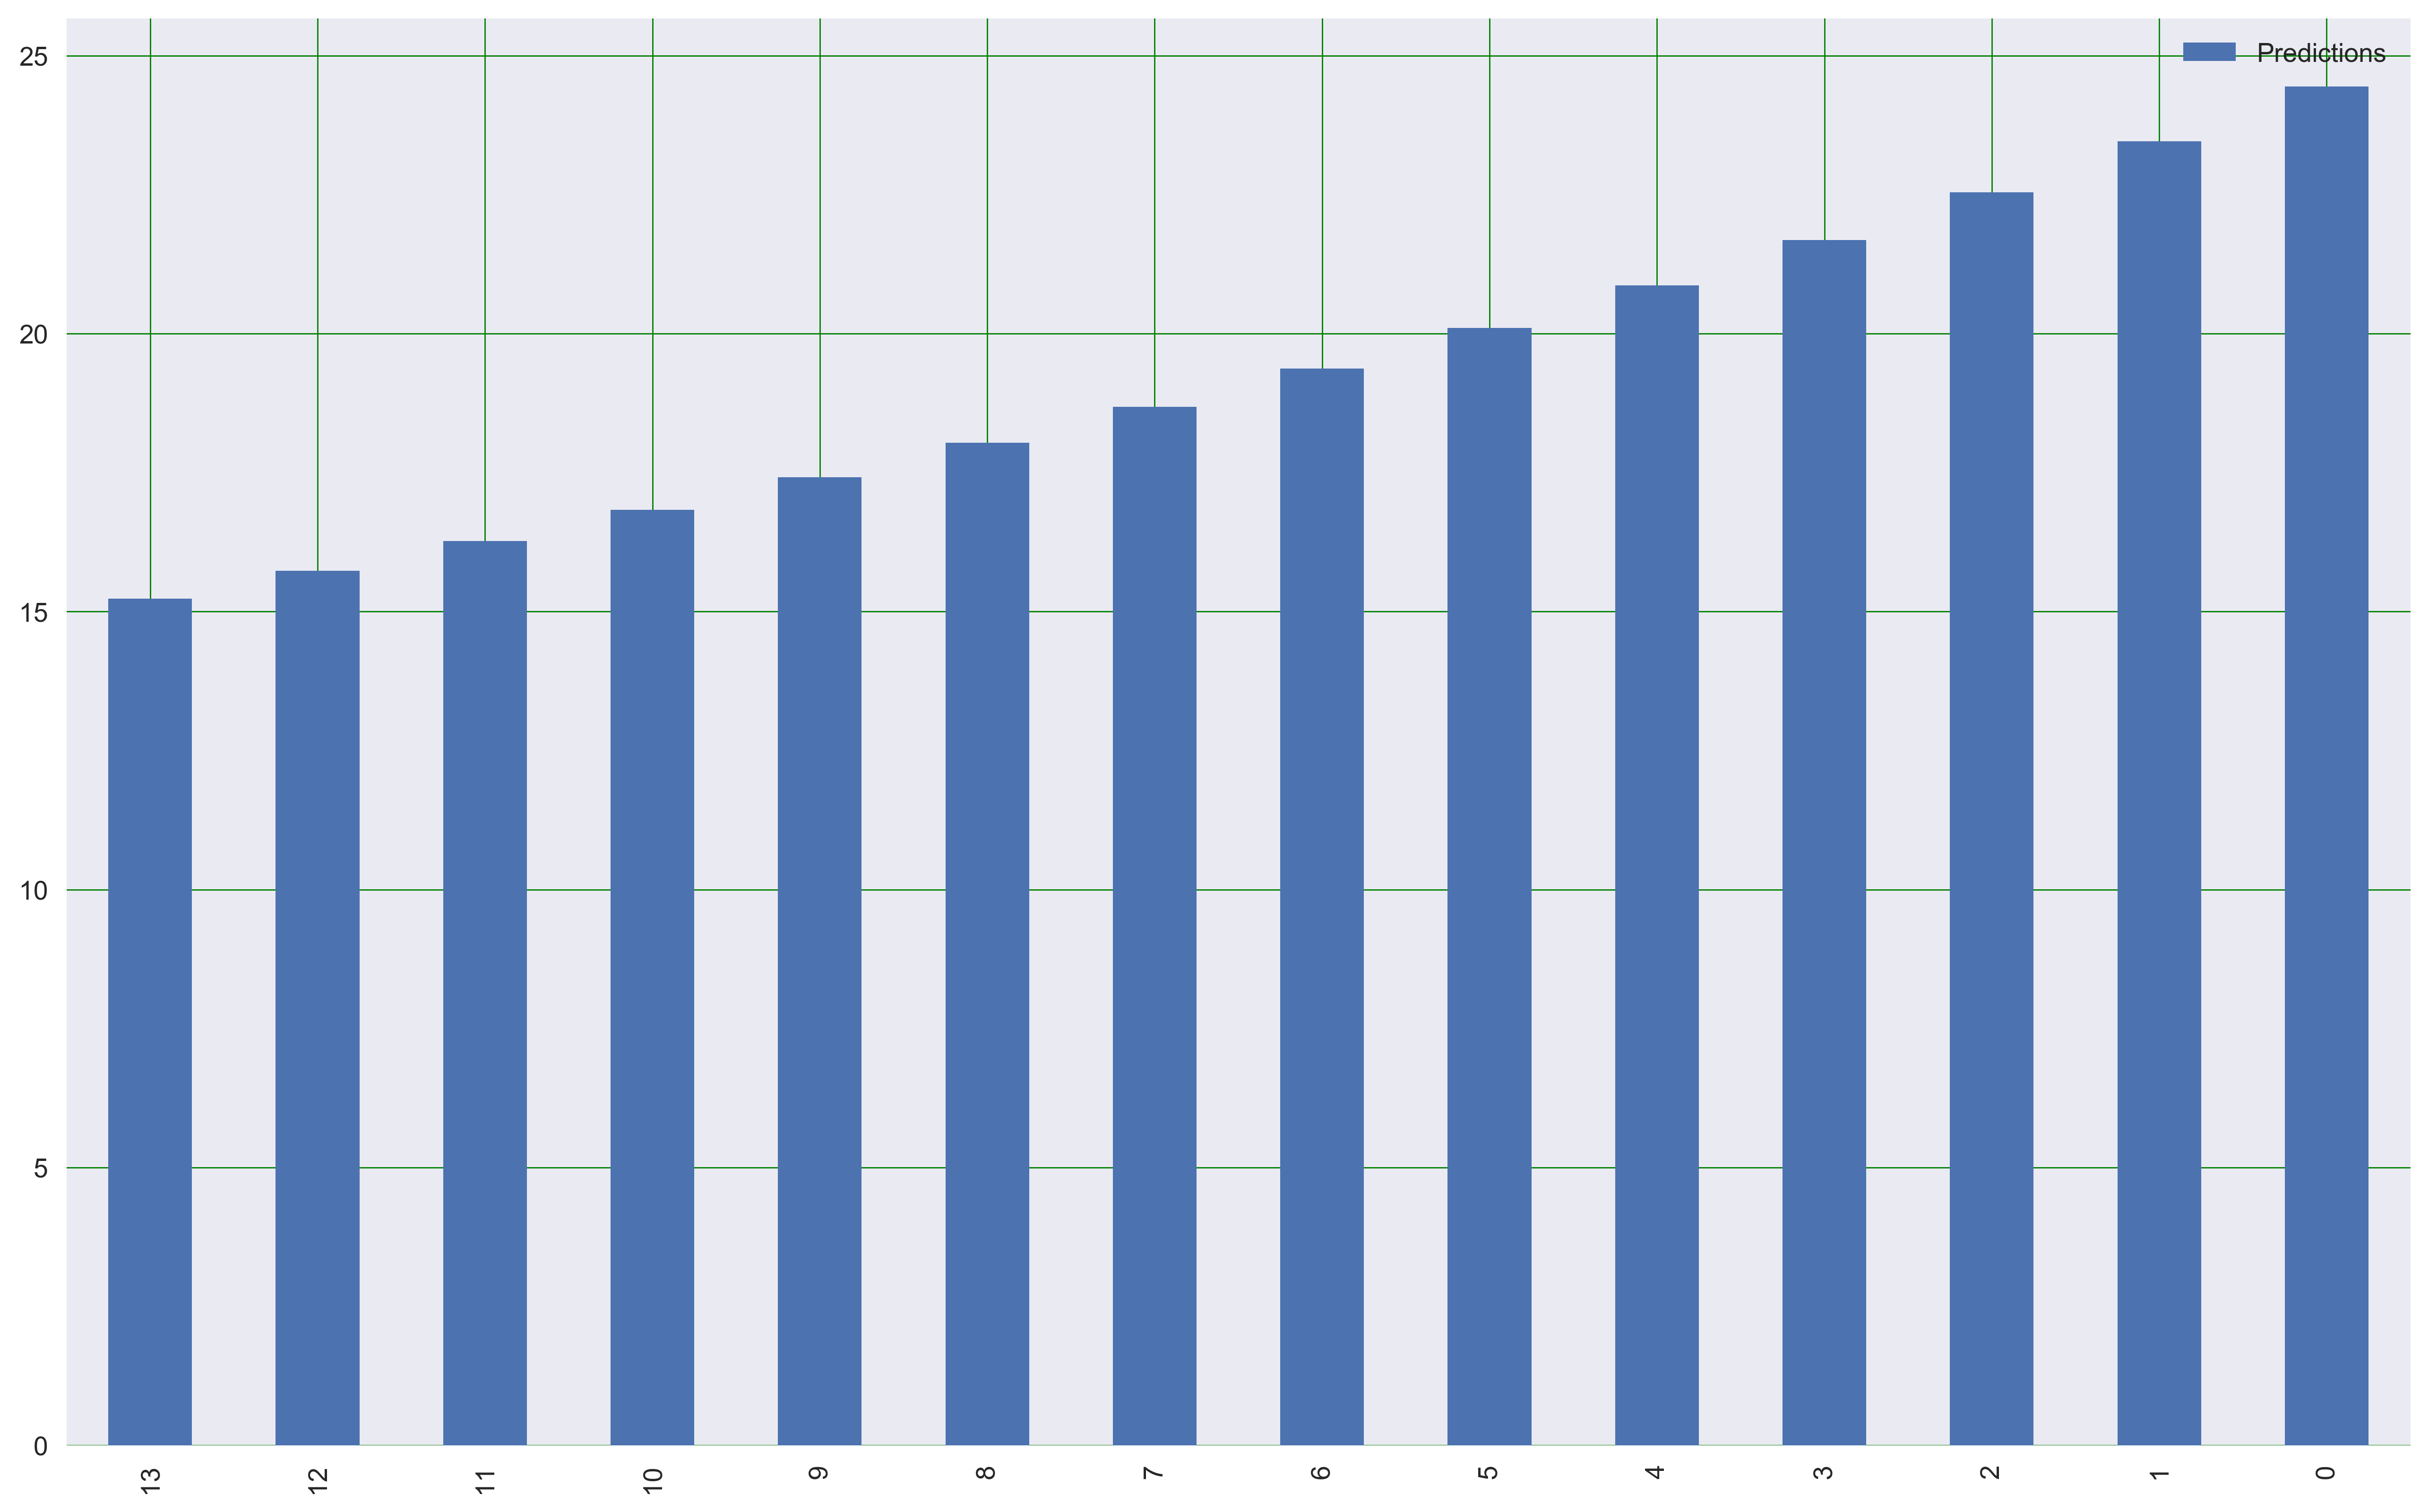

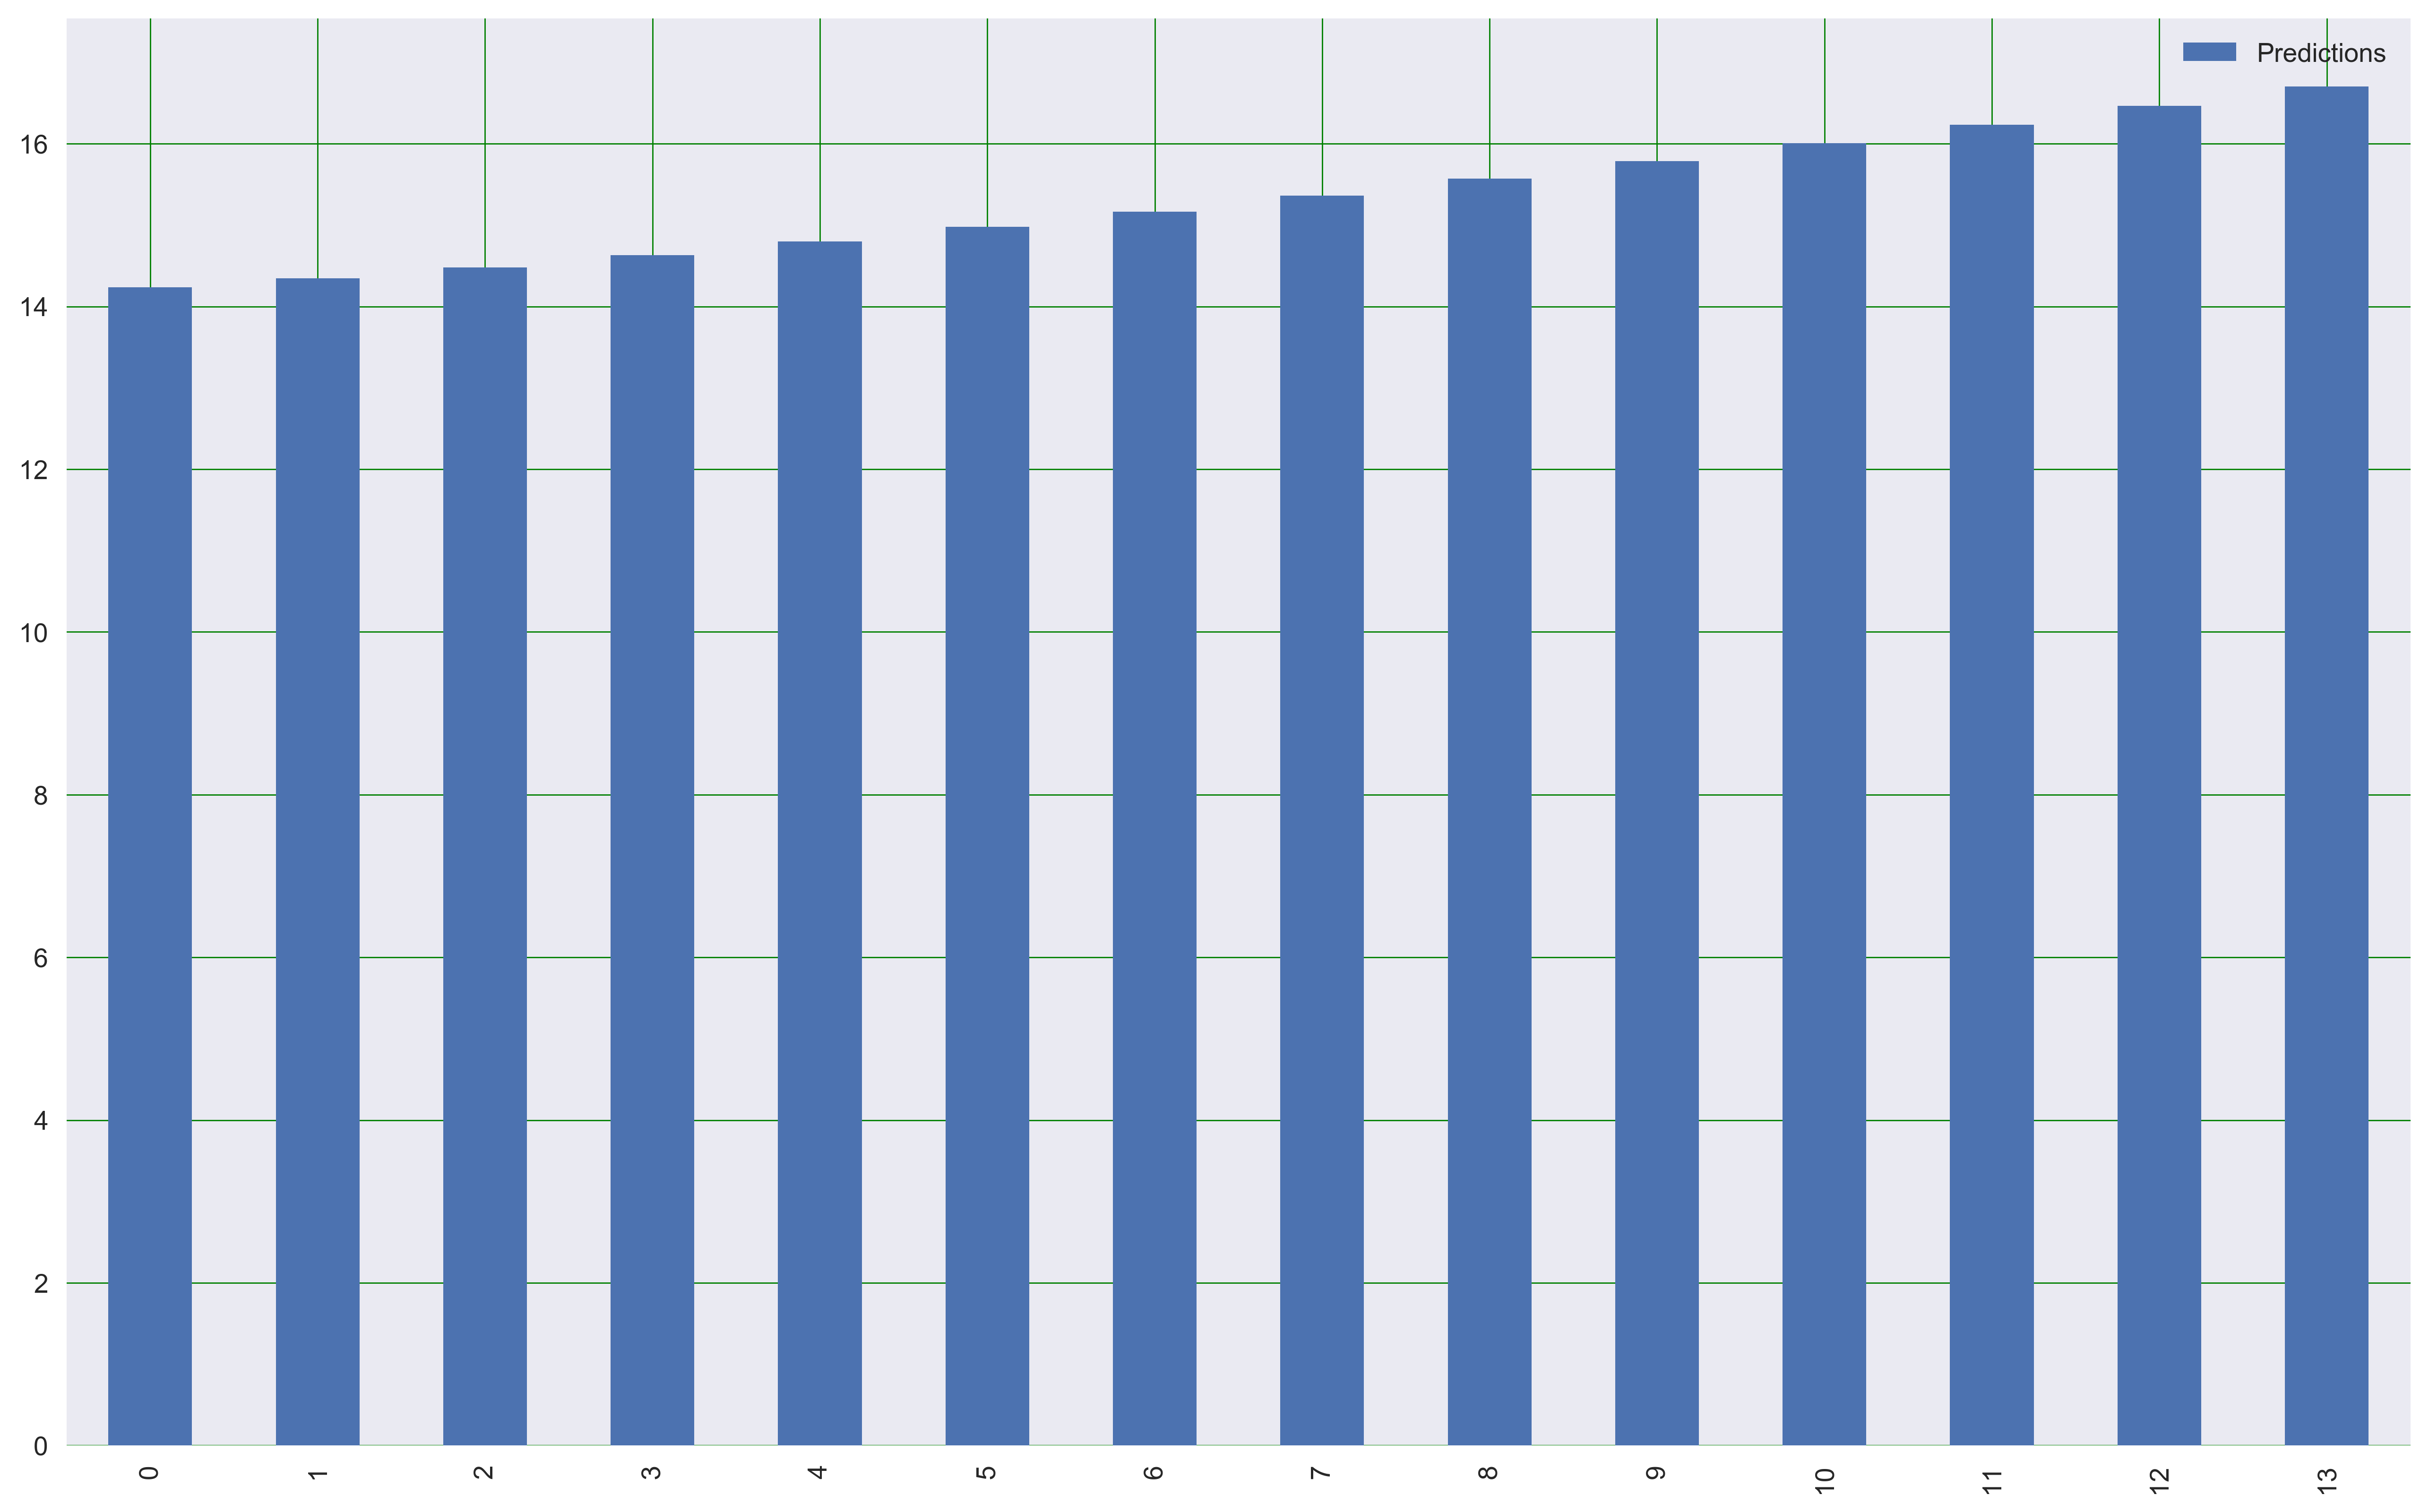

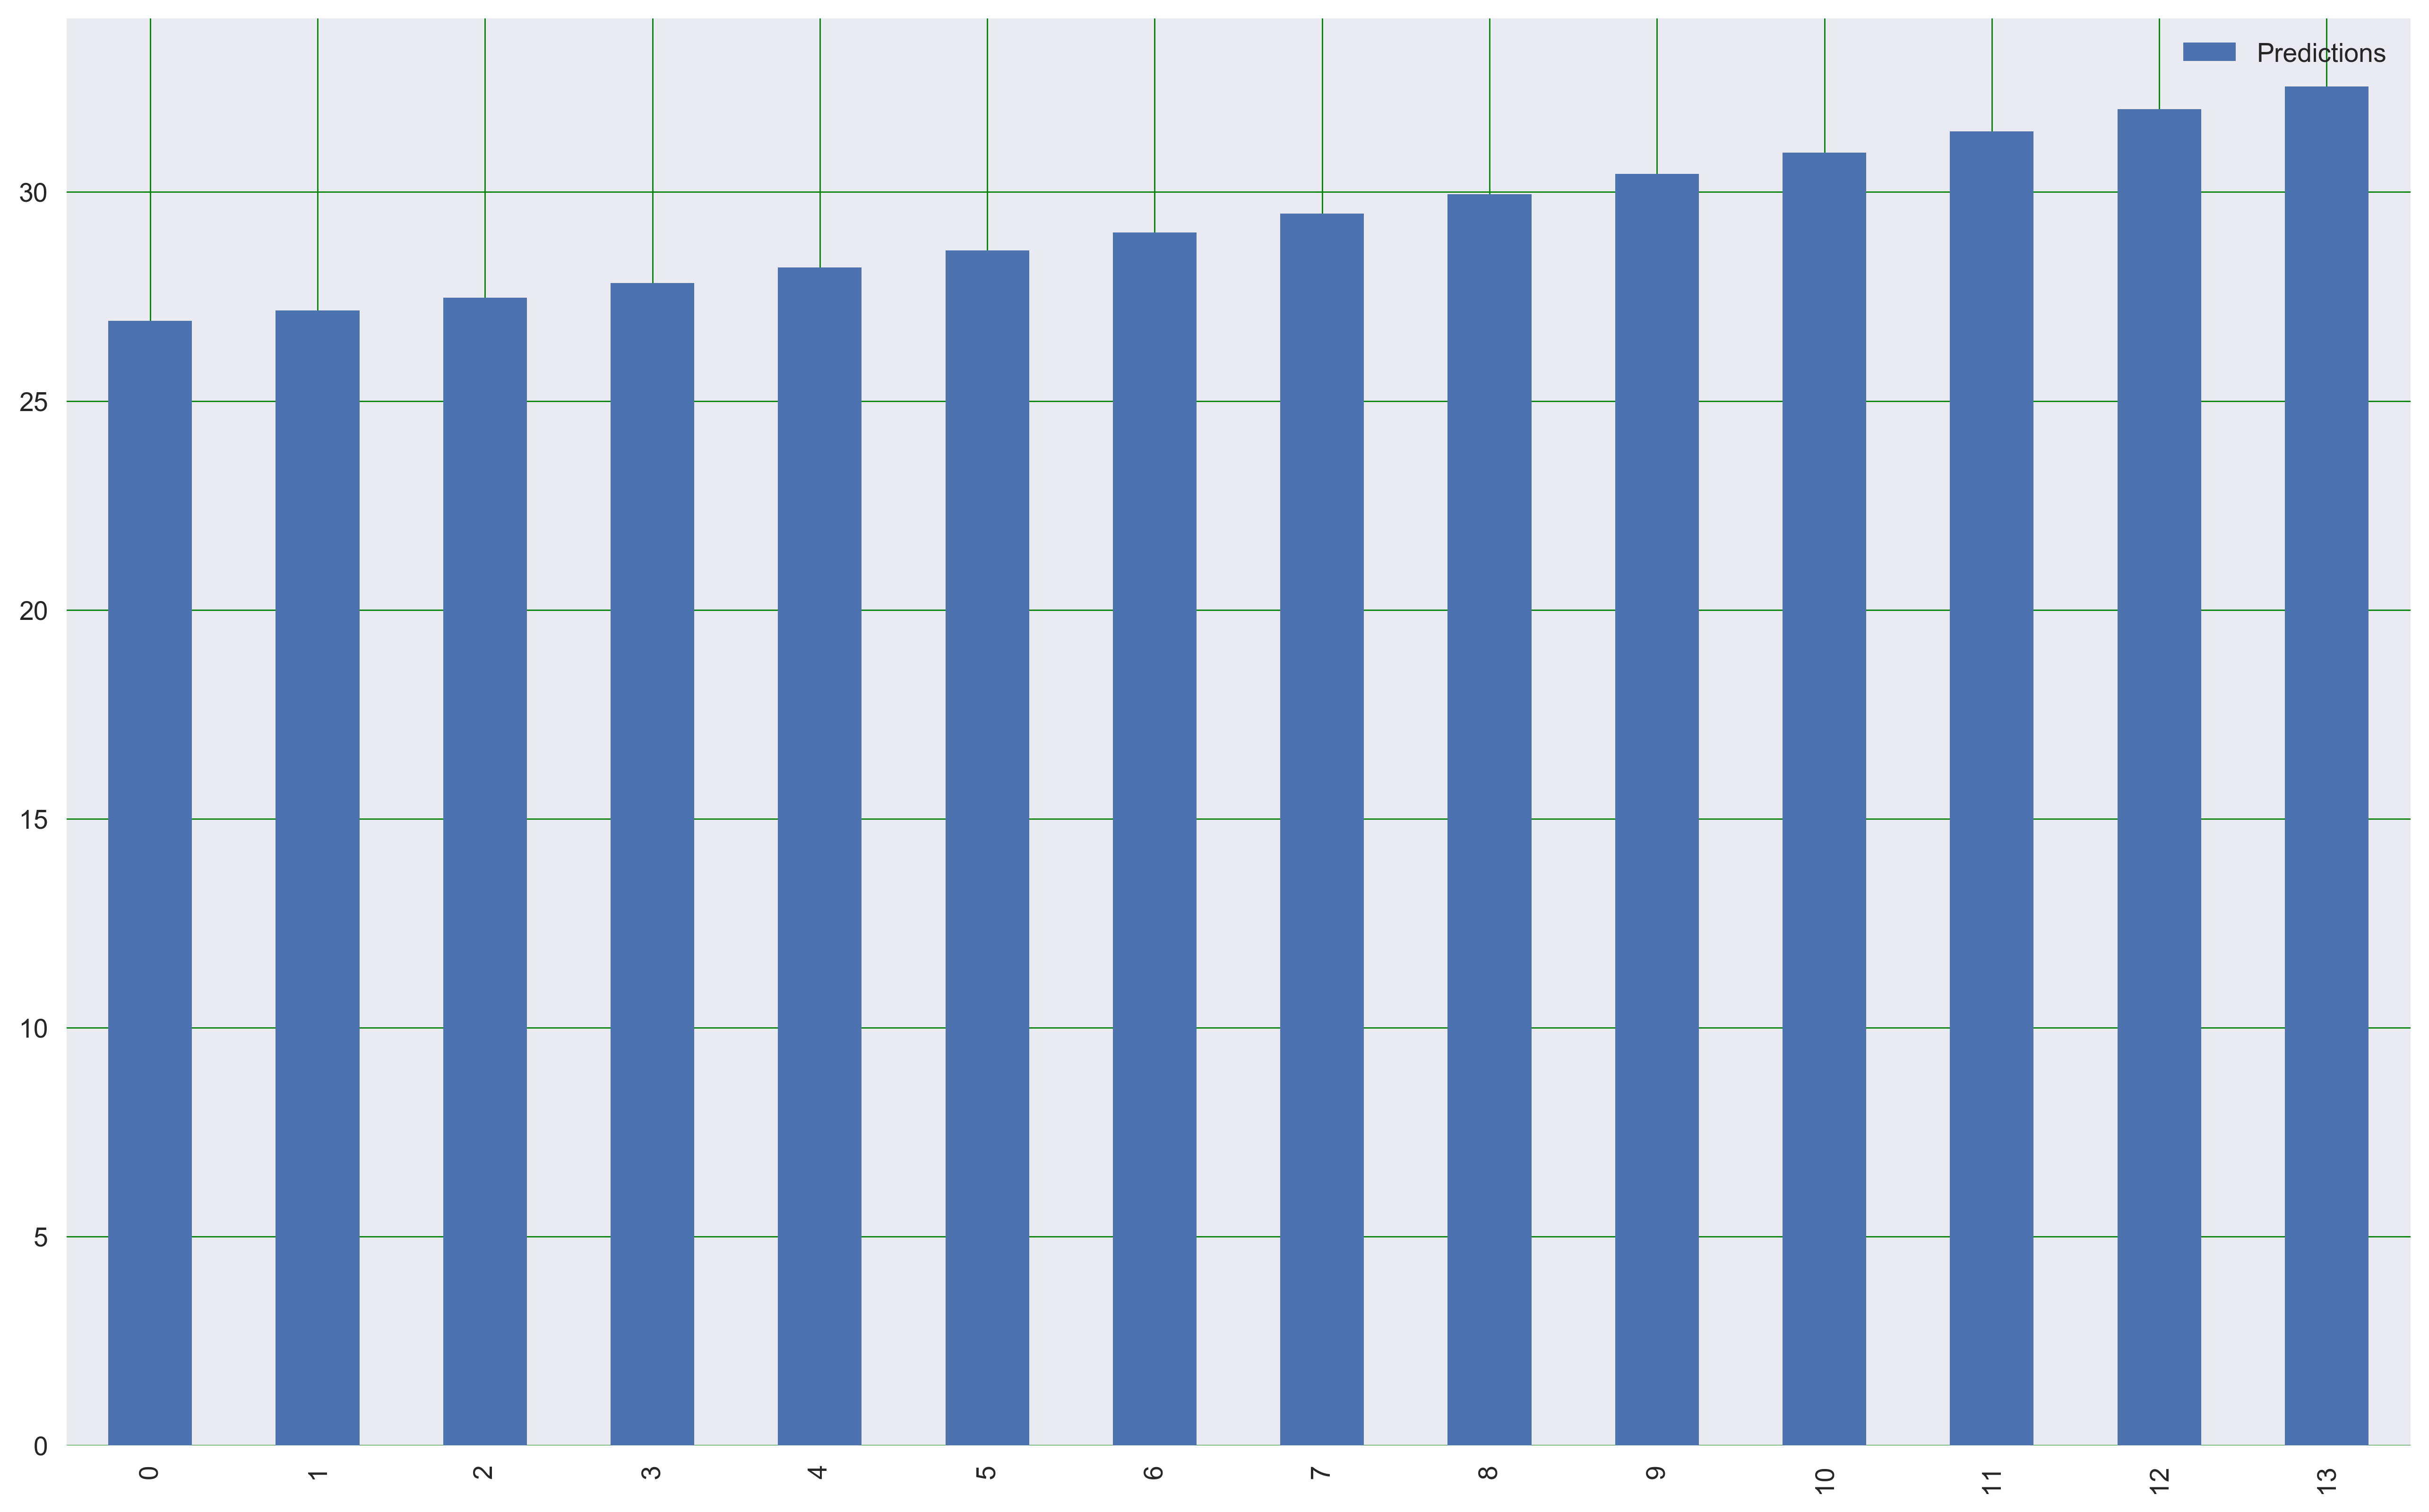

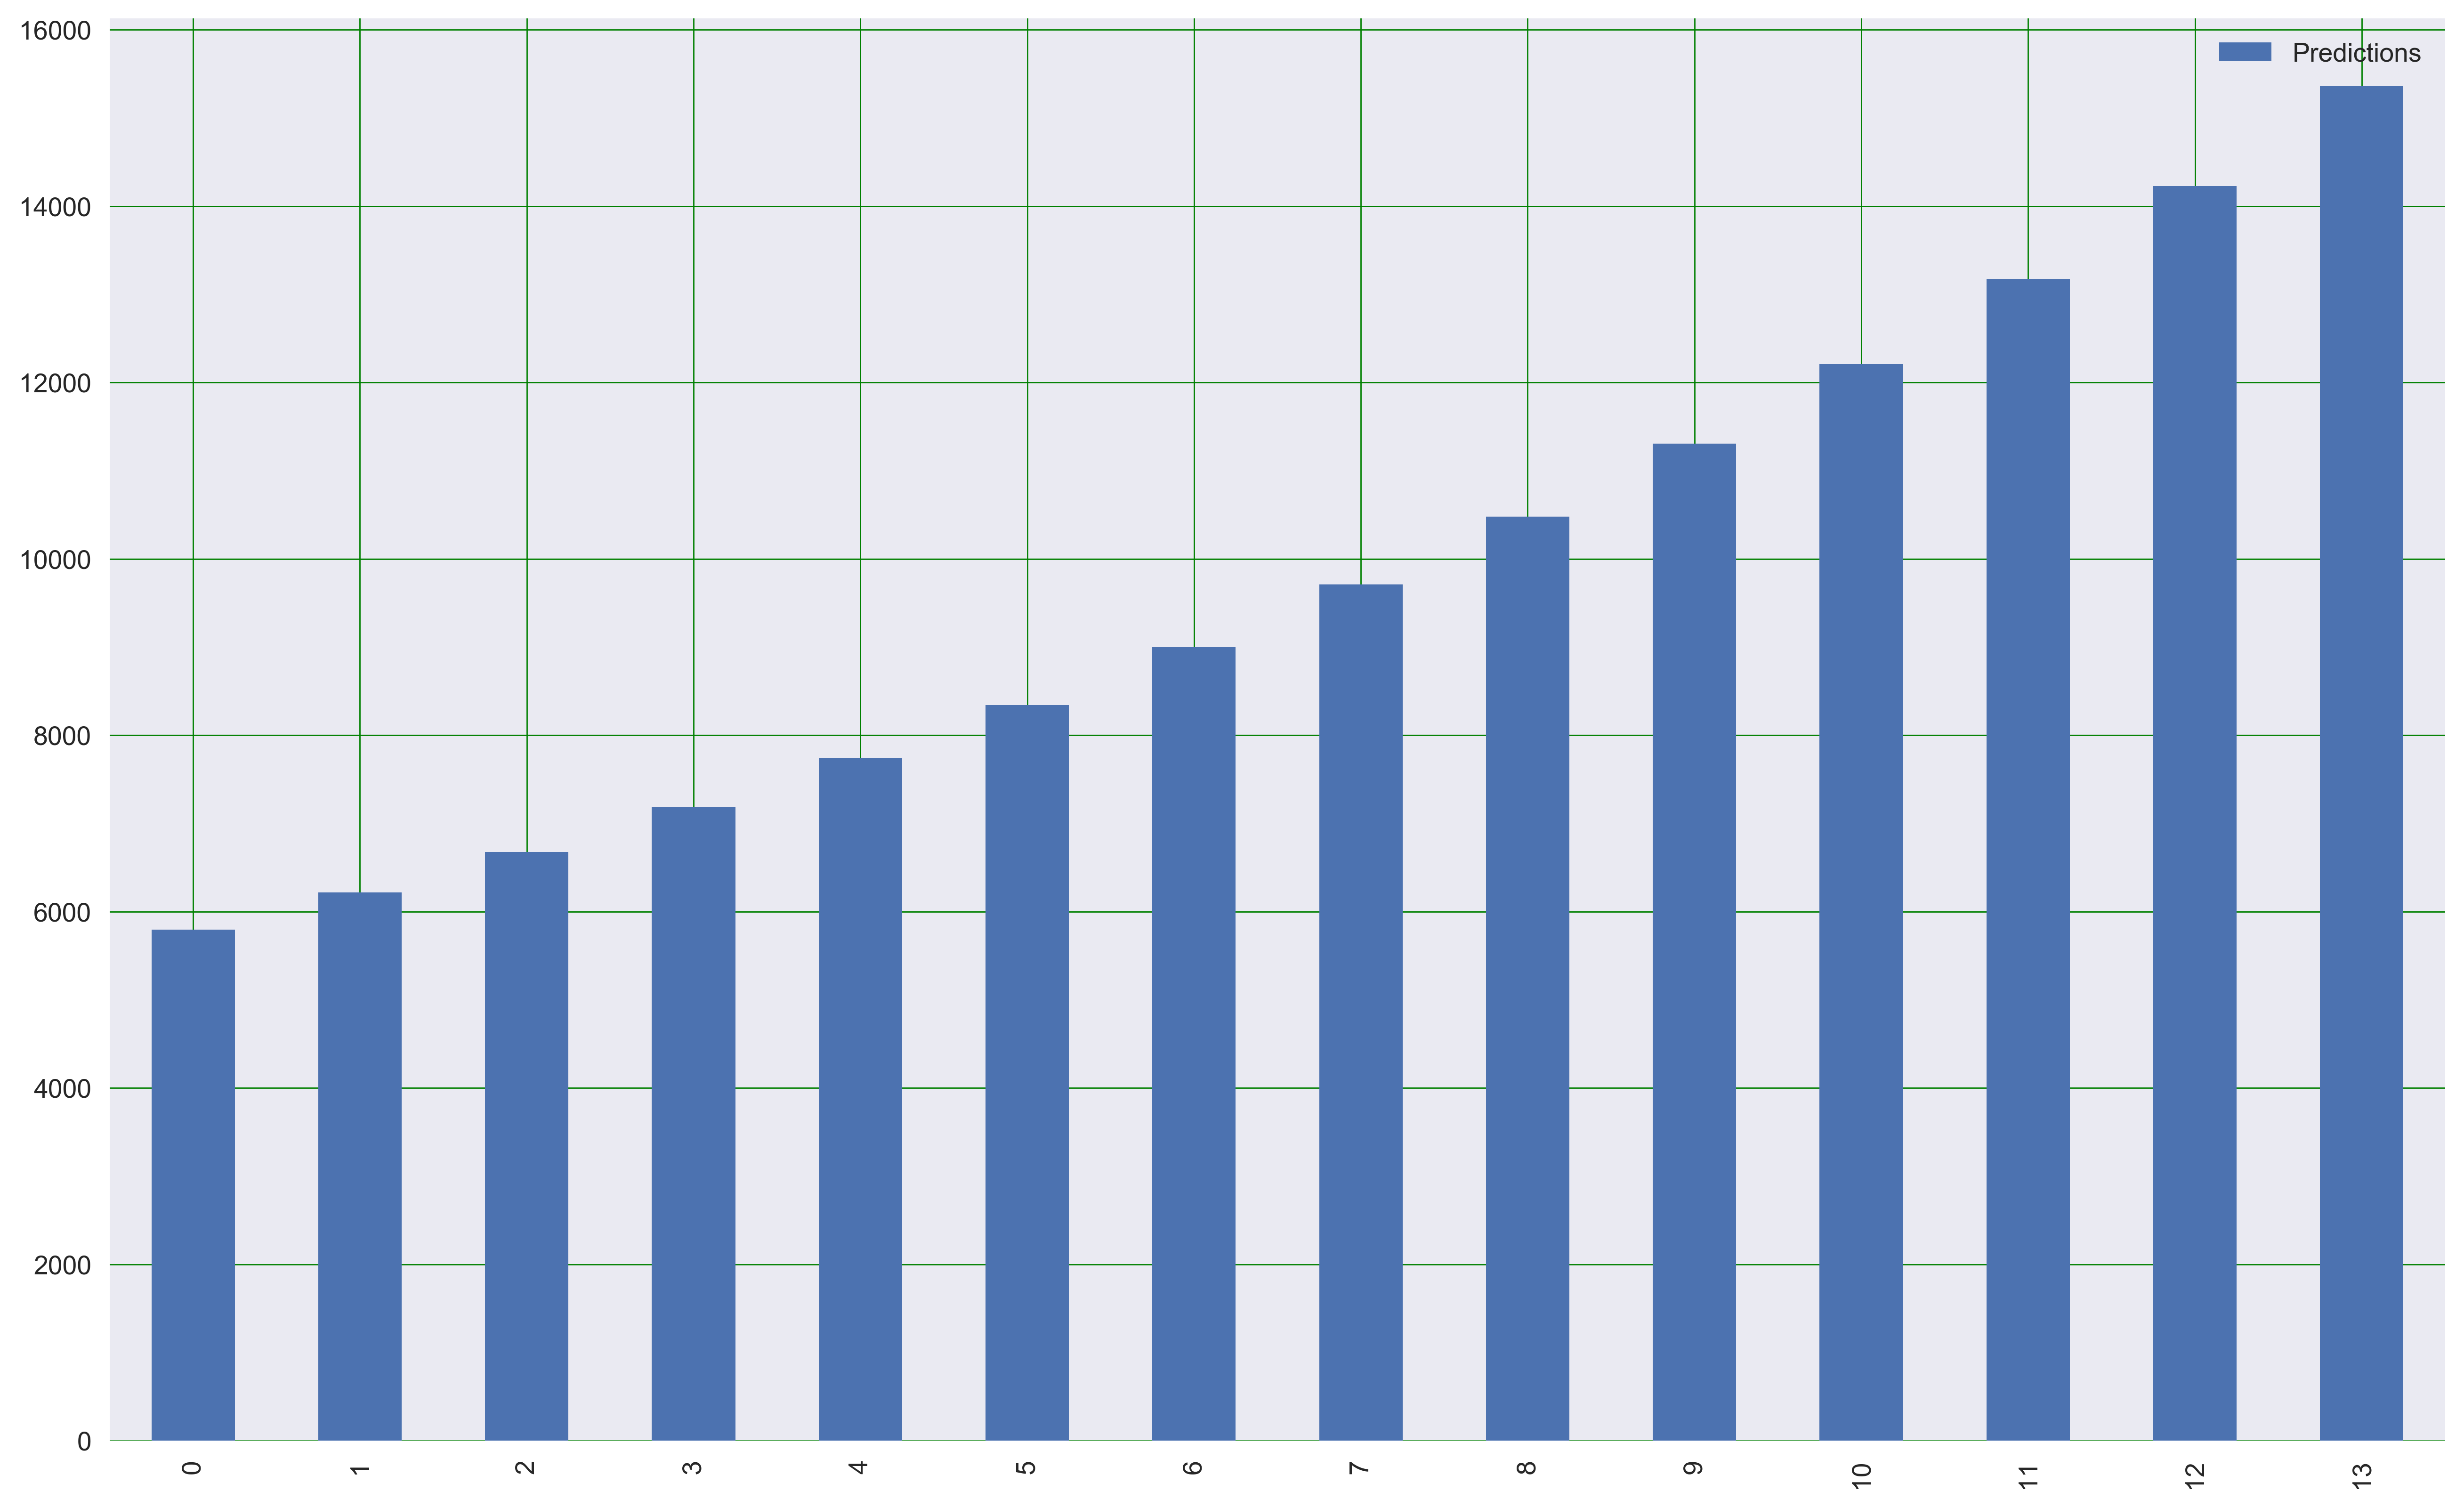

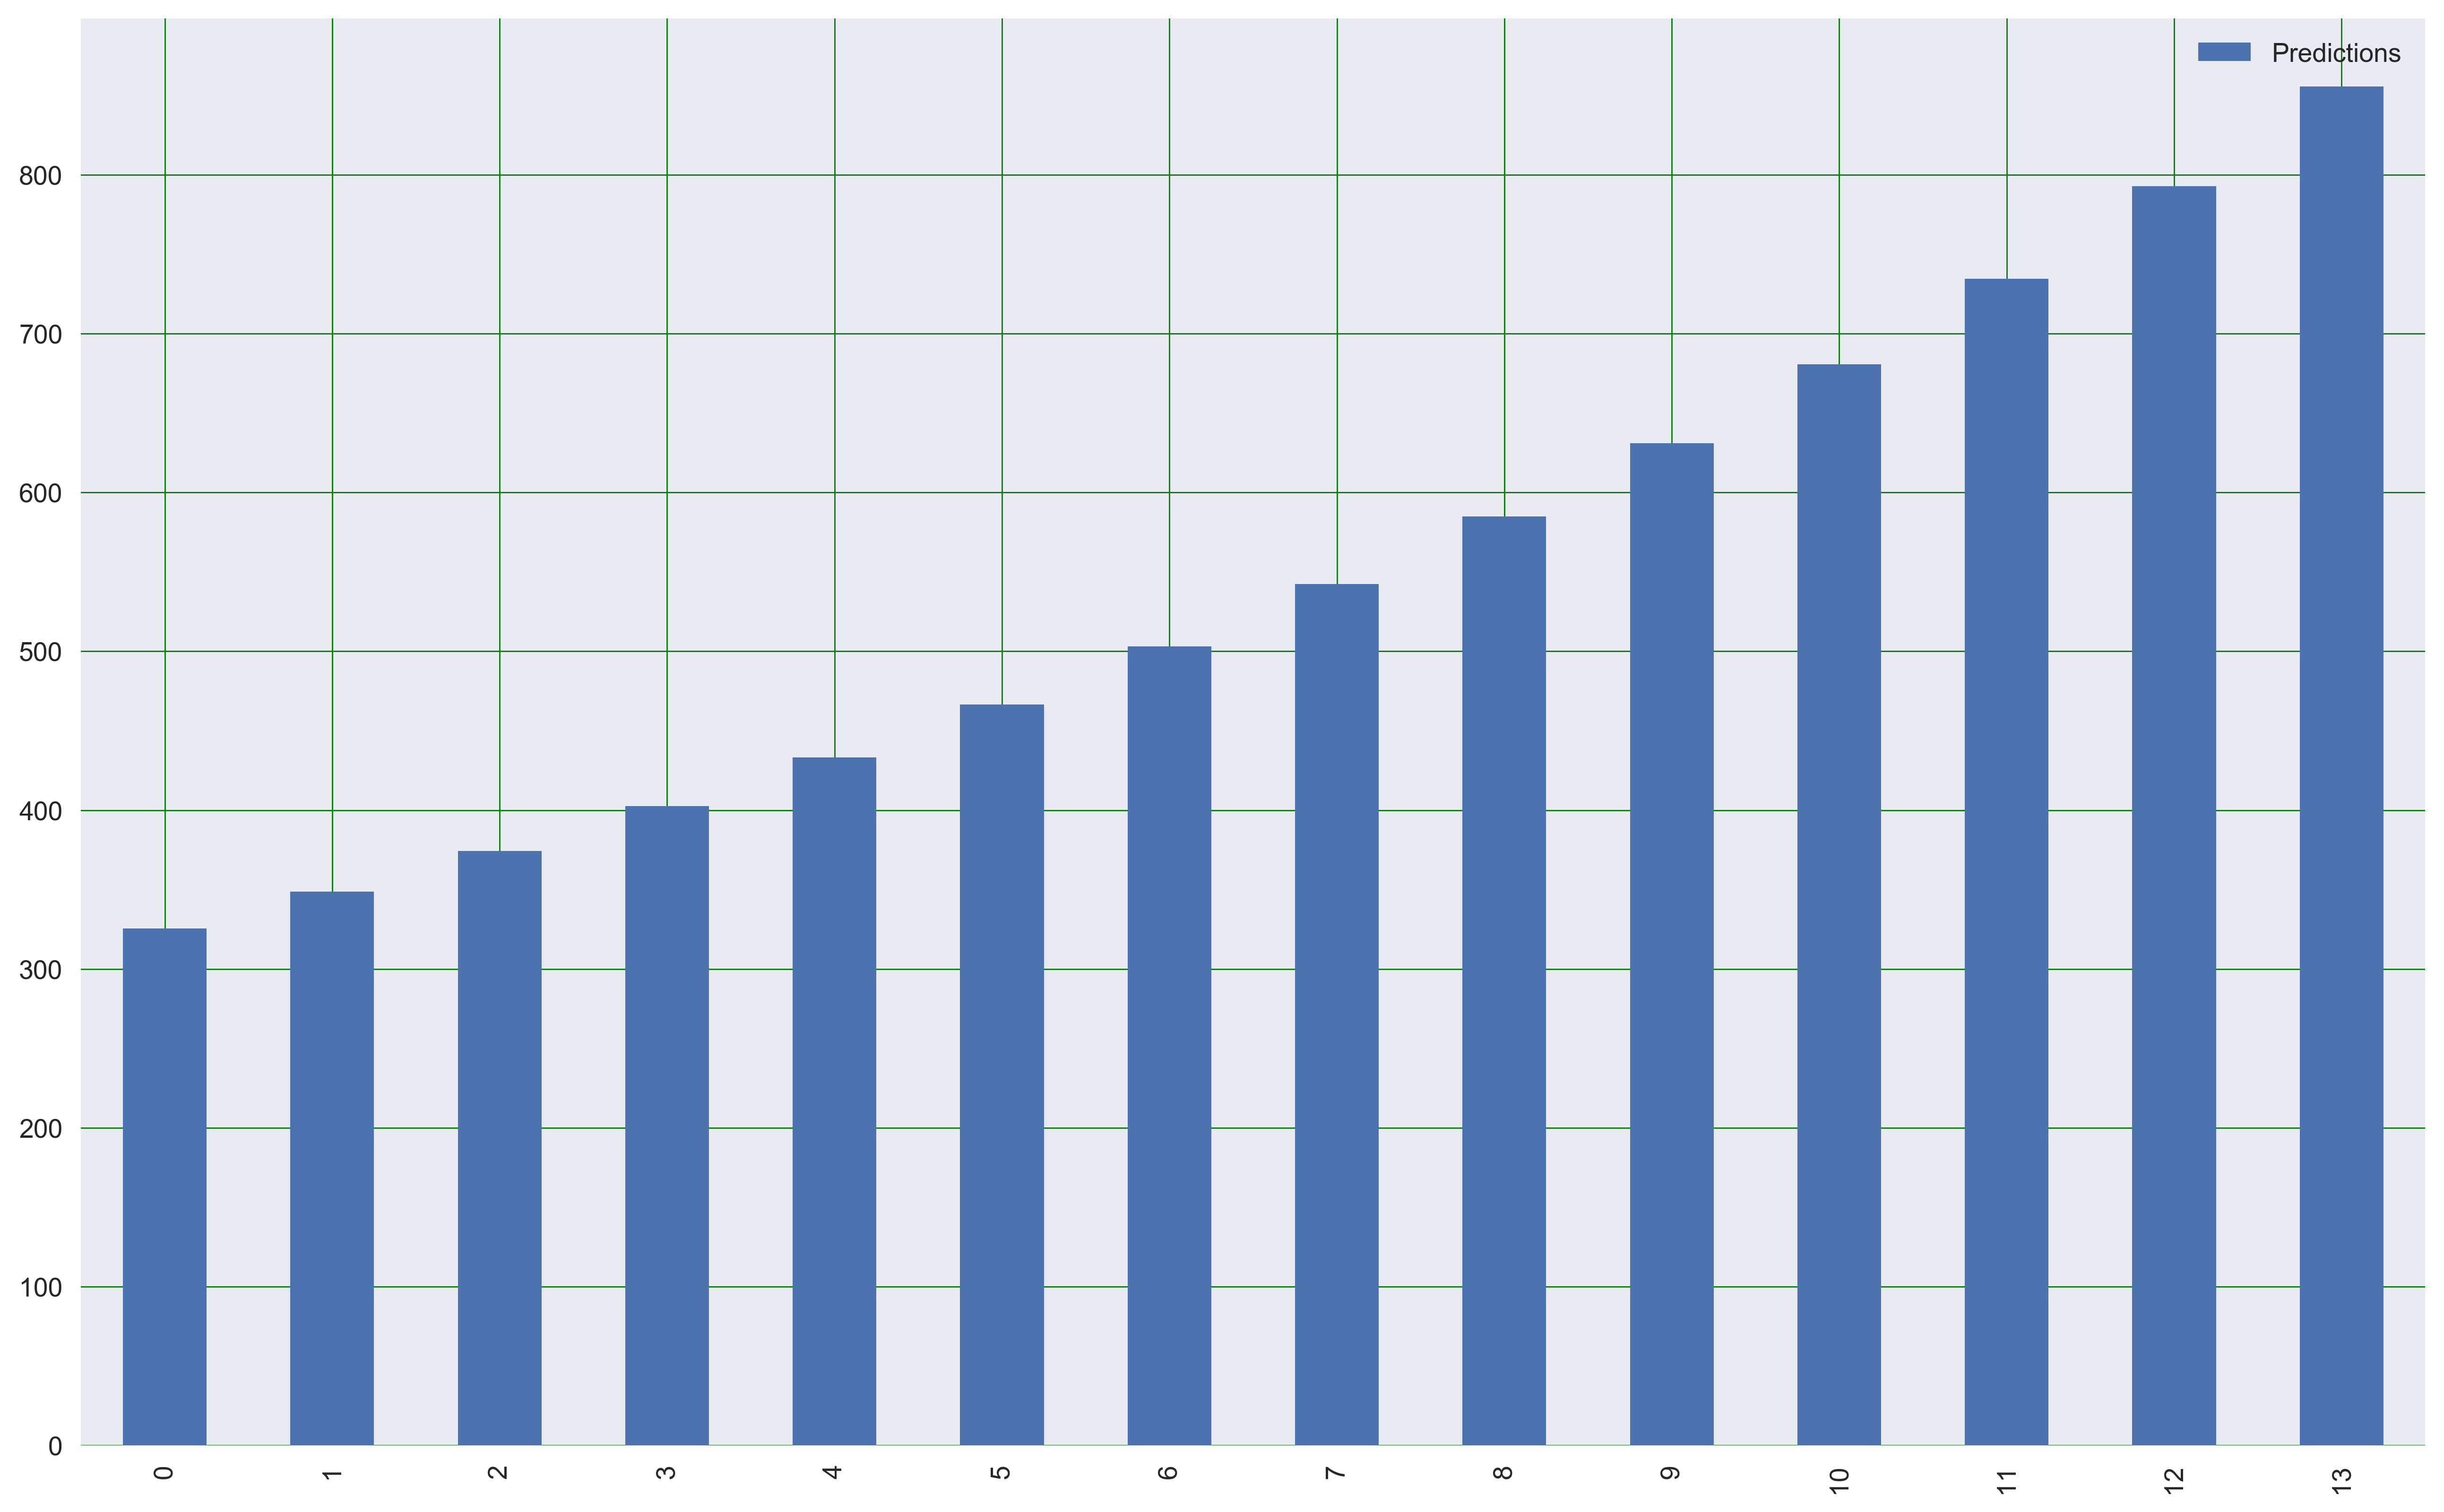

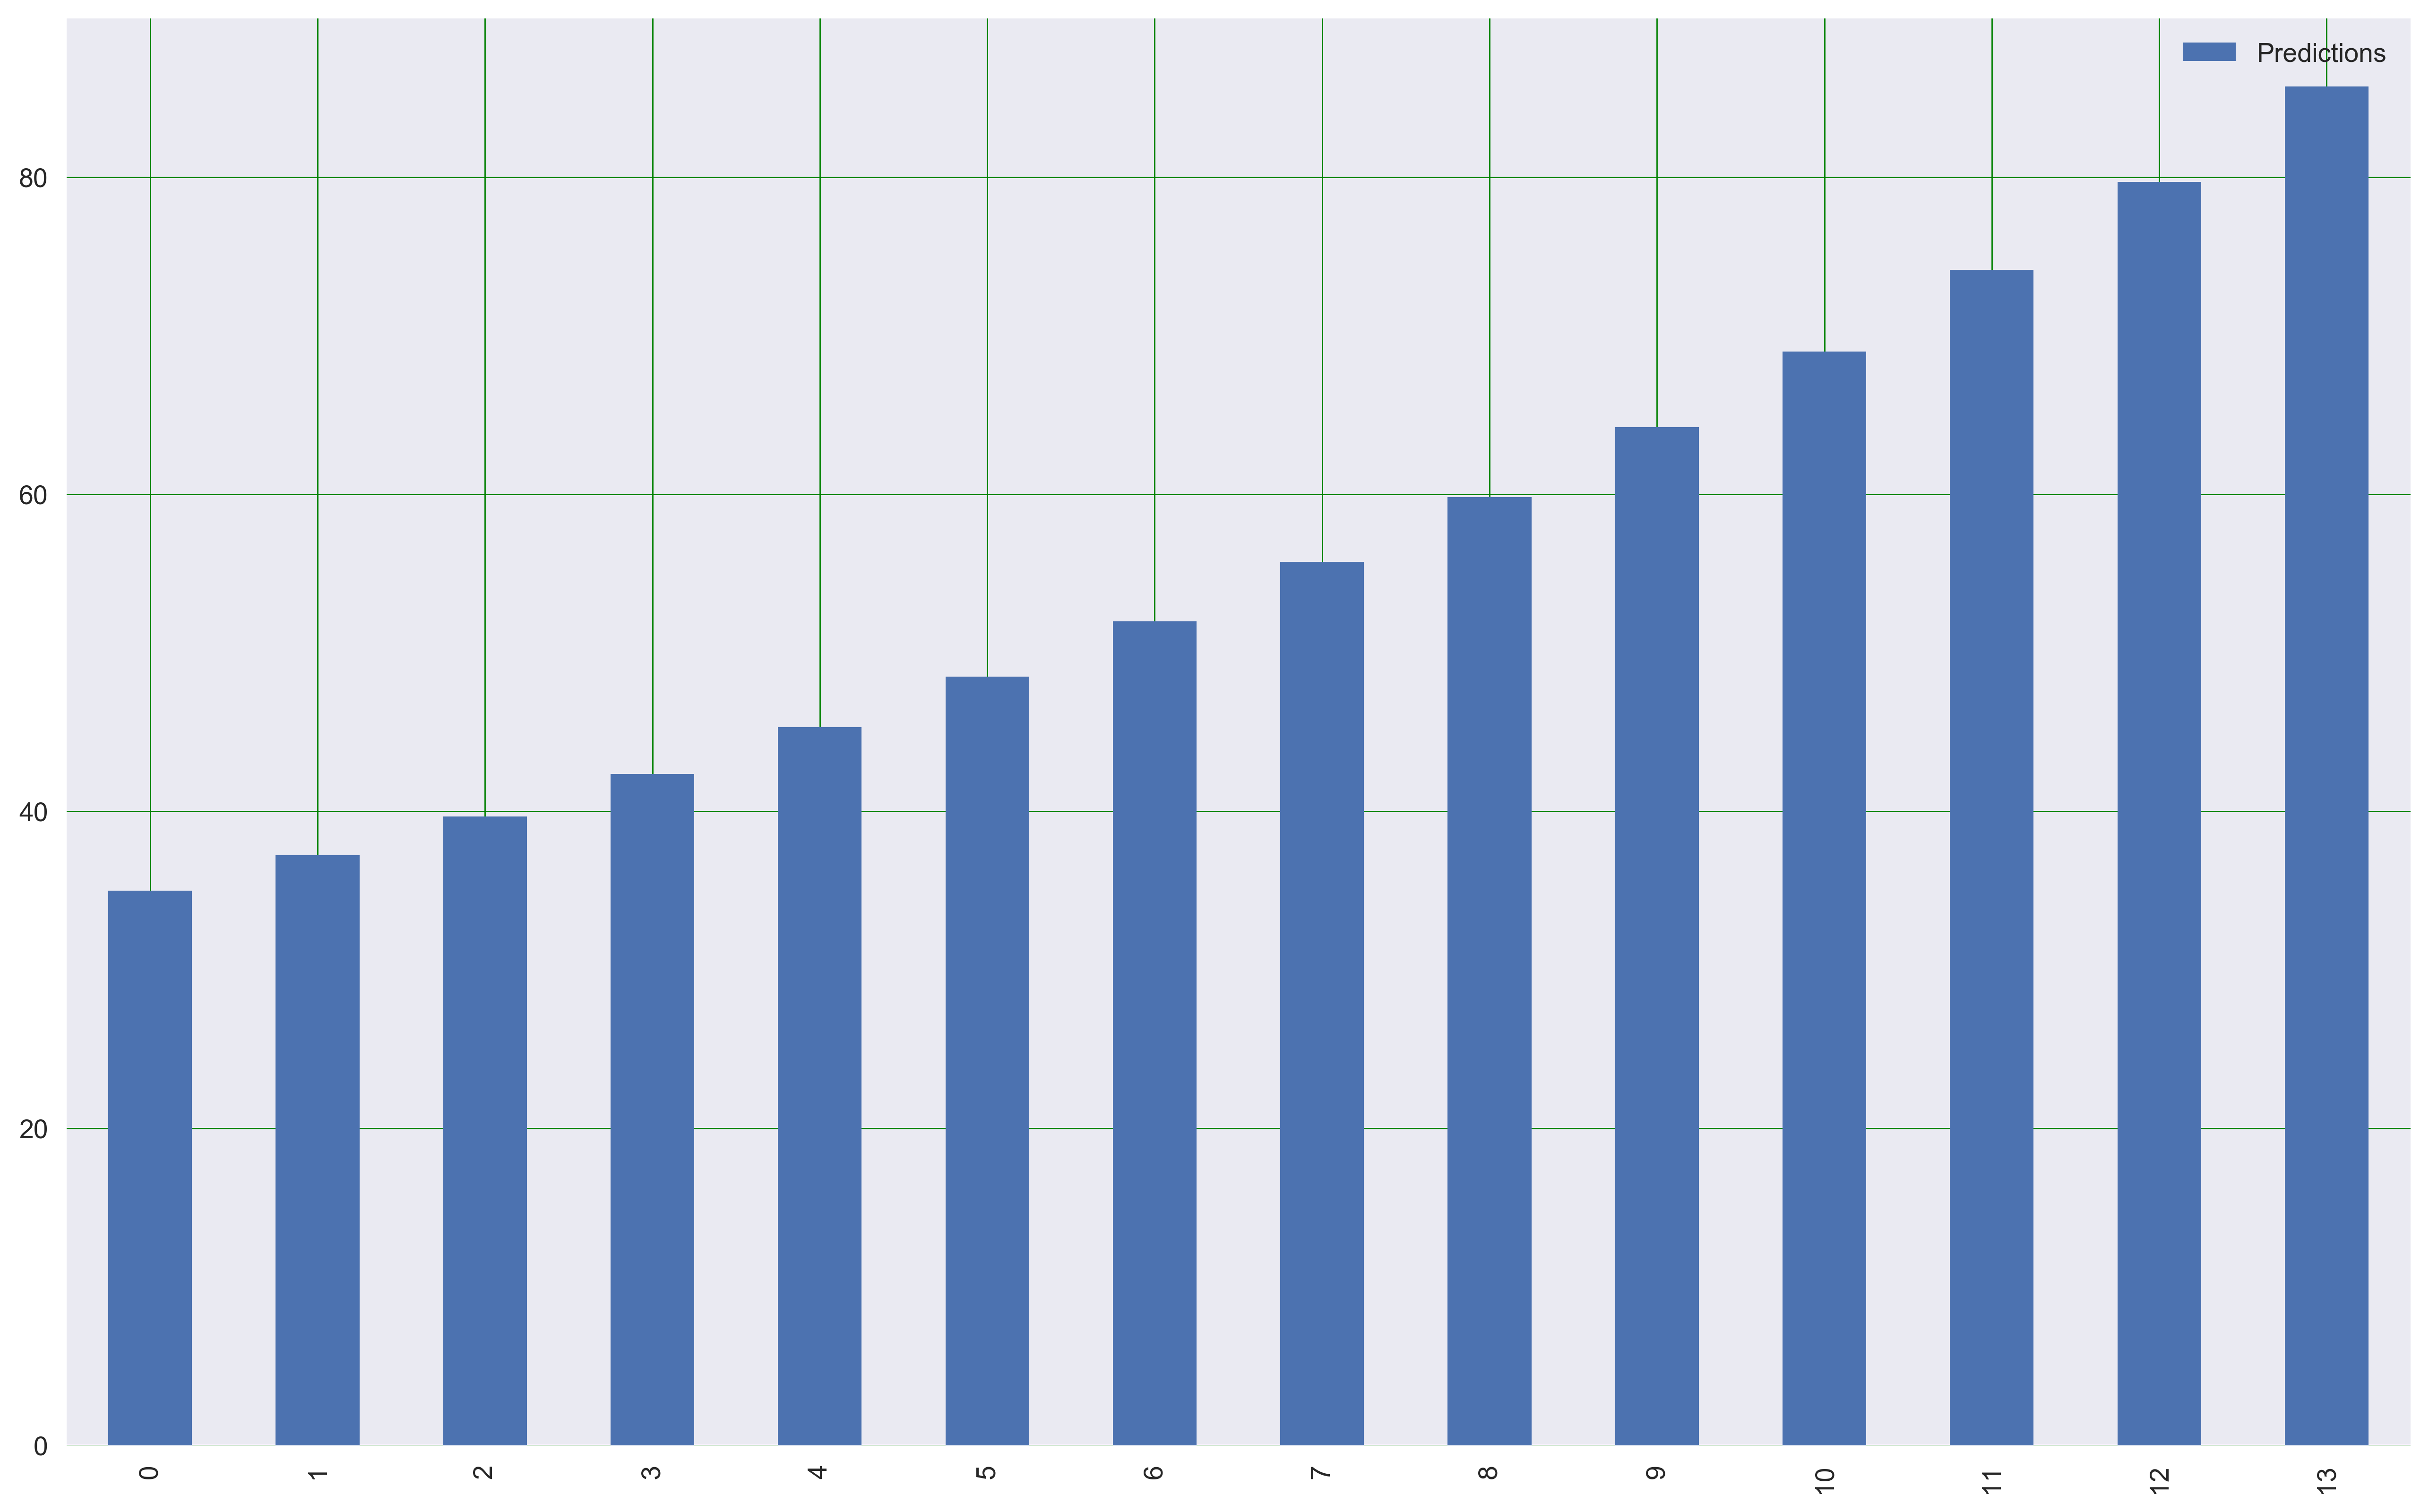

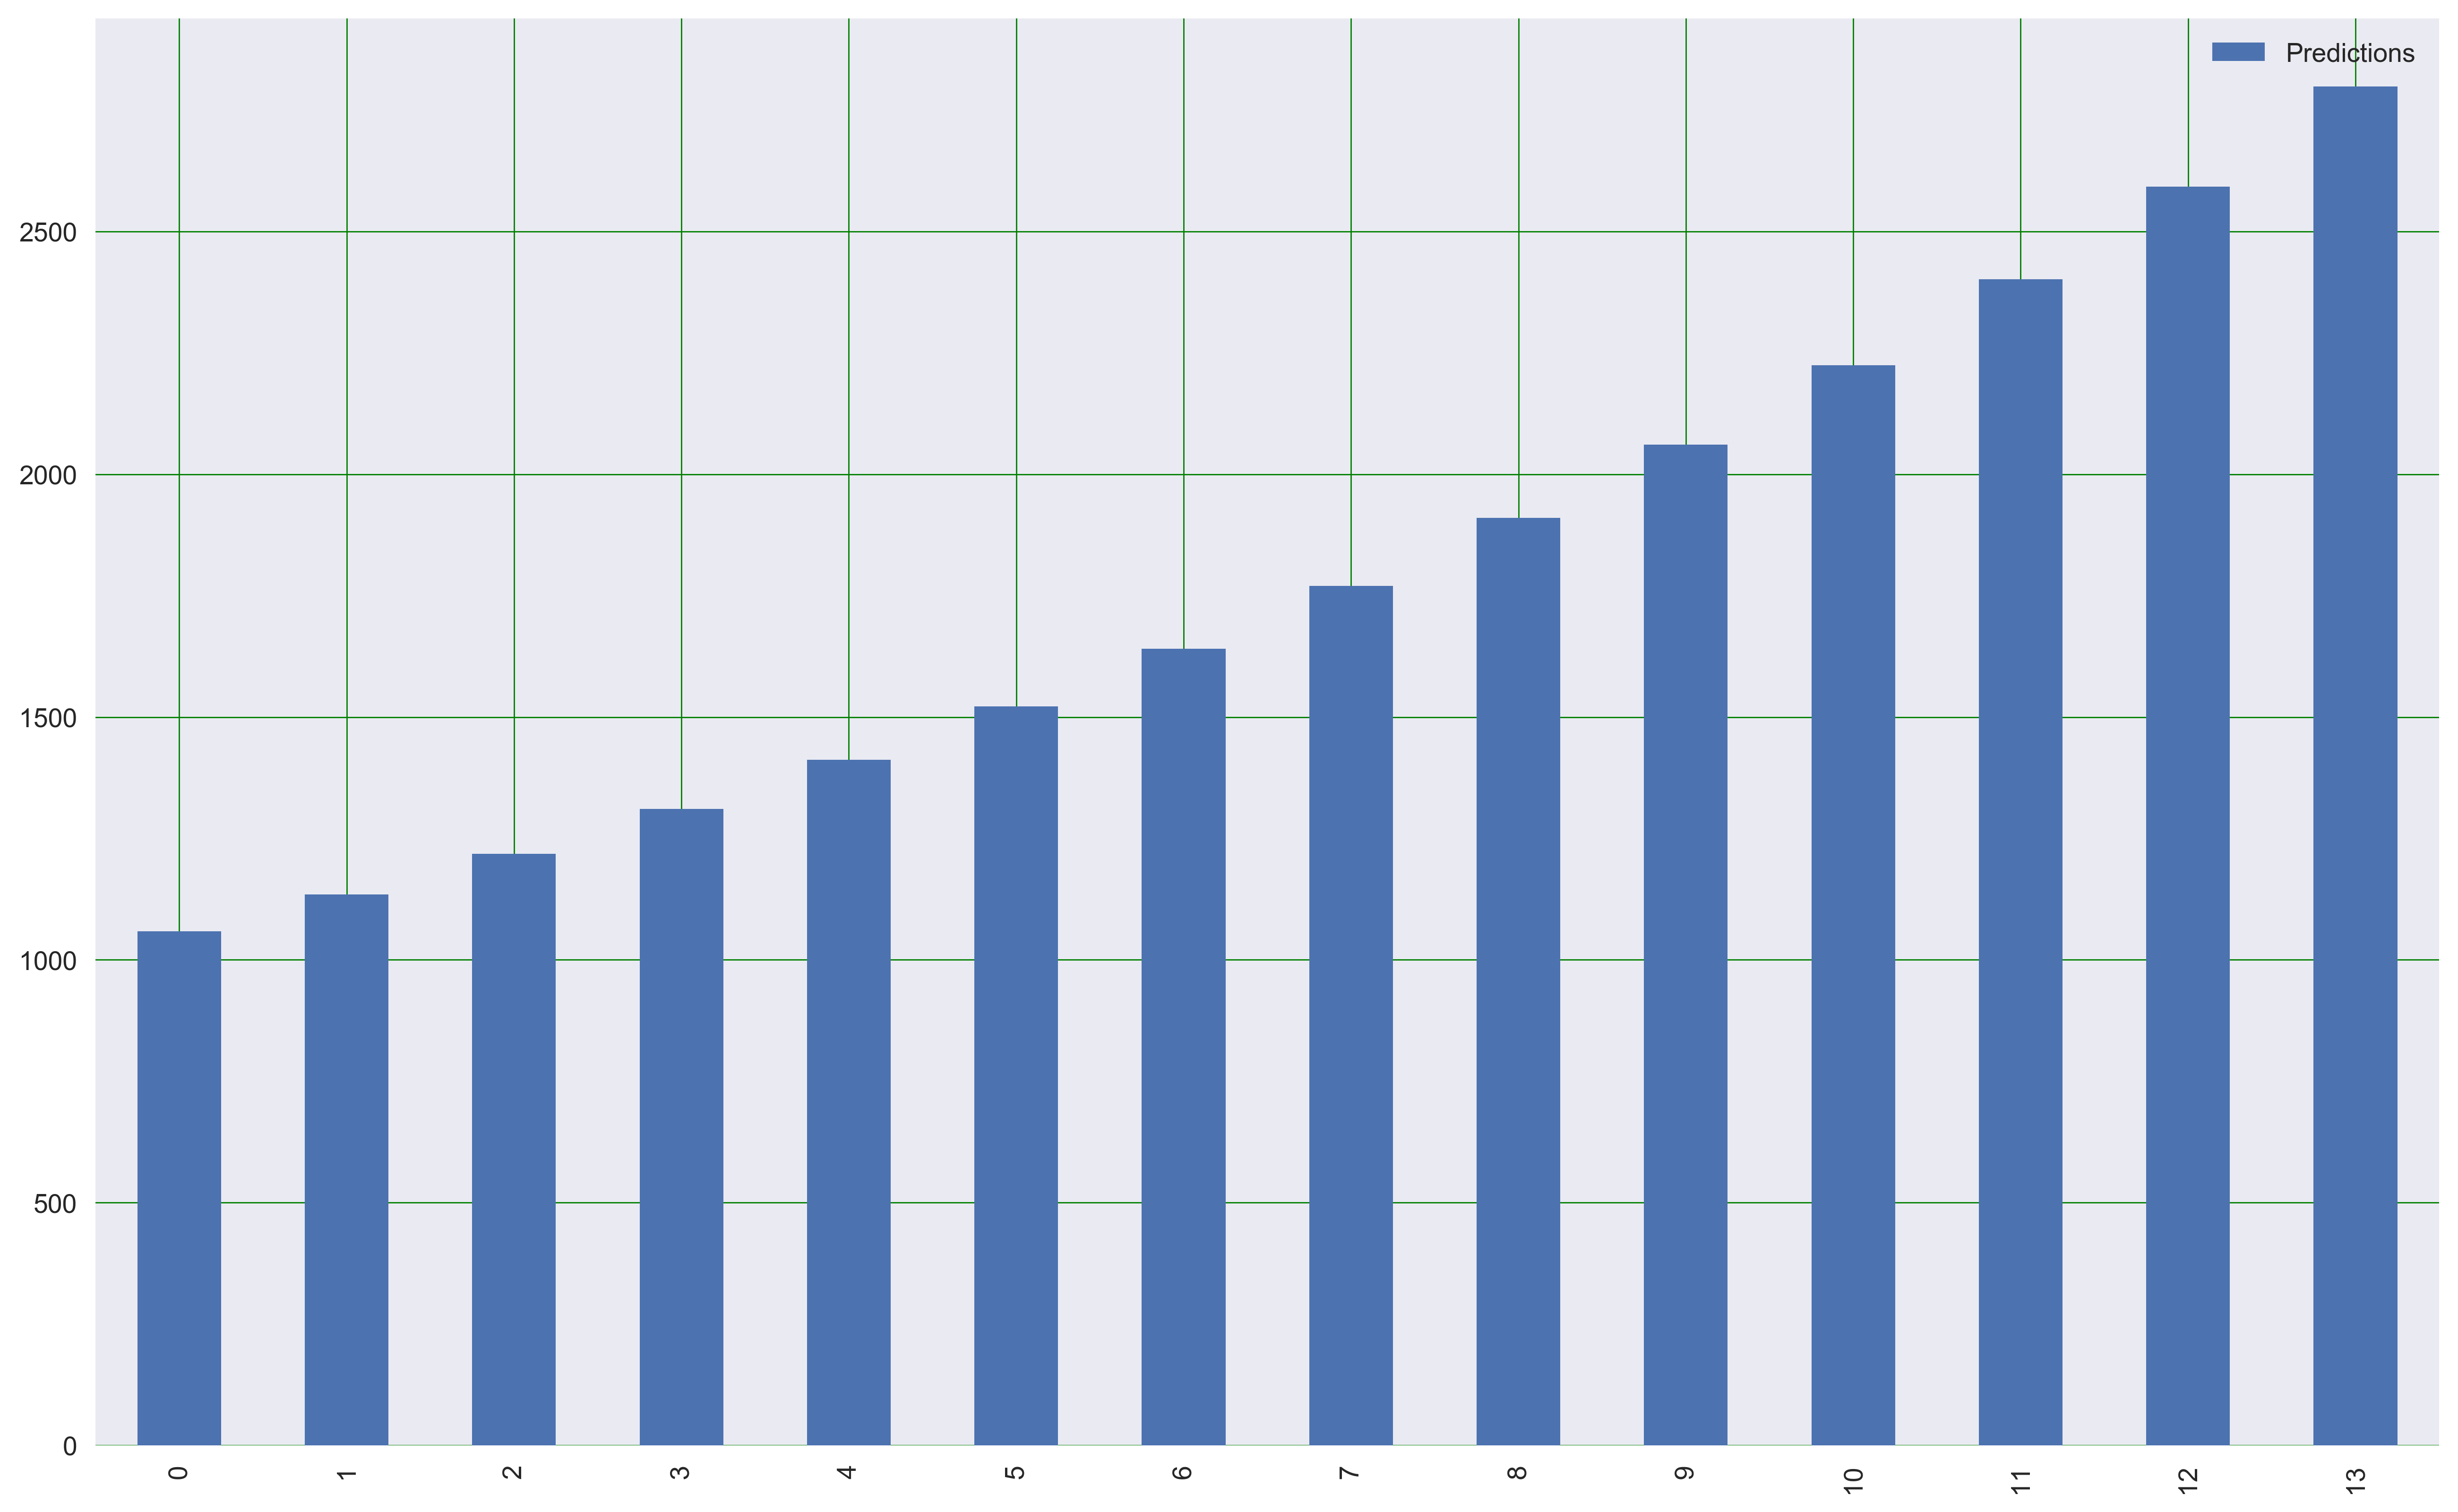

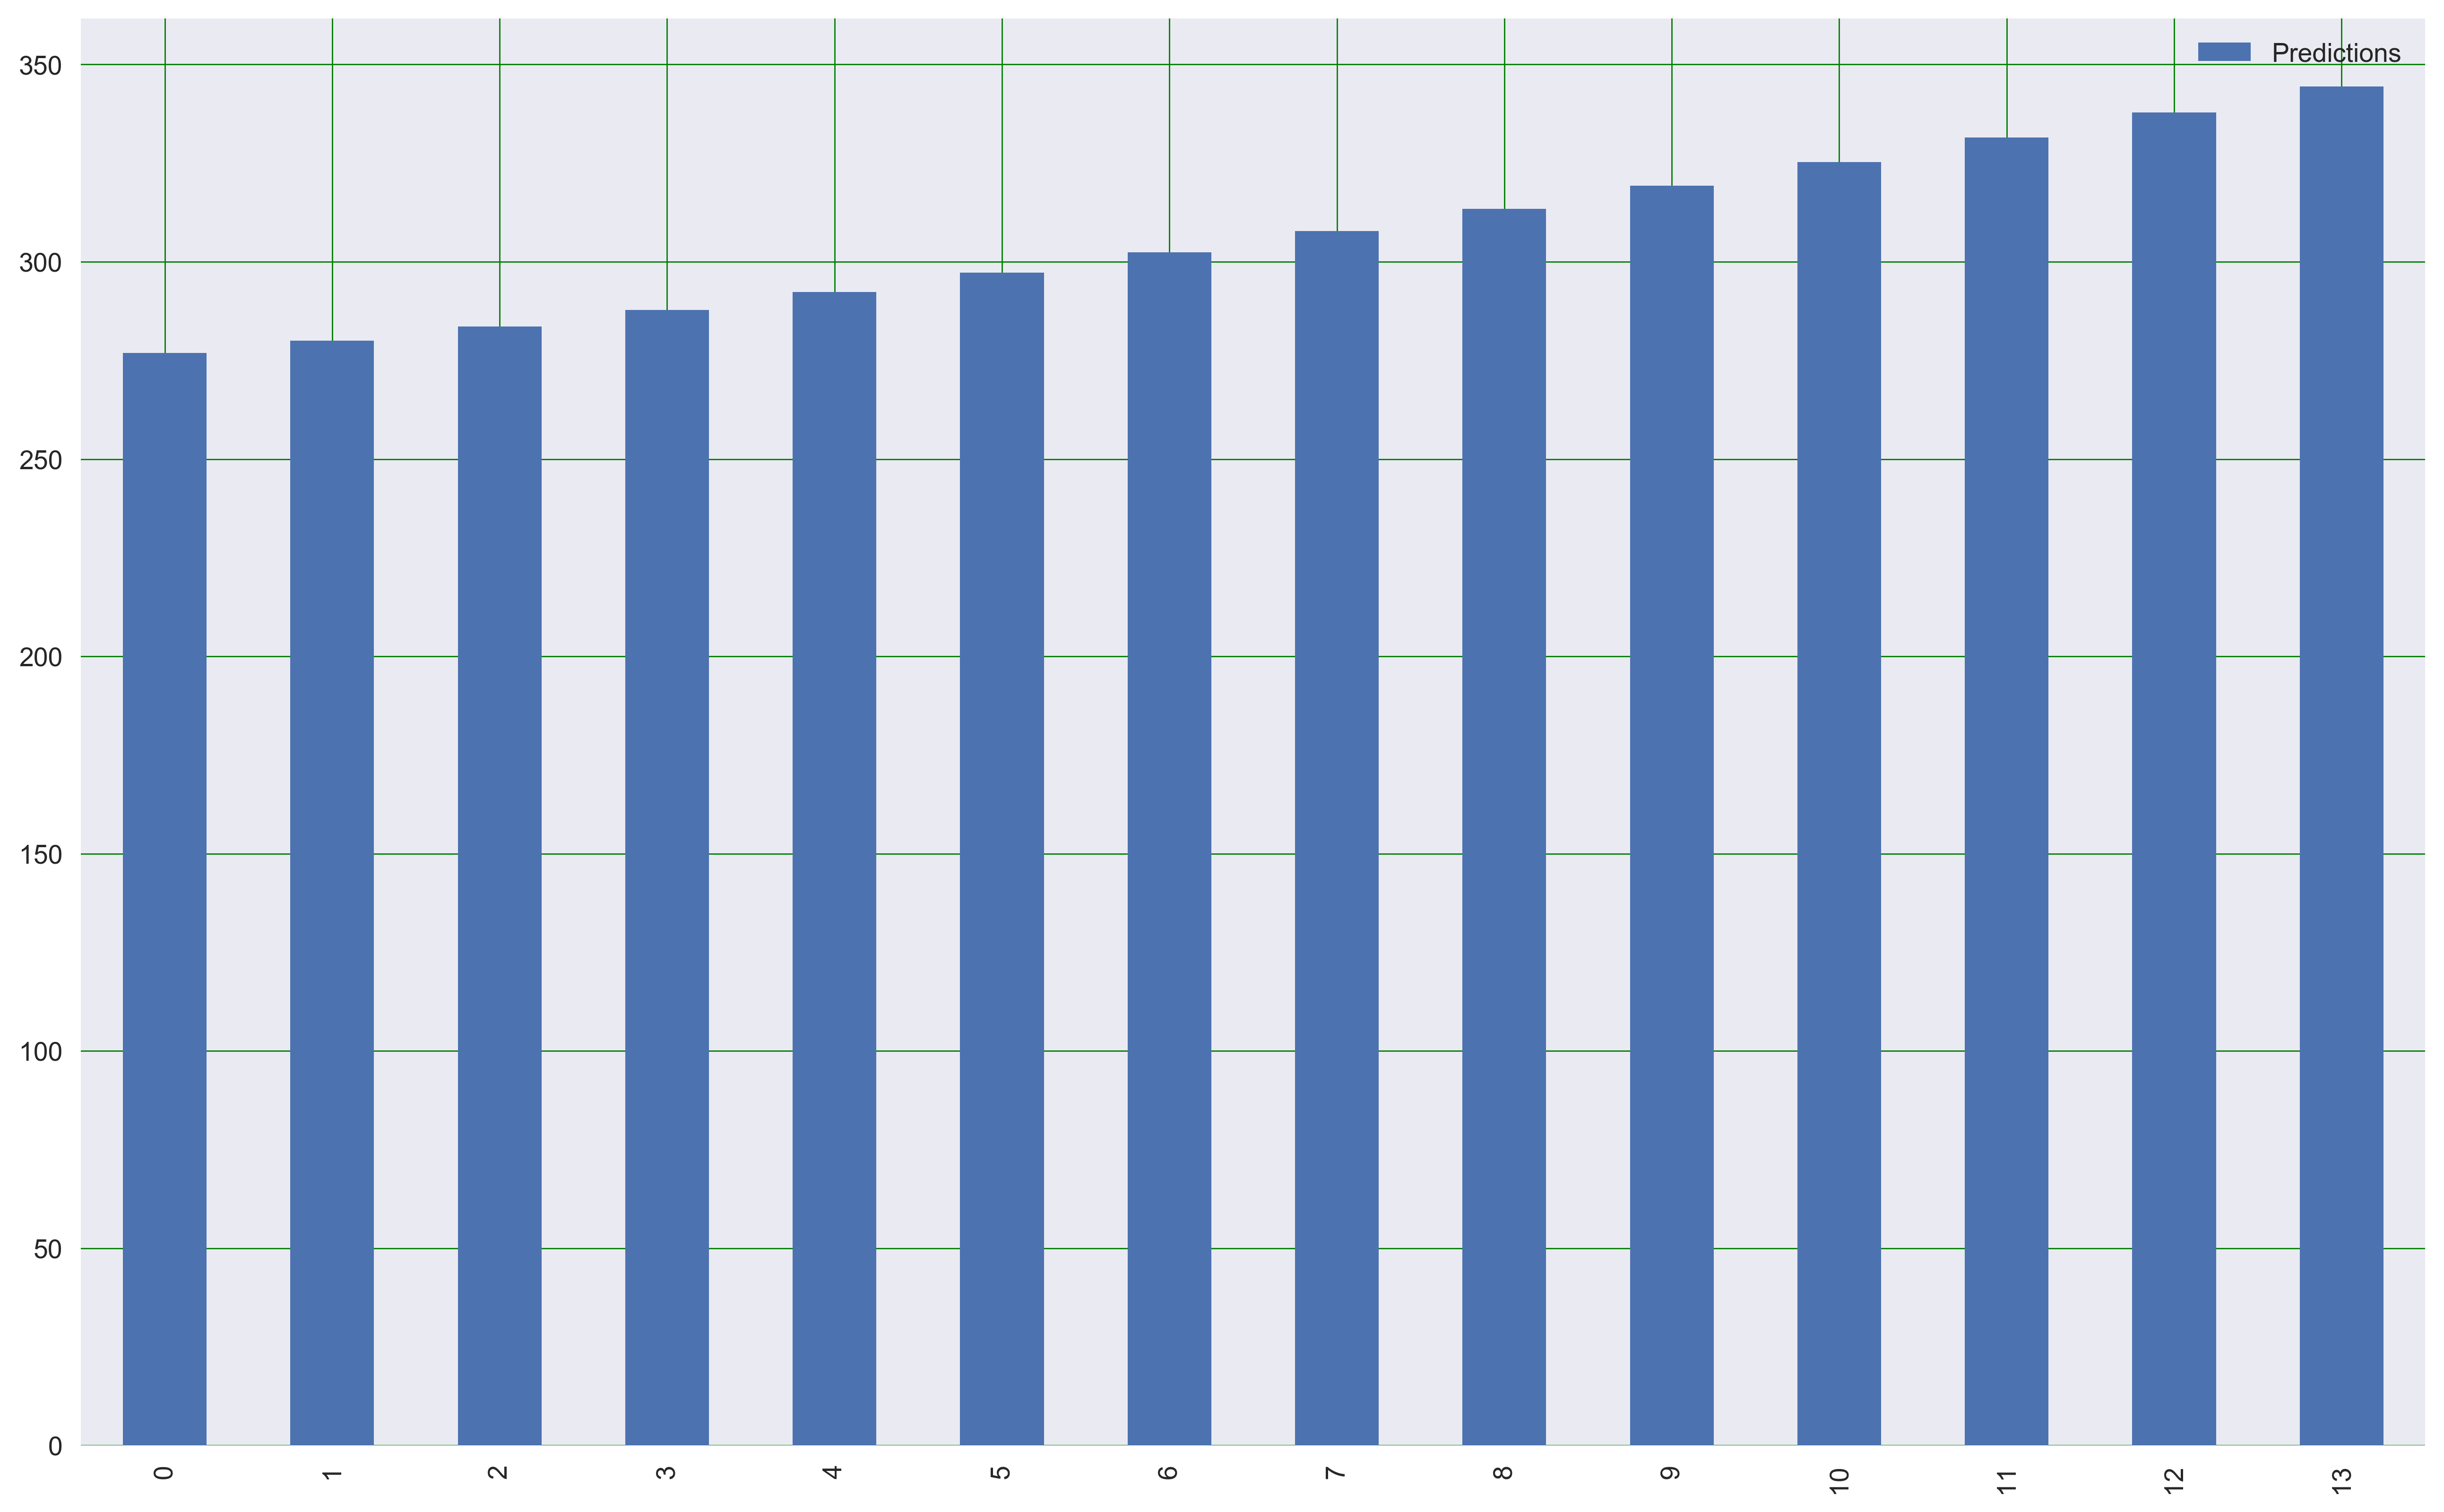

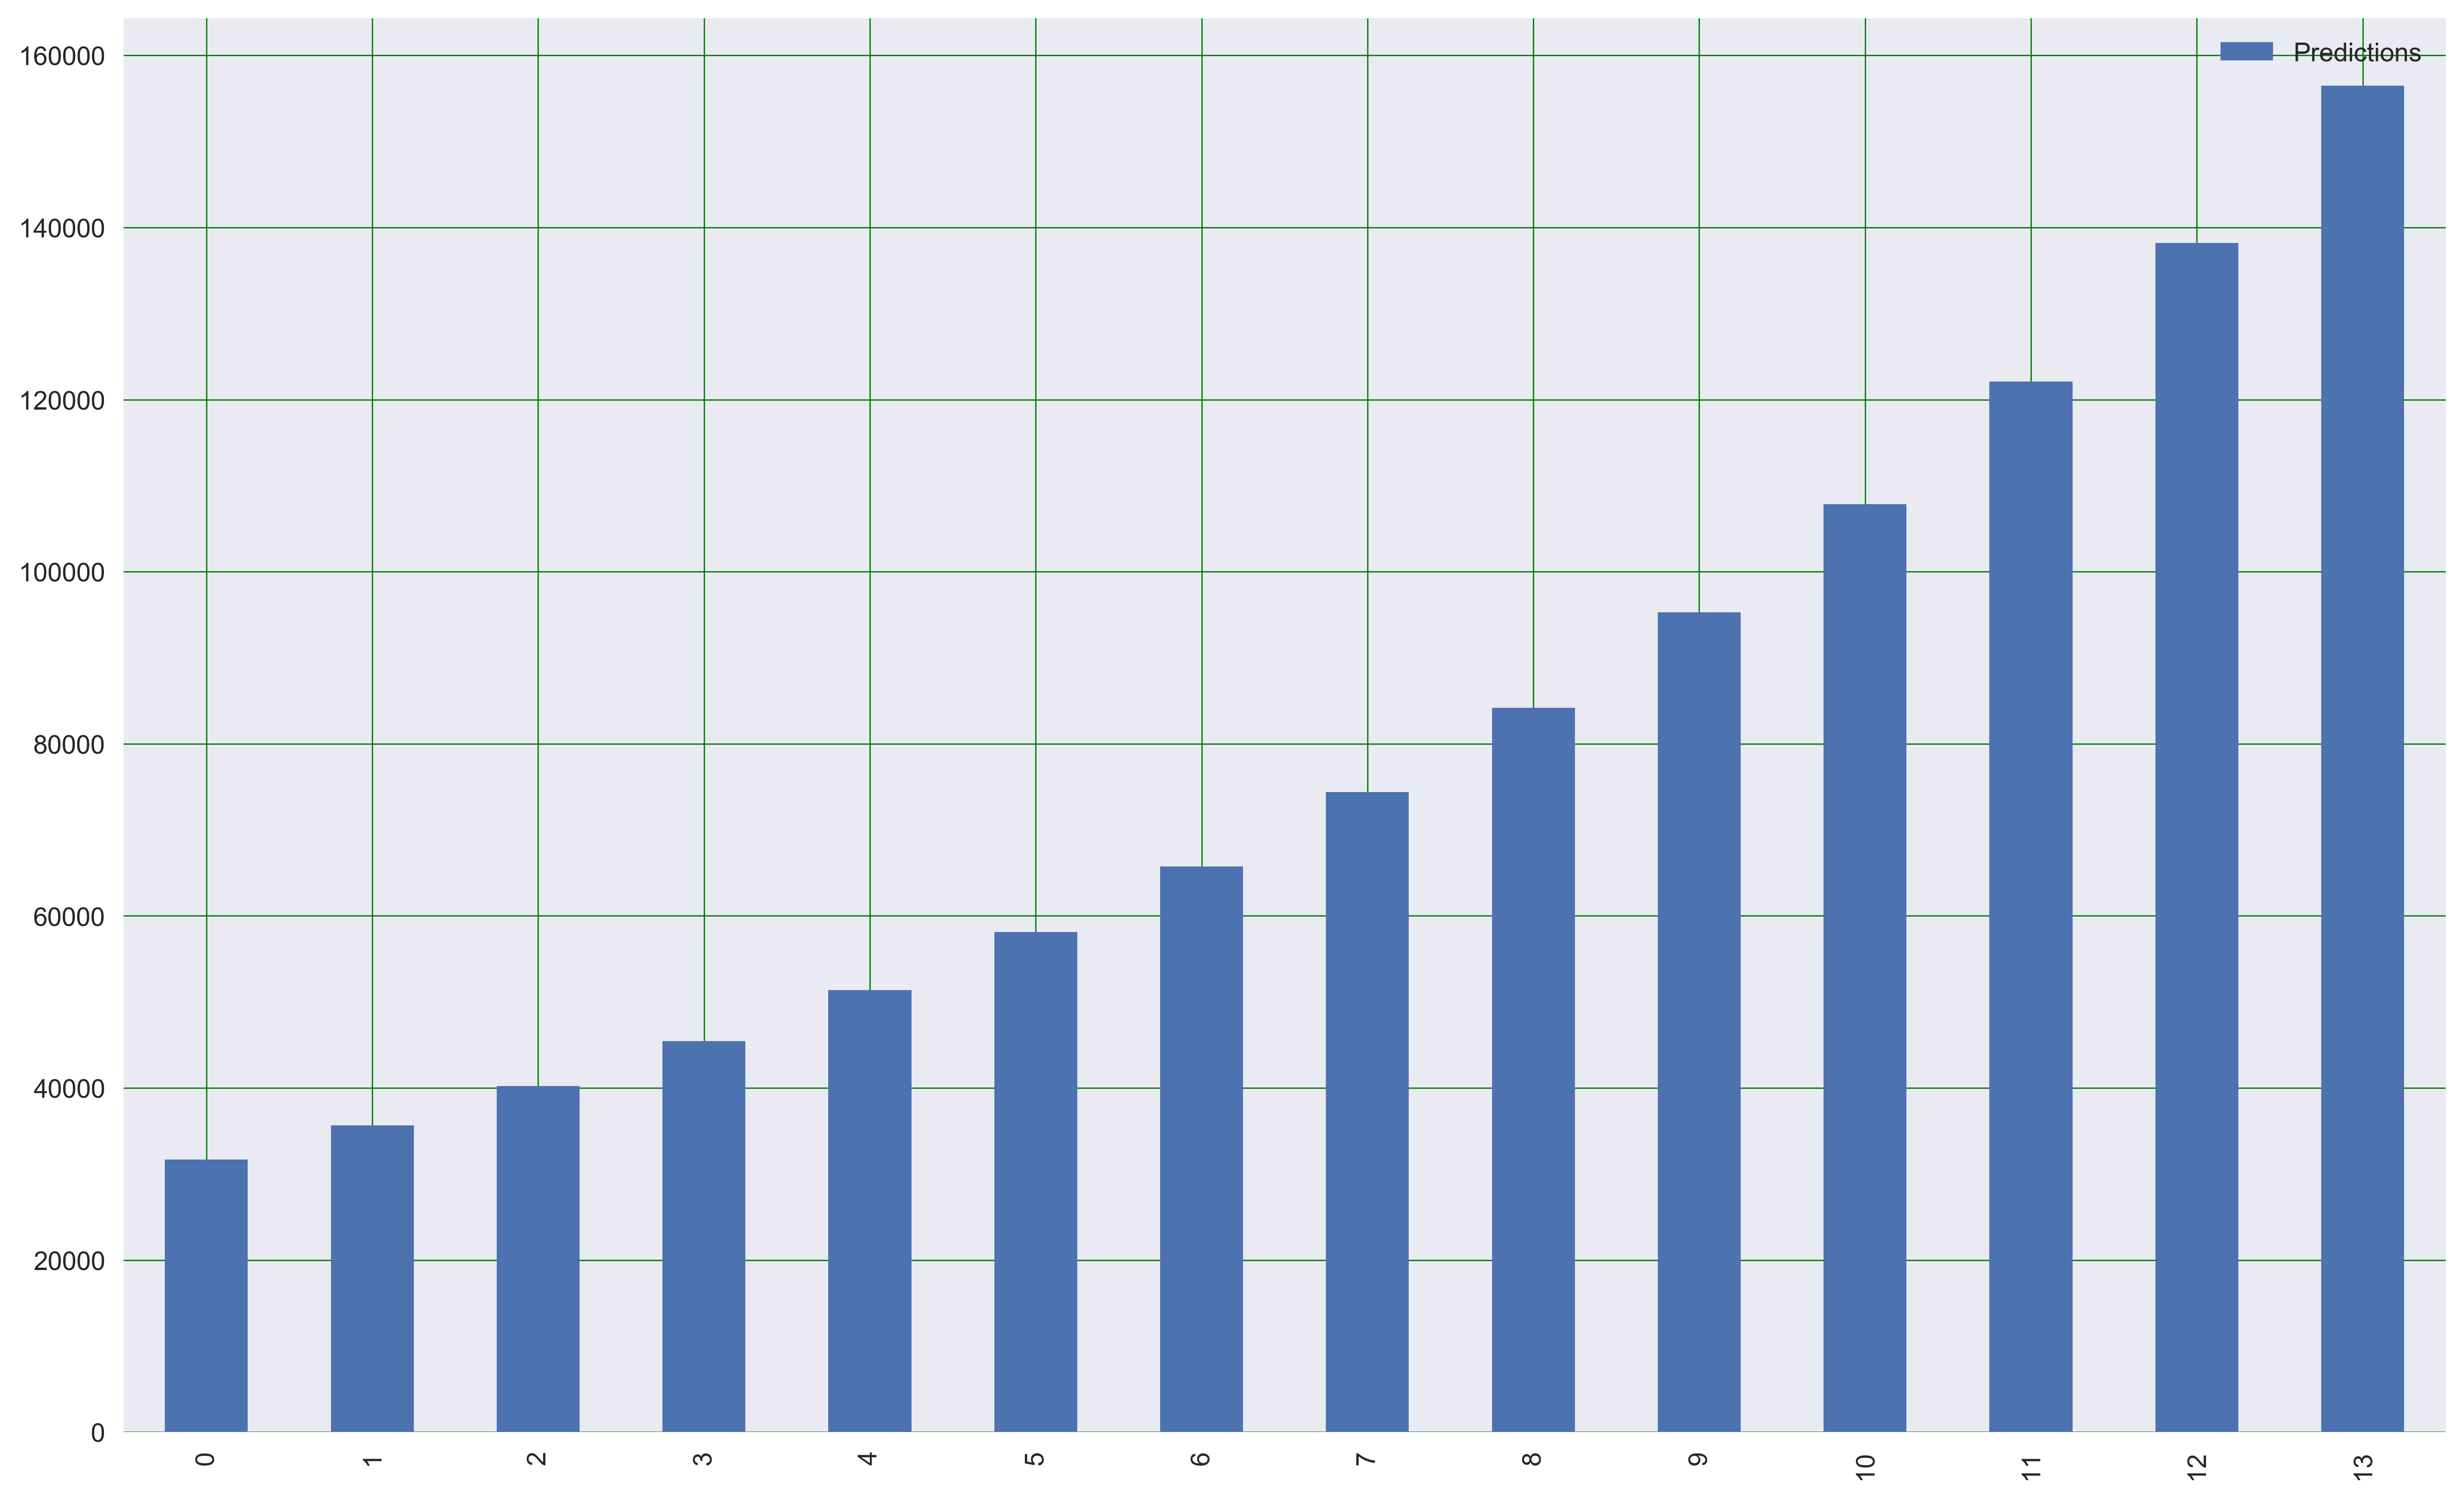

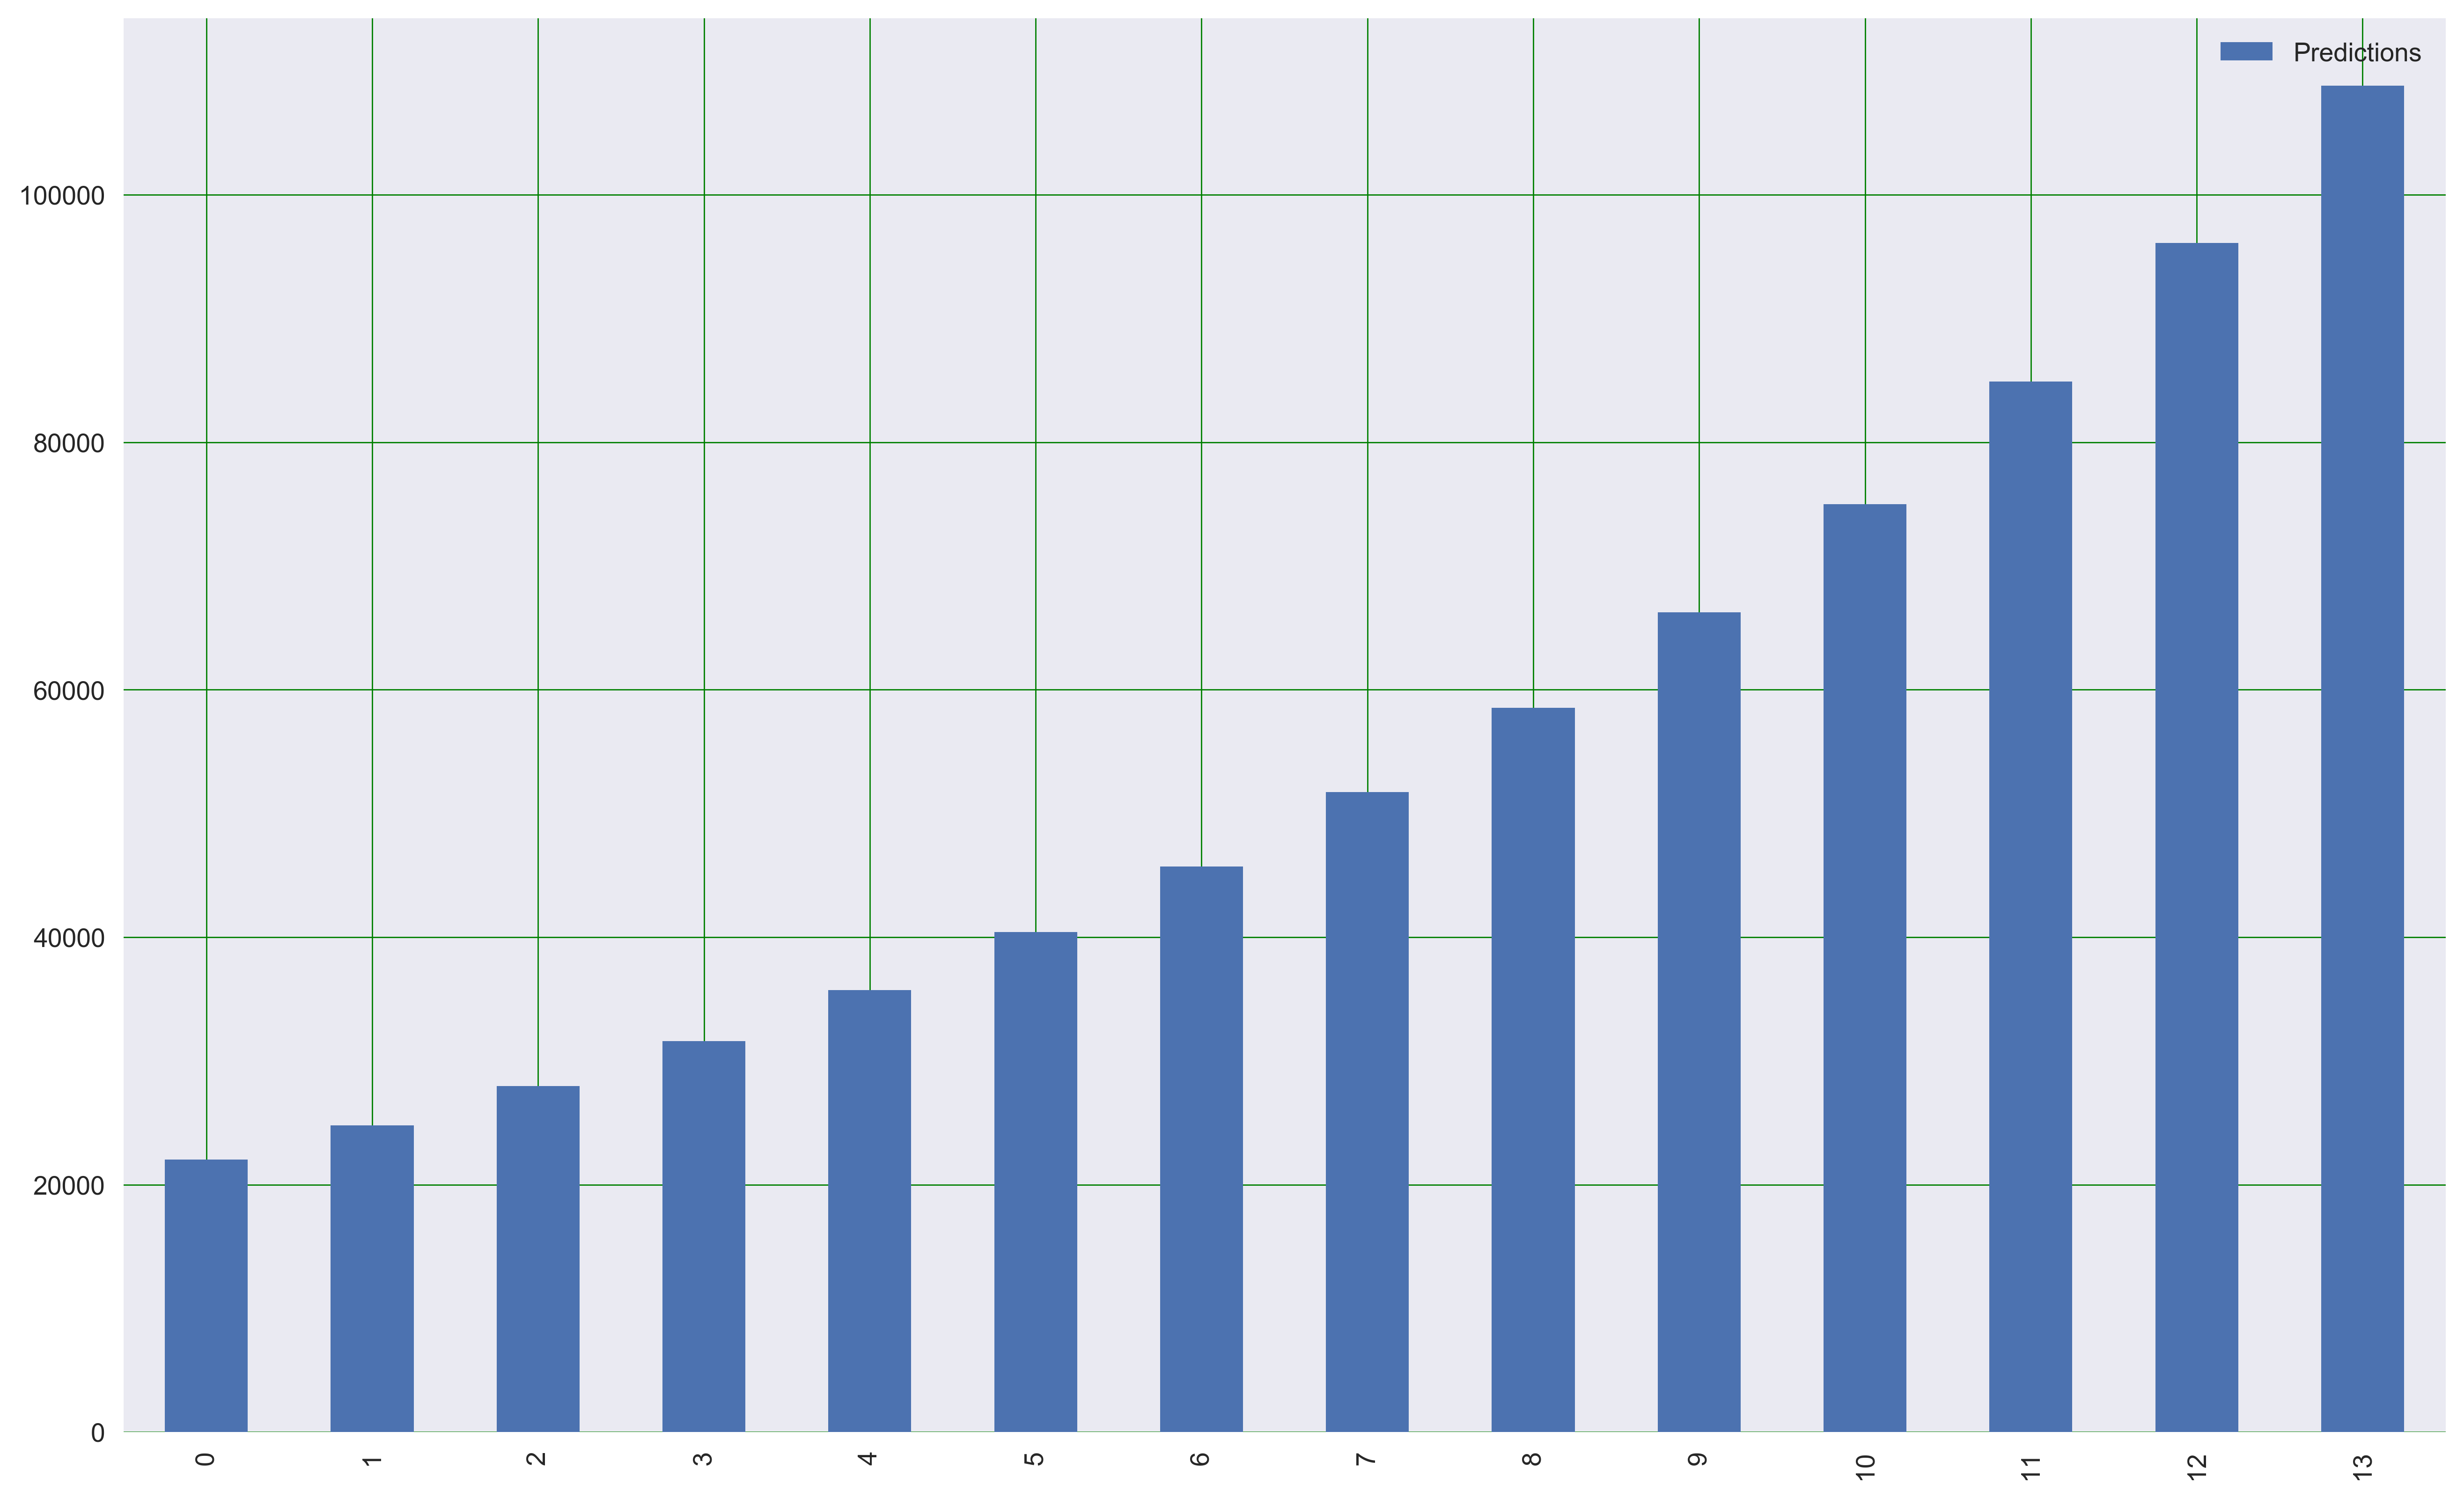

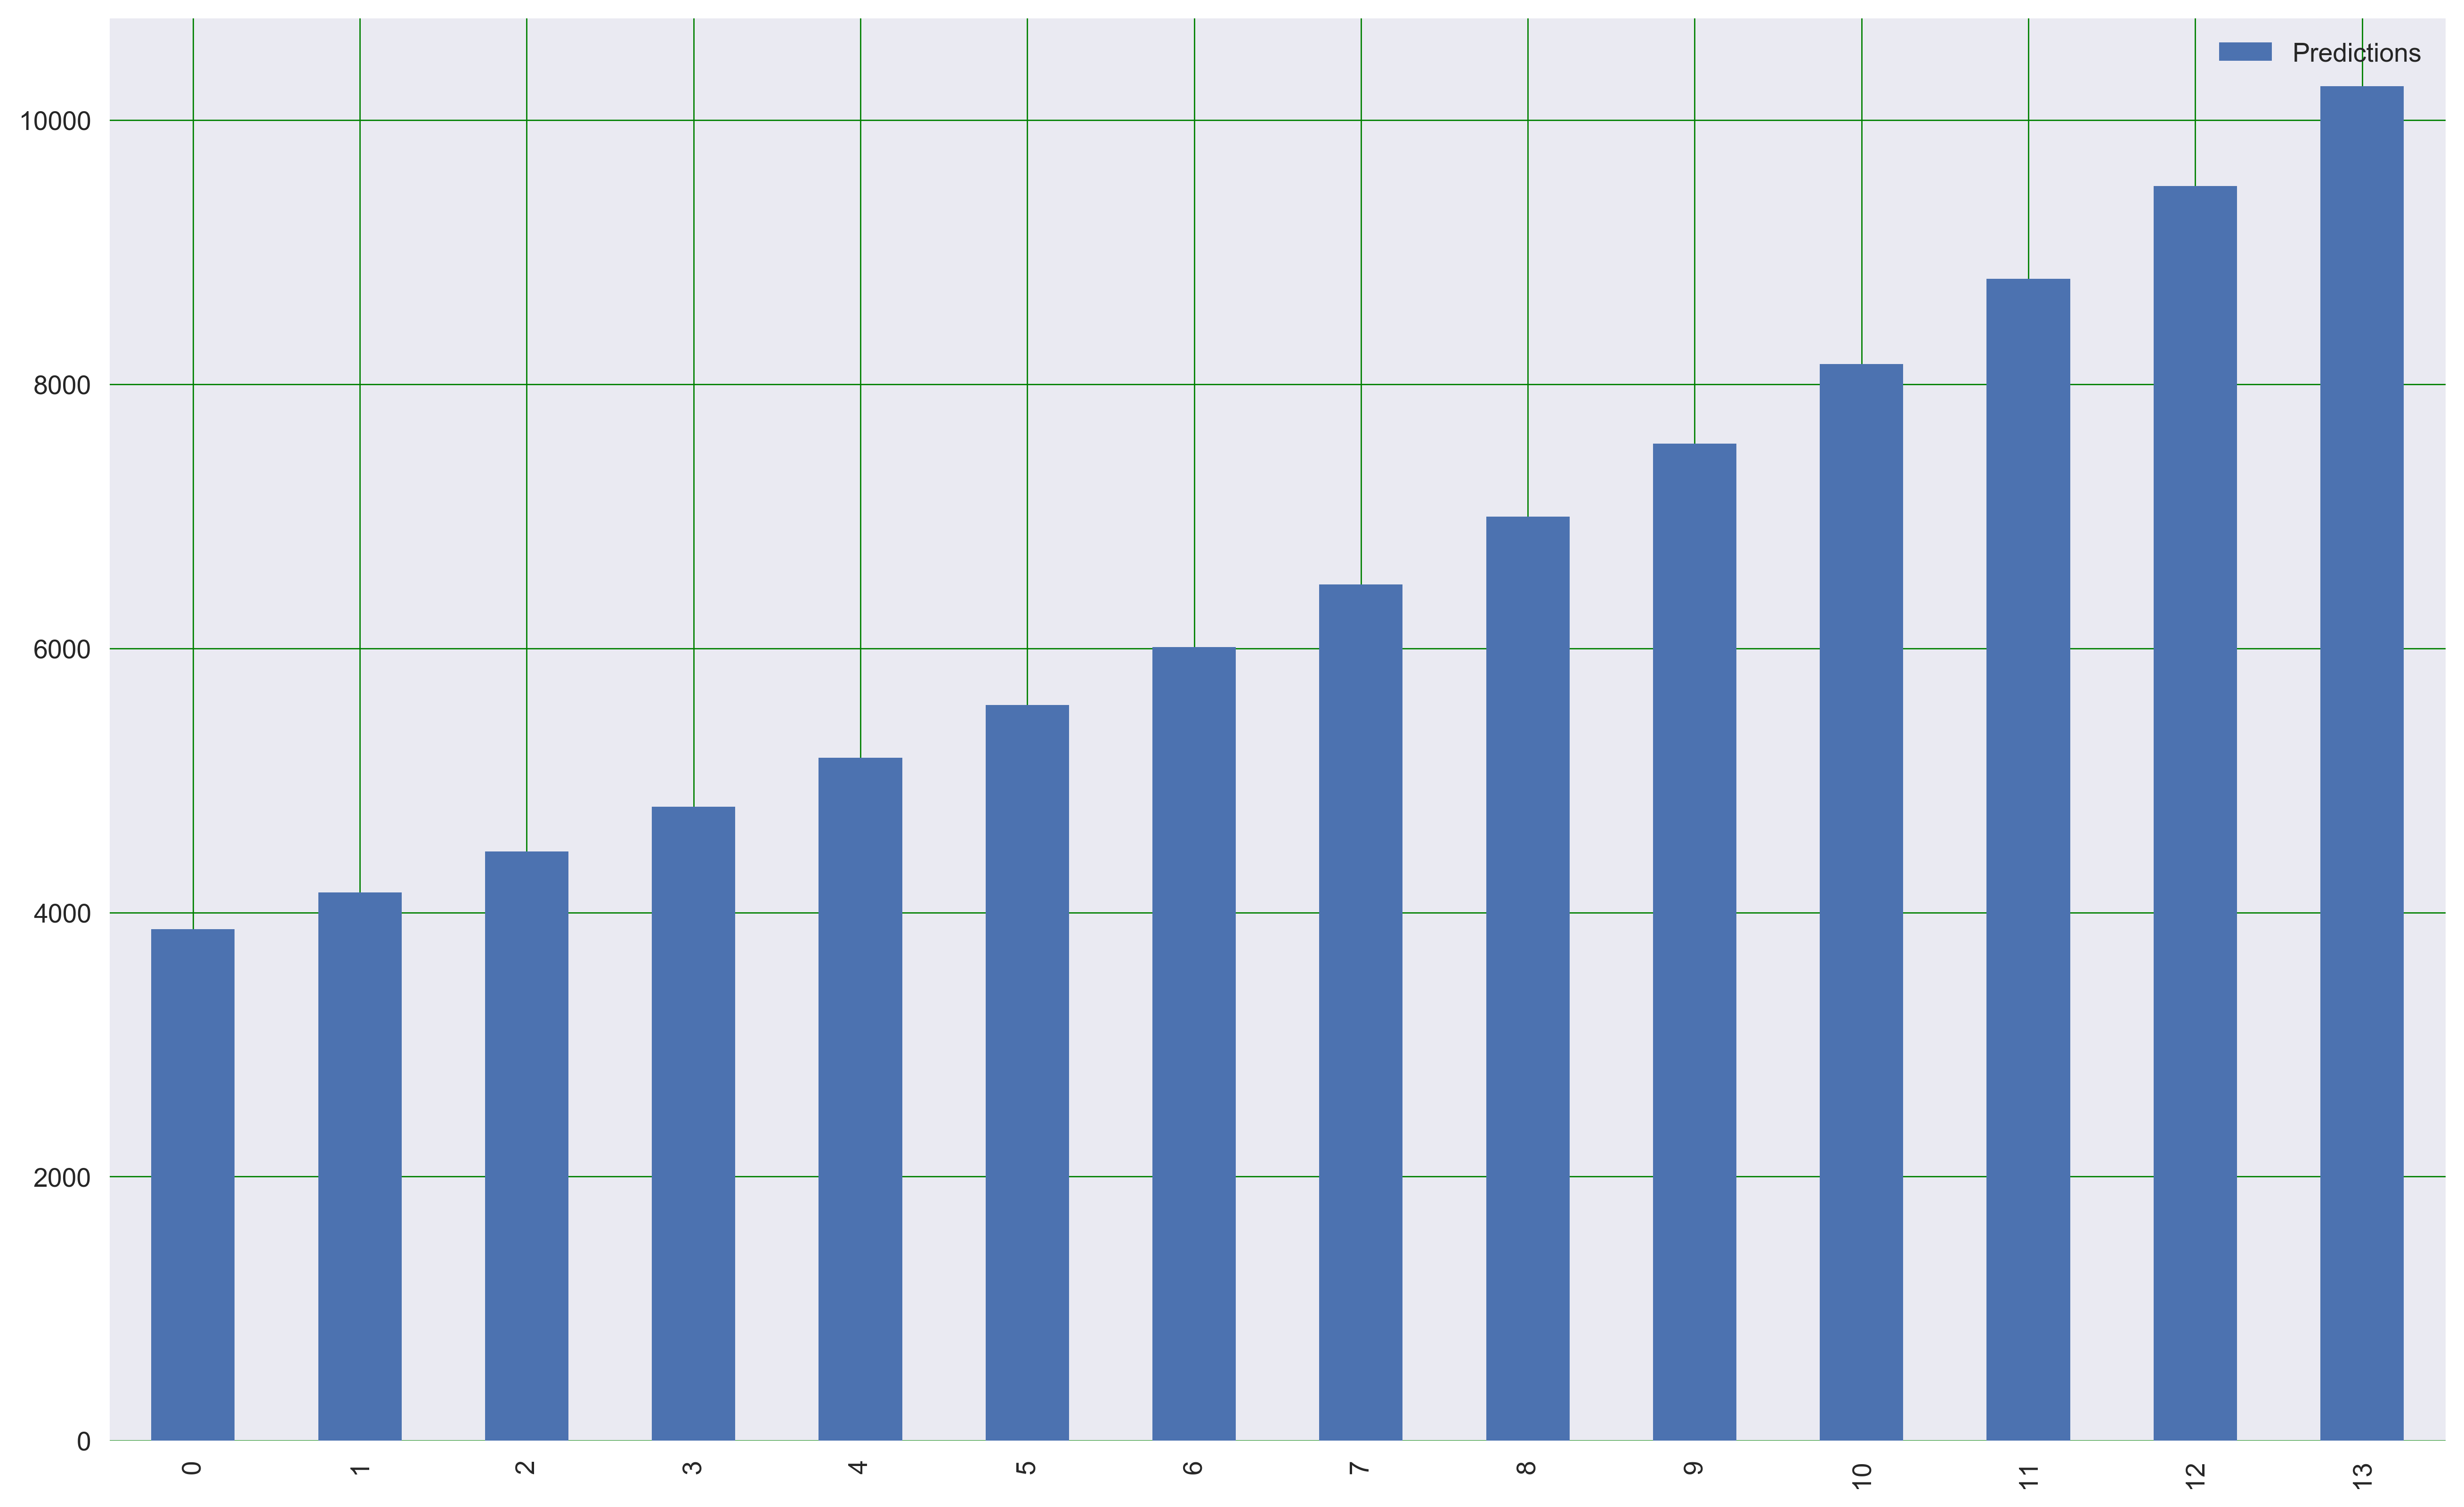

In [22]:
df_city_infected = pd.read_csv('city.csv')

# plot data
for index, row in df_city_infected.iterrows():
    # get city df
    selected_city = row['city']
    df_selected_city = df_city_infected.loc[df_city_infected['city'] == selected_city]
    
    # get numpy array per city
    df_numpy = df_selected_city.drop('city', axis=1)
    selected_city_arr = df_numpy.to_numpy()[0]
    selected_city_test_x, selected_city_test_y = create_dataset(selected_city_arr[0:25], OPTIMAL_WINDOW)
    
    # predict per city
    selected_city_predictions = lr_model.predict(selected_city_test_x)

    selected_city_test_dic = {}
    selected_city_test_dic['Predictions'] = selected_city_predictions
    selected_city_test_df = pd.DataFrame(selected_city_test_dic)
    
    df_selected_city = selected_city_test_df.sort_values(by=['Predictions'], ascending=True)
    df_selected_city.plot(kind='bar',figsize=(16,10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.savefig('./data/'+selected_city+'.png')